### Introduction

### Training Process

#### Step 1: Look for faces from video frames

#### Step 2: Calculate the embedding vector for every face

    A face embedding is a vector that represents the features extracted from the face.
    For example, another vector that is close (by some measure) may be the same person,
    whereas another vector that is far (by some measure) may be a different person.

#### Step 3: Perform the clustering of the embedding vectors
     
    The goal of the clustering is to figure out which set of the embedding corresponds to the user.
    We use DBScan for clustering.

    We do not know how many people will appear on the images.
    As a result, we should not use “number_of_clusters” as an input to our clustering algorithm.
    
    For this reason, we used DBScan. Major challenge of using DBSCAN algorithm is to find right
    set hyper parameters(eps and min_samples values) to fit in to the algorithm for getting accurate result.    

### Importing the Libraries

In [1]:
from numpy import unique
from numpy import where
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from itertools import product 
from plot_utils import plot_clusters, plot_pca_variance
import time
from face_detection import FaceDetection
from action_recognition import ActionRecognition
import cv2
import seaborn as sns
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

C:\Users\Haliva\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Haliva\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Haliva\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Haliva\anaconda3\envs\myenv\lib\site-packages\tensorflow\pyth

### Collect Faces from video frames

In [2]:
action_recognition = ActionRecognition()
faceDetection = FaceDetection()
vs = cv2.VideoCapture("video.mp4")
faces = []


# Loop Video Stream
while True:

    (grabbed, frame) = vs.read()
    
    if frame is None:
        break
        
    # Step 2: Calculate the embedding vector for every face
    temp = faceDetection.detect_faces(frame, "video.mp4", 0.95)
    faces.extend(temp)
    
    frame = cv2.resize(frame, (300, 300))
    cv2.imshow('camera2',frame) 
    
    key = cv2.waitKey(1) & 0xFF

    if key == ord('q'):
        break
    
cv2.destroyAllWindows()

[2021-03-10 01:58:06,969] [TfPoseEstimator] [INFO] loading graph from C:\Users\Haliva\Data Science\Data Science Course - Final Project\libs\action_recognition\models\graph/mobilenet_thin/graph_opt.pb(default size=656x368)


mobilenet_thin
656x368
models/trained_classifier.pickle
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Feature Reduction - PCA - Principal Components Analysis

In [3]:
 def get_best_pca_dimensions(data, threshold_variance = 90):

    print("\n-------------------- get_best_pca_dimensions --------------------\n")

    n_components =  min(len(data), len(data[0]))
    sns.set_theme()

    pca = PCA(n_components=n_components)
    pca.fit(data)
    variance = pca.explained_variance_ratio_ 
    var=np.cumsum(np.round(variance, 3)*100)

    plot_pca_variance(var)

    best_pca_dimensions =  next(item[0] for item in enumerate(var) if item[1] > threshold_variance)
    print("best_pca_dimensions for", threshold_variance ,"% Variance is: ", best_pca_dimensions, "Features\n")
    return best_pca_dimensions

In [4]:
def create_pca(faces, face_encodings, n_components = 20):

    pca = PCA(n_components=n_components)
    pca.fit(face_encodings)

    pca_scale = pca.transform(face_encodings)
    pca_df = pd.DataFrame(pca_scale)

    pca_df_all_data = pd.DataFrame()
    pca_df_all_data['face_location'] = faces.face_location
    pca_df_all_data['image_path'] = faces.image_path
    # pca_df_all_data['face_encodings'] = pd.Series(pca_scale.tolist())
    pca_df_all_data['face_encodings'] = face_encodings

    return pca_df_all_data, pca_df


-------------------- get_best_pca_dimensions --------------------



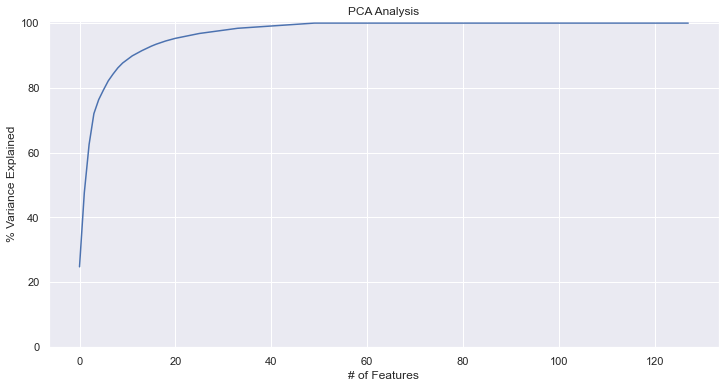

best_pca_dimensions for 90 % Variance is:  12 Features



In [5]:
clustring_algorithms_results = []
faces = pd.DataFrame(faces)
face_encodings = faces['face_encoding'].tolist()
best_pca_dimensions = get_best_pca_dimensions(face_encodings)
pca_df_all_data, pca_df = create_pca(faces, face_encodings, best_pca_dimensions)

In [6]:
faces

face_encoding  \
0    [-1.1912599, -0.8228302, -0.40031707, -1.63635...   
1    [-1.2779435, -0.87038517, -0.37021828, -1.7669...   
2    [-1.0201672, -0.60240805, -0.6928619, -1.40743...   
3    [-1.1640614, -0.59016705, -0.5768476, -1.29468...   
4    [-0.95789826, -0.18442962, -0.9021818, -1.3385...   
..                                                 ...   
295  [-1.4184235, -0.6505166, -0.9390658, -0.624670...   
296  [-1.1496332, -0.26877365, -0.20659196, -0.3247...   
297  [-1.4349687, -0.41537136, -1.2884346, -0.72868...   
298  [-1.1718473, -0.62041783, -0.26983872, -0.1617...   
299  [-1.4955709, -0.22267507, -0.7278122, -0.97136...   

              face_location image_path  
0     [1222, 50, 1525, 432]  video.mp4  
1     [1249, 52, 1546, 434]  video.mp4  
2     [1250, 22, 1562, 430]  video.mp4  
3     [1299, 11, 1629, 441]  video.mp4  
4     [1324, 19, 1654, 440]  video.mp4  
..                      ...        ...  
295  [1533, 452, 1830, 870]  video.mp4  
296    [737, 590, 985, 918]  video.mp4  
297  [1537, 469, 1833, 889]  video.mp4  
298   [779, 621, 1003, 923]  video.mp4  
299  [1546, 474, 1844, 901]  video.mp4  

[300 rows x 3 columns]

In [7]:
pca_df.head(10)

0         1         2         3         4          5         6   \
0  6.632051  5.462099 -5.114827 -0.721870 -0.420408  -0.581613 -1.126621   
1  7.063499  5.764046 -4.736115 -0.788277  0.005537  -0.777543 -1.780529   
2  7.209326  6.061231 -4.227365 -0.543843 -0.343146  -0.501081 -1.911965   
3  7.631540  5.803324 -4.597648 -0.728529 -0.956847   0.268161 -1.769117   
4  7.703223  5.364998 -4.360388 -1.022363 -0.997751   0.583872 -1.171742   
5  7.628506  4.863581 -3.849565 -1.537682 -0.855728   0.148452 -1.025853   
6  6.933752  5.416652 -4.739520 -0.321093 -0.706659  -0.550434 -1.240540   
7  3.956941 -3.253599  3.965481  1.705531 -1.897862   9.600417  1.613751   
8  3.534425 -3.273304  3.703535  1.947101 -1.347885   9.847428  1.660205   
9  3.180732 -1.827404  2.871335  2.154563 -1.573911  10.384267  1.257343   

         7         8         9         10        11  
0 -0.311334 -1.596250 -1.181629  1.237681 -2.154640  
1 -0.315537 -1.299415 -1.275315  1.460270 -2.071229  
2 -0.314760 -0.921060 -1.292680  1.264362 -1.965599  
3 -0.682694 -0.840343 -1.317338  1.162375 -1.268344  
4 -0.946971 -1.261848 -1.638705  0.530497 -1.634429  
5 -0.004170 -1.264347 -1.966710  0.326345 -1.691318  
6 -0.712841 -0.991507 -2.131953  1.166796 -0.688864  
7  0.244367  1.317958 -0.053662  1.574837 -0.986045  
8  0.533434  0.843553  0.145402  1.386519 -1.017408  
9  0.042798  1.825613  0.592592  2.141253 -0.442133

In [8]:
pca_df_all_data.head(10)

face_location image_path  \
0   [1222, 50, 1525, 432]  video.mp4   
1   [1249, 52, 1546, 434]  video.mp4   
2   [1250, 22, 1562, 430]  video.mp4   
3   [1299, 11, 1629, 441]  video.mp4   
4   [1324, 19, 1654, 440]  video.mp4   
5   [1367, 30, 1675, 423]  video.mp4   
6   [1418, 32, 1747, 431]  video.mp4   
7  [2957, 258, 3364, 777]  video.mp4   
8  [2996, 282, 3406, 810]  video.mp4   
9  [3143, 328, 3552, 874]  video.mp4   

                                      face_encodings  
0  [-1.1912599, -0.8228302, -0.40031707, -1.63635...  
1  [-1.2779435, -0.87038517, -0.37021828, -1.7669...  
2  [-1.0201672, -0.60240805, -0.6928619, -1.40743...  
3  [-1.1640614, -0.59016705, -0.5768476, -1.29468...  
4  [-0.95789826, -0.18442962, -0.9021818, -1.3385...  
5  [-1.3983204, -0.581247, -0.74171174, -1.205270...  
6  [-1.4254541, -0.5838759, -0.5488362, -1.090055...  
7  [0.048062377, -0.5501151, -1.0377924, 0.110354...  
8  [0.5444144, -0.22423716, -1.5393554, 0.1495253...  
9  [0.010228589, -0.39886296, -1.2394885, 0.07075...

## Perform the clustering of the embedding vectors

### K Means Algorithm

####       K Means Algorithm & Elbow Rule

K means is a quite simple unsupervised machine learning algorithm. It works as follows:

1. We define k, which is the number of clusters
2. The algorithm selects randomly k-points of the dataset and use them as initial centroids
3. The algorithm calculates the distance (we have to define a metric, a proximity measure) between the k centroids
   and all the other points of the dataset.
4. Each point is assigned to the cluster, in which it has the smallest distance from the controid
5. Reassignes the centroids.
6. The algorith stops when the centroids do not change any more.

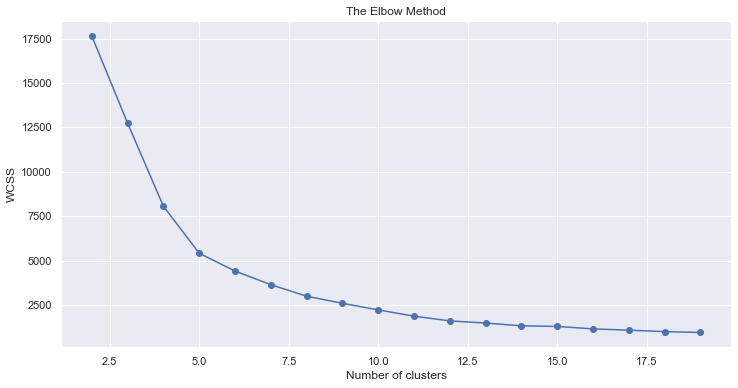

In [9]:
wcss = []
end_index =  20
for i in range(2, end_index):
    kmeans = KMeans(n_clusters = i, random_state = 10)
    kmeans.fit(pca_df.iloc[:,:-1])
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(12,6))
plt.plot(range(2, end_index), wcss, marker = 'o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

####  Using Silhouette analysis & Kmeans algorithm to find the ideal no. of clusters for the data

In [10]:
def get_best_num_of_clusters(data, start_index, end_index):

    print("\n-------------------- get_best_num_of_clusters --------------------\n")
    print(start_index,end_index)
    range_n_clusters = range(start_index,end_index)
    print(range_n_clusters)

    sil = []

    for num_of_clusters in range_n_clusters:

        clusterer = KMeans(n_clusters = num_of_clusters, random_state = 10)
        clusterer_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, clusterer_labels)
        if(silhouette_avg < 0.1):
            break
        sil.append(silhouette_avg)
        print("For n_clusters =", num_of_clusters, "The average silhouette_score :", silhouette_avg)

    ind = np.argmax(sil) + 2
    print("best_n_clusters: ", ind)   
    silhouette_max = np.amax(sil)

    return ind, silhouette_max

In [11]:
def cluster_faces_with_kmeans(pca_df_all_data, pca_df):
    
    best_n_clusters, silhouette_max = get_best_num_of_clusters(pca_df, 2, 30)
    clusterer = KMeans(n_clusters = best_n_clusters, random_state = 10)
    clusterer_labels = clusterer.fit_predict(pca_df)
    
    pca_df_all_data['cluster'] = clusterer_labels
    
    clustring_algorithms_results.append({"Name": "KMEANS", "silhouette_score": silhouette_max, "num_of_clusters": best_n_clusters})
    
    return pca_df_all_data, pca_df, silhouette_max
    

In [12]:
pca_df_all_data, pca_df, kmeans_sil_score = cluster_faces_with_kmeans(pca_df_all_data, pca_df)


-------------------- get_best_num_of_clusters --------------------

2 30
range(2, 30)
For n_clusters = 2 The average silhouette_score : 0.3223028792830674
For n_clusters = 3 The average silhouette_score : 0.3918840984147179
For n_clusters = 4 The average silhouette_score : 0.4989712613928893
For n_clusters = 5 The average silhouette_score : 0.5688438883271825
For n_clusters = 6 The average silhouette_score : 0.5469308538750911
For n_clusters = 7 The average silhouette_score : 0.5692125226472173
For n_clusters = 8 The average silhouette_score : 0.5462788000857761
For n_clusters = 9 The average silhouette_score : 0.5299158351939016
For n_clusters = 10 The average silhouette_score : 0.5434153292406267
For n_clusters = 11 The average silhouette_score : 0.5582339818637411
For n_clusters = 12 The average silhouette_score : 0.5764975365458453
For n_clusters = 13 The average silhouette_score : 0.5335035672772298
For n_clusters = 14 The average silhouette_score : 0.498136775839143
For n_cluste

In [13]:
pca_df_all_data.head()

face_location image_path  \
0  [1222, 50, 1525, 432]  video.mp4   
1  [1249, 52, 1546, 434]  video.mp4   
2  [1250, 22, 1562, 430]  video.mp4   
3  [1299, 11, 1629, 441]  video.mp4   
4  [1324, 19, 1654, 440]  video.mp4   

                                      face_encodings  cluster  
0  [-1.1912599, -0.8228302, -0.40031707, -1.63635...        3  
1  [-1.2779435, -0.87038517, -0.37021828, -1.7669...        3  
2  [-1.0201672, -0.60240805, -0.6928619, -1.40743...        3  
3  [-1.1640614, -0.59016705, -0.5768476, -1.29468...        3  
4  [-0.95789826, -0.18442962, -0.9021818, -1.3385...        3

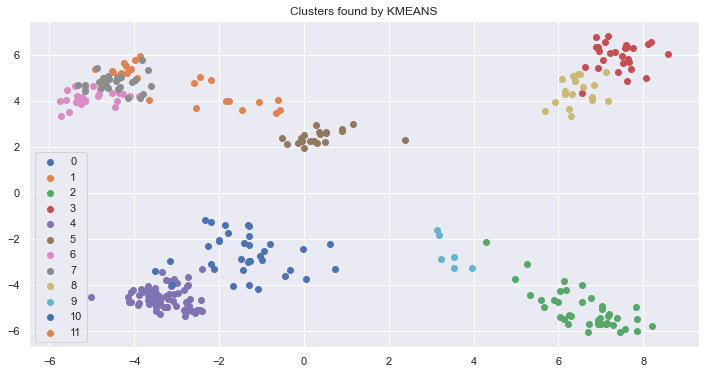

In [14]:
plot_clusters(pca_df, pca_df_all_data['cluster'], "KMEANS")

### DBSCAN Algorithm

In order to understand how DBSCAN works, we have to define the following:

* **minPts**: minimun number of points (neighbors) that must exist within a circe of
  radius eps and center a specific point in order to classify it as core point.

* **eps**: defines the radius of neighborhood around a point x.

We classify all the points of a dataset as:

1. **core point**: if there are at least **MinPts** points within a circle of radius **eps**.
2. **border point**: if it contains at least 1 core point in its neighbor.
3. **noise point**: if it is neither a core point nor a border point.

##### DBSCAN Algorithm (simplified)
1. Scan the database.
2. Assign each point to one of the following categories: core point, border point or noise.
3. Reject all the noise points.
4. Connect all the core points within a distance ε and create a separate cluster.
5. Assign each border point to the cluster which is reachable from a core point.

#### Determine Optimal Epsilon And MinPts Values

**Approach #1 - Nearest Neighbors Approach - Using Euclidean distance method to find optimum epsilon distance(eps)**

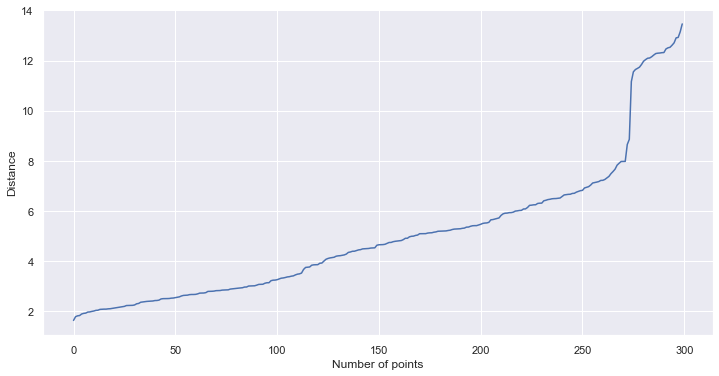

In [15]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=best_pca_dimensions * 2)
nbrs = neigh.fit(pca_df)
distances, indices = nbrs.kneighbors(pca_df)
distances = np.sort(distances[:,-1], axis = 0)
plt.figure(figsize=(12,6))
plt.plot(distances)
plt.xlabel('Number of points')
plt.ylabel('Distance')
plt.show()

**Approach #2 - Iteration Approach - Silhouette_score**

In [16]:
def plot_dbscan_parameters(all_dbscan_results_df):
    
    top = all_dbscan_results_df.nlargest(10, 'silhouette_score')
    
    fig, axs = plt.subplots(2, 2, figsize=(20,15))   
    
    x_data = ["({} , {})".format(eps,minPts) for eps,minPts in zip(top.minimum_points, top.epsilon_values)]
    axs[0,0].scatter(x_data, top.silhouette_score, color="#246EB9")
    axs[0,0].set_title("top 10 - (eps,minPts) vs silhouette_score")
    axs[0,0].set_ylim(0, 0.7)
    
    axs[0,1].bar(all_dbscan_results_df.minimum_points, all_dbscan_results_df.silhouette_score, color="#246EB9")
    axs[0,1].set_title("minimum_points vs silhouette_score")
    axs[0,1].set_ylim(0, 0.7)
    axs[0,1].set_xticks(np.arange(all_dbscan_results_df.minimum_points.min(), all_dbscan_results_df.minimum_points.max(), 1))
    
#     plt.xticks(np.arange(all_dbscan_results_df.minimum_points.min(), all_dbscan_results_df.minimum_points.max(), 1))
            
    axs[1,0].bar(all_dbscan_results_df.epsilon_values, all_dbscan_results_df.silhouette_score, color="#246EB9", width=0.3)
    axs[1,0].set_title("epsilon_values vs silhouette_score")
    axs[1,0].set_ylim(0, 0.7)
    axs[1,0].set_xticks(np.arange(all_dbscan_results_df.epsilon_values.min(), all_dbscan_results_df.epsilon_values.max(), 0.5))
    
      
    axs[1,1].bar(all_dbscan_results_df.no_of_clusters, all_dbscan_results_df.silhouette_score, color="#246EB9")
    axs[1,1].set_title("no_of_clusters vs silhouette_score")
    axs[1,1].set_ylim(0, 0.7)
    axs[1,1].set_xticks(np.arange(all_dbscan_results_df.no_of_clusters.min(), all_dbscan_results_df.no_of_clusters.max(), 1))

def get_optimal_parameters(data, eps_start_index, eps_end_index, eps_step, min_pts_start_index, min_pts_end_index):
      
    no_of_clusters = []
    sil_scores = []
    eps_values = []
    min_pts_values = []
    
    for eps in np.arange(eps_start_index,eps_end_index, eps_step):
        for min_pts in np.arange(min_pts_start_index, min_pts_end_index):
            
            labels, sil_score = start_dbscan(data,eps=eps, min_samples=min_pts)
                
            if sil_score is not None:
                eps_values.append(eps)
                min_pts_values.append(min_pts)
                no_of_clusters.append(len(np.unique(labels)))
                sil_scores.append(sil_score)
        
    all_dbscan_results = list(zip(no_of_clusters, sil_scores, eps_values, min_pts_values))
    all_dbscan_results_df = pd.DataFrame(all_dbscan_results, columns=['no_of_clusters', 'silhouette_score', 'epsilon_values', 'minimum_points'])
    
    plot_dbscan_parameters(all_dbscan_results_df)
    
    maxValueIndex = np.nanmax(all_dbscan_results_df.silhouette_score.astype("float").idxmax())
    
    best_parameters = all_dbscan_results_df.iloc[maxValueIndex]
    
    return best_parameters.epsilon_values, best_parameters.minimum_points

In [17]:
def start_dbscan(data, eps = 0.5, min_samples = 5):

    # print(eps, min_samples)

    # creating DBSCAN object for clustering the encodings with the metric "euclidean"
    dbscan_model = DBSCAN( eps = eps, min_samples = min_samples, n_jobs = 2, metric = "euclidean")

    # train the model
    dbscan_model.fit(data)

    labels = dbscan_model.labels_

    # determine the total number of unique faces found in the dataset
    # clt.labels_ contains the label ID for all faces in our dataset (i.e., which cluster each face belongs to).
    # To find the unique faces/unique label IDs, used NumPy’s unique function.
    # The result is a list of unique labelIDs
    label_ids = np.unique(dbscan_model.labels_)

    # we count the numUniqueFaces . There could potentially be a value of -1 in labelIDs — this value corresponds
    # to the “outlier” class where a 128-d embedding was too far away from any other clusters to be added to it.
    # “outliers” could either be worth examining or simply discarding based on the application of face clustering.
    num_unique_faces = len(np.where(label_ids > -1)[0])

    # print("[INFO] # unique faces: {}".format(num_unique_faces))

    n_noise_ = list(dbscan_model.labels_).count(-1)

    # print('Estimated number of noise points: %d' % n_noise_)

    if num_unique_faces > 1:
        sil_score = silhouette_score(data, labels)
        # print("Silhouette Coefficient: %0.3f" % sil_score)
        return labels, sil_score

    return labels , None

In [18]:
def cluster_faces_with_db_scan(pca_df_all_data, pca_df, best_pca_dimensions):
    
    eps_start_index = 1
    eps_end_index = 20
    eps_step = 0.5
    min_pts_start_index = 2
    min_pts_end_index = best_pca_dimensions * 2
    
    best_eps, best_min_samples = get_optimal_parameters(pca_df, eps_start_index, eps_end_index, eps_step, min_pts_start_index, min_pts_end_index)
    
    print("best_min_samples", best_min_samples, "best_eps", best_eps)
    
    # print("\n------------------------- start DBSCAN ------------------------------\n")

    labels, sil_score = start_dbscan(pca_df, eps = best_eps, min_samples = best_min_samples)
    pca_df_all_data['cluster'] = labels
    
    clustring_algorithms_results.append({"Name": "DBSCAN", "silhouette_score": sil_score, "num_of_clusters": len(np.unique(labels))})

    # print("\n------------------------- finish DBSCAN ------------------------------\n")

    return pca_df_all_data, pca_df,sil_score

best_min_samples 2.0 best_eps 6.0


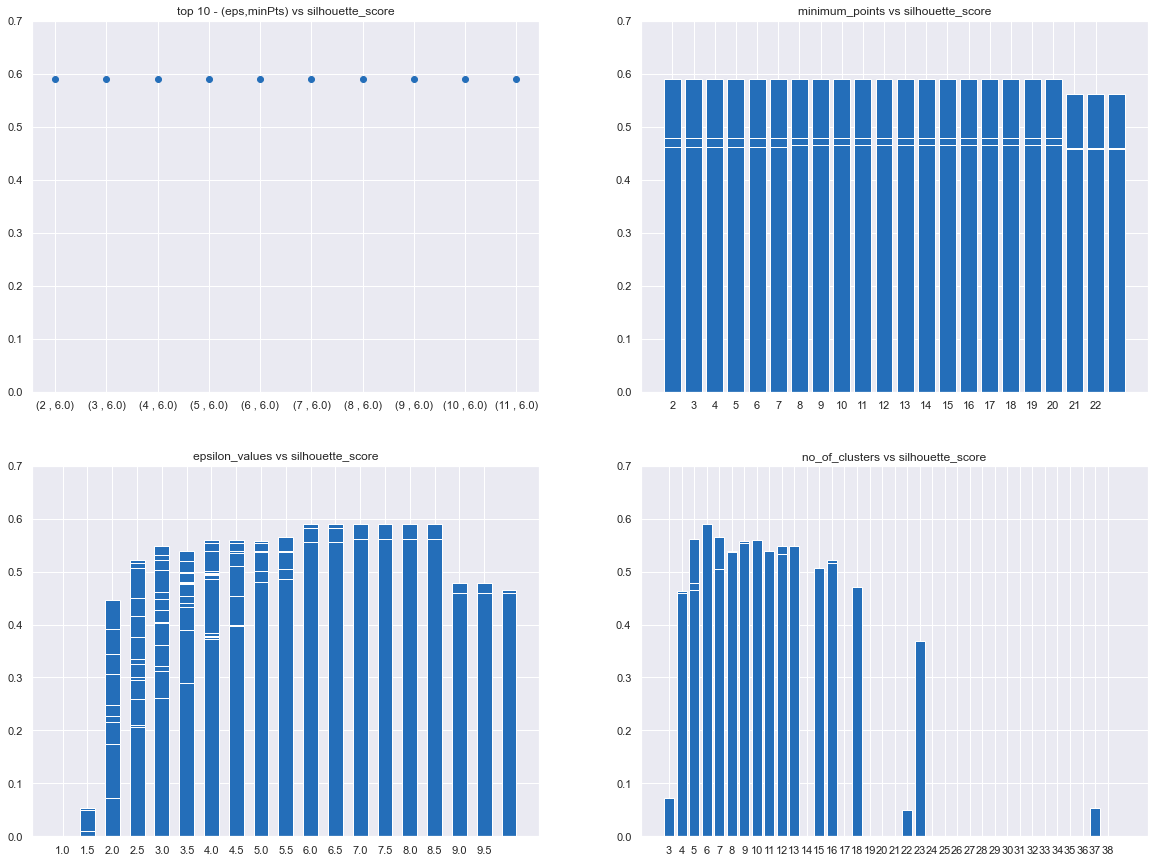

In [19]:
pca_df_all_data, pca_df, dbscan_sil_score = cluster_faces_with_db_scan(pca_df_all_data, pca_df, best_pca_dimensions)

In [20]:
pca_df_all_data

face_location image_path  \
0     [1222, 50, 1525, 432]  video.mp4   
1     [1249, 52, 1546, 434]  video.mp4   
2     [1250, 22, 1562, 430]  video.mp4   
3     [1299, 11, 1629, 441]  video.mp4   
4     [1324, 19, 1654, 440]  video.mp4   
..                      ...        ...   
295  [1533, 452, 1830, 870]  video.mp4   
296    [737, 590, 985, 918]  video.mp4   
297  [1537, 469, 1833, 889]  video.mp4   
298   [779, 621, 1003, 923]  video.mp4   
299  [1546, 474, 1844, 901]  video.mp4   

                                        face_encodings  cluster  
0    [-1.1912599, -0.8228302, -0.40031707, -1.63635...        0  
1    [-1.2779435, -0.87038517, -0.37021828, -1.7669...        0  
2    [-1.0201672, -0.60240805, -0.6928619, -1.40743...        0  
3    [-1.1640614, -0.59016705, -0.5768476, -1.29468...        0  
4    [-0.95789826, -0.18442962, -0.9021818, -1.3385...        0  
..                                                 ...      ...  
295  [-1.4184235, -0.6505166, -0.9390658, -0.624670...        0  
296  [-1.1496332, -0.26877365, -0.20659196, -0.3247...        5  
297  [-1.4349687, -0.41537136, -1.2884346, -0.72868...        0  
298  [-1.1718473, -0.62041783, -0.26983872, -0.1617...        5  
299  [-1.4955709, -0.22267507, -0.7278122, -0.97136...        0  

[300 rows x 4 columns]

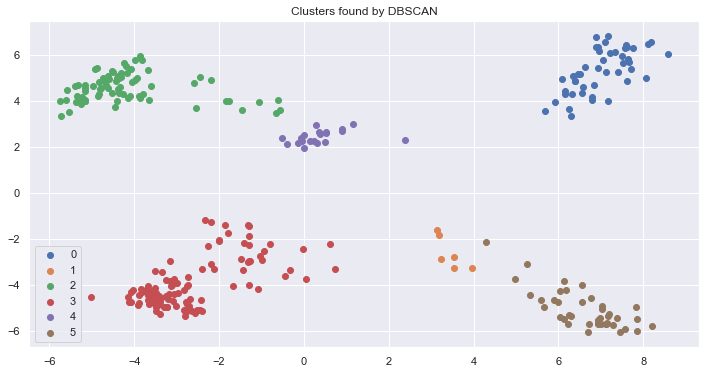

In [21]:
plot_clusters(pca_df, pca_df_all_data['cluster'], "DBSCAN")

In [22]:
print("DBSCAN silhouette_score :", dbscan_sil_score)
print("KMEANS silhouette_score :", kmeans_sil_score)

DBSCAN silhouette_score : 0.5893593940763328
KMEANS silhouette_score : 0.5764975365458453


### MeanShift clustering

In [23]:
from sklearn.cluster import estimate_bandwidth
def cluster_faces_with_meanshift(pca_df_all_data, pca_df):
    
    est_bandwidth = estimate_bandwidth(pca_df,quantile=.15,n_samples=10000)
    meanShift = MeanShift(bandwidth= est_bandwidth, bin_seeding=True)
    clusterer_labels = meanShift.fit_predict(pca_df)
    pca_df_all_data['cluster'] = clusterer_labels
    
    labels_unique=np.unique(clusterer_labels)
    n_clusters_=len(labels_unique)
    
    silh_score = 0
    
    if n_clusters_ > 1:
         silh_score = silhouette_score(pca_df, clusterer_labels)

    print("Number of estimated clusters : %d" % n_clusters_)
    
    clustring_algorithms_results.append({"Name": "MEANSHIFT", "silhouette_score": silh_score, "num_of_clusters": n_clusters_})
    
    return pca_df_all_data, pca_df, silh_score

In [24]:
pca_df_all_data, pca_df, meanshift_sil_score = cluster_faces_with_meanshift(pca_df_all_data, pca_df)

Number of estimated clusters : 6


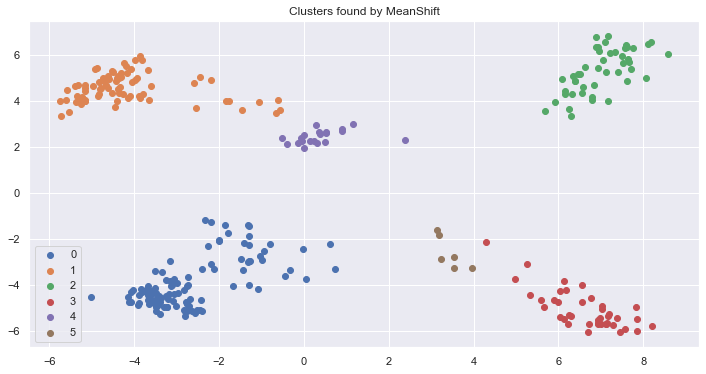

In [25]:
plot_clusters(pca_df, pca_df_all_data['cluster'], "MeanShift")

In [26]:
print("DBSCAN silhouette_score :", dbscan_sil_score)
print("KMEANS silhouette_score :", kmeans_sil_score)
print("MEANSHIFT silhouette_score :", meanshift_sil_score)

DBSCAN silhouette_score : 0.5893593940763328
KMEANS silhouette_score : 0.5764975365458453
MEANSHIFT silhouette_score : 0.5893593940763328


### Hierarchical Clustering

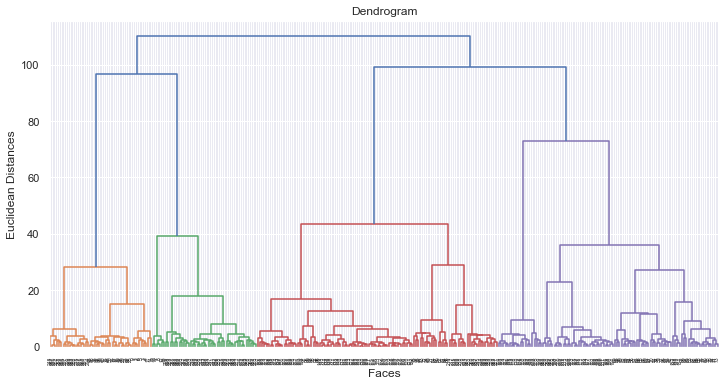

In [27]:
mergings = sch.linkage(pca_df, method = 'ward')
plt.figure(figsize=(12,6))
sch.dendrogram(mergings)
plt.title('Dendrogram')
plt.xlabel('Faces')
plt.ylabel('Euclidean Distances')
plt.show()

# By looking at this dendrogram, it can be seen that the optimal number of cluster is 5.
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
clusterer_labels = cluster.fit_predict(pca_df)
pca_df_all_data['cluster'] = clusterer_labels
hierarchical_sil_score = silhouette_score(pca_df, clusterer_labels, metric="euclidean")
clustring_algorithms_results.append({"Name": "HIERARCHICAL", "silhouette_score": hierarchical_sil_score, "num_of_clusters": 5})

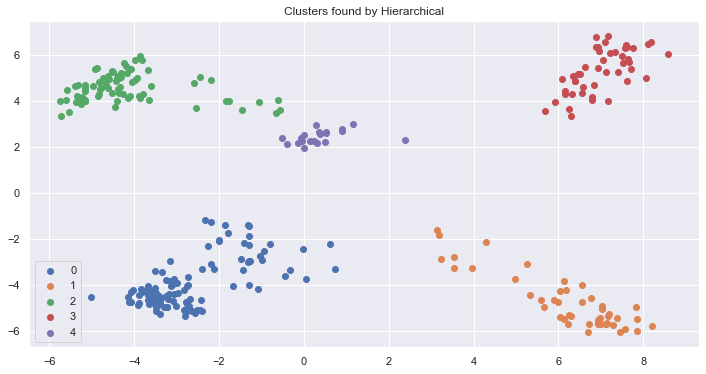

In [28]:
plot_clusters(pca_df, pca_df_all_data['cluster'], "Hierarchical")

In [29]:
print("DBSCAN silhouette_score :", dbscan_sil_score)
print("KMEANS silhouette_score :", kmeans_sil_score)
print("MEANSHIFT silhouette_score :", meanshift_sil_score)
print("HIERARCHICAL silhouette_score :", hierarchical_sil_score)

DBSCAN silhouette_score : 0.5893593940763328
KMEANS silhouette_score : 0.5764975365458453
MEANSHIFT silhouette_score : 0.5893593940763328
HIERARCHICAL silhouette_score : 0.5688438883271825


### GMM Clustering

In [30]:
from sklearn.mixture import GaussianMixture

def get_best_k_paramerter(data, start_index, end_index):

    k_range = range(start_index, end_index) 

    pca_no_of_clusters = []
    pca_sil_score = []
    pca_k_values = []

    for k in k_range:
        
        # Apply your clustering algorithm of choice to the data
        clusterer = GaussianMixture(n_components=k, random_state=10)
        labels = clusterer.fit_predict(data)
        pca_k_values.append(k)
        pca_no_of_clusters.append(len(np.unique(labels)))
        pca_sil_score.append(silhouette_score(data,labels))

    pca_k_array = list(zip(pca_no_of_clusters, pca_sil_score, pca_k_values))
    pca_k_df = pd.DataFrame(pca_k_array, columns=['no_of_clusters', 'silhouette_score', 'k_values'])
    
    plt.figure(figsize=(12,6))
    sns.lineplot(data=pca_k_df, x="k_values", y="silhouette_score")

    maxValueIndex = np.nanmax(pca_k_df.silhouette_score.idxmax())
    best_k = pca_k_df.iloc[maxValueIndex].k_values
    return int(best_k), pca_k_df.iloc[maxValueIndex].silhouette_score

def cluster_faces_with_GMM(pca_df_all_data, pca_df):
    
    k, silhouette_score_max = get_best_k_paramerter(pca_df, 2, best_pca_dimensions * 2)
    
    clusterer = GaussianMixture(n_components=k, random_state=10)
    clusterer_labels = clusterer.fit_predict(pca_df)
    
    pca_df_all_data['cluster'] = clusterer_labels
    
    print(silhouette_score_max, k)
    
    clustring_algorithms_results.append({"Name": "GMM", "silhouette_score": silhouette_score_max, "num_of_clusters": k})

    return pca_df_all_data, pca_df, silhouette_score_max

0.5688438883271825 5


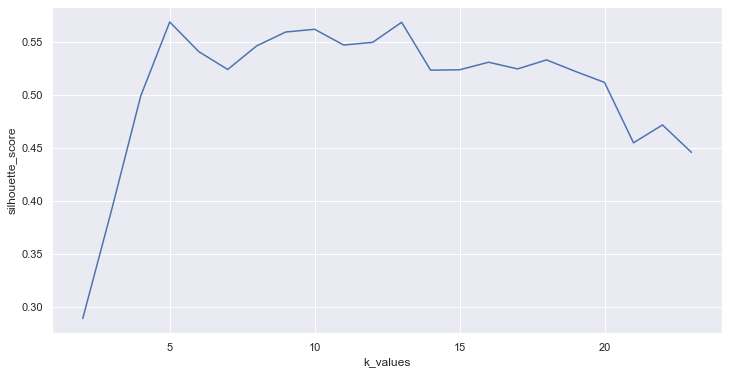

In [31]:
pca_df_all_data, pca_df, gmm_sil_score = cluster_faces_with_GMM(pca_df_all_data, pca_df)

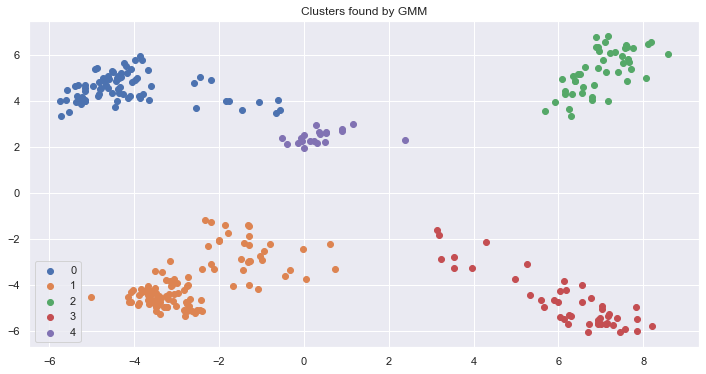

In [32]:
plot_clusters(pca_df, pca_df_all_data['cluster'], "GMM")

### Comparision of Results

In [33]:
print("DBSCAN silhouette_score :", dbscan_sil_score)
print("KMEANS silhouette_score :", kmeans_sil_score)
print("MEANSHIFT silhouette_score :", meanshift_sil_score)
print("HIERARCHICAL silhouette_score :", hierarchical_sil_score)
print("GMM silhouette_score :", gmm_sil_score)

DBSCAN silhouette_score : 0.5893593940763328
KMEANS silhouette_score : 0.5764975365458453
MEANSHIFT silhouette_score : 0.5893593940763328
HIERARCHICAL silhouette_score : 0.5688438883271825
GMM silhouette_score : 0.5688438883271825


In [34]:
clustring_algorithms_results = pd.DataFrame(clustring_algorithms_results)

In [35]:
clustring_algorithms_results

Name  silhouette_score  num_of_clusters
0        KMEANS          0.576498               12
1        DBSCAN          0.589359                6
2     MEANSHIFT          0.589359                6
3  HIERARCHICAL          0.568844                5
4           GMM          0.568844                5

### Realtime Process

In [37]:
from tensorflow_object_detection import DetectorAPI
from scipy.spatial import distance

object_threshold = 0.98
odapi = DetectorAPI()
vs = cv2.VideoCapture("video.mp4")
rec = []

def draw_faces(image, face):
    (x, y, x1, y1) = [ v for v in face["face_location"]]
    cv2.rectangle(image, (x, y), (x1, y1), (255, 0, 0), 9)
        
def get_person_id(face_encodings, unknown_face_encoding):
    
    face_distances = []
    
    for face_encoding in face_encodings:
        face_distances.append(np.linalg.norm(face_encoding-unknown_face_encoding))
    
    best_match_index = np.argmin(face_distances)
    best_match = pca_df_all_data.iloc[best_match_index]
    
    return best_match

def get_skeletons(image, image_w, image_h):
    skeletons, humans, scale_h = action_recognition.detect_skeletons(image)
    dict_id2skeleton = action_recognition.people_track(skeletons)
    dict_id2label = action_recognition.recognize_action(dict_id2skeleton)

    if(len(skeletons)==0):
        return None, None, None

    centers = []

    for i, human in enumerate(humans):

        allBodyPoints = []
        for i in range(0,18):

            if i not in human.body_parts:
                continue

            if human.body_parts[i].x > 0 and human.body_parts[i].y > 0 :
                pointX = int(human.body_parts[i].x * image_w)
                pointY = int(human.body_parts[i].y * image_h)
                # cv2.circle(frame, (pointX, pointY), radius=10, color=(255, i * 10, i * 5), thickness=15)
                allBodyPoints.append((pointX, pointY))

        center = np.mean(allBodyPoints, axis=0)
        center = (int(center[0]), int(center[1]))
        centers.append(center)
        
    return centers, dict_id2skeleton, dict_id2label,skeletons

def get_human_action(frame, humanCenter, centers, dict_id2skeleton, dict_id2label, skeletons):
        
        distances = []
        # cv2.circle(frame, humanCenter, radius=10, color=(0, 0, 255), thickness=15)
        
        for c in centers:
            dis = distance.euclidean(c, humanCenter)
        distances.append(dis)
        best_match_index = np.argmin(distances)
        best_match_skeleton = skeletons[best_match_index]
        
        id = -1
        for key, value in dict_id2skeleton.items():
            if (best_match_skeleton == value).all():
                id = key
                
        label = ''
        if id != -1:        
            label = dict_id2label[id]
                        
        return label

#Loop Video Stream   
while True:

    (grabbed, frame) = vs.read()

    if frame is None:
        break

    image = frame.copy()

    # Class 1 represents human
    persons = odapi.filter_detected_items(1, object_threshold, odapi, frame)
    
    # Visualization of the results of a detection.
    for person in persons:

        # Crop person from image
        y, x, y2, x2 = [ v for v in person["box"]]
        human = frame[y:y2, x:x2]

        # detect_faces
        faces = faceDetection.detect_faces(human, "video.mp4", 0.6)
        
        if(len(faces)==0):
            break
            
        face = faces[0]
        face_id = get_person_id(face_encodings, face["face_encoding"])
        image_w, image_h, _ = frame.shape
            
        centers, dict_id2skeleton, dict_id2label,skeletons = get_skeletons(frame, image_w, image_h)
        
        if centers is None:
            continue
        
        py, px, py2, px2 = [ v for v in face["face_location"]]
        faceCenter = ( int((px + px2) / 2) , int((py + py2) / 2))
        
        label = get_human_action(frame, faceCenter, centers, dict_id2skeleton, dict_id2label, skeletons)
            
        date = time.asctime(time.localtime(time.time()))
        
        rec.append({"time": date, "cluster": face_id.cluster, "label": label})
        
        tr = cv2.resize(frame, (300, 300))
        cv2.imshow('camera2',tr) 
        

    key = cv2.waitKey(1) & 0xFF

    if key == ord('q'):
        break


cv2.destroyAllWindows()

[2021-03-10 10:32:31,590] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:31,590] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:32,171] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:32,171] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:32,183] [TfPoseEstimator] [DEBUG] estimate time=0.01098
[2021-03-10 10:32:32,183] [TfPoseEstimator] [DEBUG] estimate time=0.01098
[2021-03-10 10:32:32,185] [TfPoseEstimator] [INFO] inference image in 0.5954 seconds.
[2021-03-10 10:32:32,185] [TfPoseEstimator] [INFO] inference image in 0.5954 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 0
num_valid_joints 14 num_face_joints 3
num_valid_joints 13 num_face_joints 3


[2021-03-10 10:32:32,393] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:32,393] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:32,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:32,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:32,975] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:32:32,975] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:32:32,977] [TfPoseEstimator] [INFO] inference image in 0.5834 seconds.
[2021-03-10 10:32:32,977] [TfPoseEstimator] [INFO] inference image in 0.5834 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 0
num_valid_joints 14 num_face_joints 3
num_valid_joints 13 num_face_joints 3


[2021-03-10 10:32:33,985] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:33,985] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:34,533] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:34,533] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:34,541] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-10 10:32:34,541] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-10 10:32:34,543] [TfPoseEstimator] [INFO] inference image in 0.5575 seconds.
[2021-03-10 10:32:34,543] [TfPoseEstimator] [INFO] inference image in 0.5575 seconds.
[2021-03-10 10:32:34,659] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:34,659] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 10 num_face_joints 0
num_valid_joints 14 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 4 num_face_joints 1


[2021-03-10 10:32:35,236] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:35,236] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:35,246] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:32:35,246] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:32:35,249] [TfPoseEstimator] [INFO] inference image in 0.5894 seconds.
[2021-03-10 10:32:35,249] [TfPoseEstimator] [INFO] inference image in 0.5894 seconds.


len humans 4
len skeletons 4
num_valid_joints 10 num_face_joints 0
num_valid_joints 14 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 4 num_face_joints 1

Mean score:
 [5.40732087e-32 3.26351141e-10 2.40235937e-07 2.15011372e-09
 1.66696797e-10 3.96255391e-09 9.99995841e-01 3.91241823e-06
 1.51962271e-17]

Mean score:
 [2.51318019e-30 3.42029148e-11 1.09500480e-08 3.66391433e-11
 9.32847313e-07 1.50312958e-06 9.99978047e-01 1.95057058e-05
 1.18245685e-15]


[2021-03-10 10:32:36,306] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:36,306] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:36,890] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:36,890] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:36,900] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:32:36,900] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:32:36,903] [TfPoseEstimator] [INFO] inference image in 0.5969 seconds.
[2021-03-10 10:32:36,903] [TfPoseEstimator] [INFO] inference image in 0.5969 seconds.


len humans 4
len skeletons 4
num_valid_joints 10 num_face_joints 0
num_valid_joints 15 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 4 num_face_joints 0

Mean score:
 [9.33398609e-23 1.71853778e-02 1.61441545e-06 7.01862624e-04
 8.34324801e-11 4.52716680e-09 9.09970165e-01 7.21409656e-02
 1.02964577e-08]

Mean score:
 [7.79787518e-24 9.11908058e-10 5.48435158e-09 1.83233225e-11
 4.66491777e-07 7.51565367e-07 9.99989010e-01 9.76560493e-06
 6.61205065e-14]


[2021-03-10 10:32:37,939] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:37,939] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:38,492] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:38,492] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:38,497] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:32:38,497] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:32:38,499] [TfPoseEstimator] [INFO] inference image in 0.5596 seconds.
[2021-03-10 10:32:38,499] [TfPoseEstimator] [INFO] inference image in 0.5596 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 0
num_valid_joints 14 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 4 num_face_joints 1

Mean score:
 [9.33398617e-23 1.71854104e-02 1.49586529e-06 7.19786118e-04
 8.54731776e-14 2.25438827e-08 4.59141841e-01 5.22951434e-01
 1.02999976e-08]

Mean score:
 [7.79787394e-24 9.01666045e-10 1.79952851e-11 2.06740087e-13
 7.15356162e-11 3.47829840e-11 9.99999974e-01 2.47412873e-08
 6.56531280e-14]


[2021-03-10 10:32:39,519] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:39,519] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:40,061] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:40,061] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:40,068] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:32:40,068] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:32:40,070] [TfPoseEstimator] [INFO] inference image in 0.5505 seconds.
[2021-03-10 10:32:40,070] [TfPoseEstimator] [INFO] inference image in 0.5505 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 4 num_face_joints 1

Mean score:
 [8.02281787e-31 5.86511457e-08 5.83928699e-05 1.81009726e-05
 1.70131321e-12 3.04061620e-08 5.49110984e-01 4.50812434e-01
 3.53991240e-12]

Mean score:
 [1.07218256e-32 6.85944411e-12 8.66770524e-12 2.02989719e-13
 3.41506532e-12 3.42051379e-11 9.99999988e-01 1.19892777e-08
 1.23849908e-16]


[2021-03-10 10:32:41,060] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:41,060] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:41,614] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:41,614] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:41,619] [TfPoseEstimator] [DEBUG] estimate time=0.00401
[2021-03-10 10:32:41,619] [TfPoseEstimator] [DEBUG] estimate time=0.00401
[2021-03-10 10:32:41,620] [TfPoseEstimator] [INFO] inference image in 0.5605 seconds.
[2021-03-10 10:32:41,620] [TfPoseEstimator] [INFO] inference image in 0.5605 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 4 num_face_joints 1

Mean score:
 [1.56415165e-30 4.13078948e-08 5.97526857e-05 3.47535504e-07
 2.33638986e-10 1.63017764e-08 9.99939215e-01 6.27291482e-07
 6.38986373e-15]

Mean score:
 [1.96778285e-57 1.71638716e-19 1.25654845e-17 5.80069897e-19
 1.68289877e-20 7.33490593e-18 1.00000000e+00 5.16879503e-15
 1.63031937e-25]


[2021-03-10 10:32:42,712] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:42,712] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:43,260] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:43,260] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:43,269] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:32:43,269] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:32:43,271] [TfPoseEstimator] [INFO] inference image in 0.5585 seconds.
[2021-03-10 10:32:43,271] [TfPoseEstimator] [INFO] inference image in 0.5585 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 4 num_face_joints 1

Mean score:
 [4.93881585e-24 2.78853322e-06 5.90060880e-04 1.21882917e-06
 6.66501132e-05 2.69411333e-07 9.99338158e-01 8.53821261e-07
 1.72579366e-14]

Mean score:
 [2.59769830e-52 1.69531791e-19 7.12668559e-11 3.82769781e-17
 2.14626771e-14 4.59478991e-11 1.00000000e+00 5.98074849e-15
 1.67823951e-25]


[2021-03-10 10:32:44,286] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:44,286] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:44,847] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:44,847] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:44,854] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-10 10:32:44,854] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-10 10:32:44,856] [TfPoseEstimator] [INFO] inference image in 0.5695 seconds.
[2021-03-10 10:32:44,856] [TfPoseEstimator] [INFO] inference image in 0.5695 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 0
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 7 num_face_joints 2

Mean score:
 [9.44645627e-24 2.80722573e-06 8.35034942e-04 1.13827015e-06
 1.83709431e-02 3.58156988e-05 9.80691971e-01 6.22894763e-05
 5.11564624e-14]

Mean score:
 [2.59767873e-52 1.26543210e-21 7.12668678e-11 3.82760971e-17
 2.14626647e-14 4.59479418e-11 1.00000000e+00 1.96168555e-15
 1.50939966e-24]


[2021-03-10 10:32:45,922] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:45,922] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:46,522] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:46,522] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:46,529] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:32:46,529] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:32:46,531] [TfPoseEstimator] [INFO] inference image in 0.6094 seconds.
[2021-03-10 10:32:46,531] [TfPoseEstimator] [INFO] inference image in 0.6094 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 0
num_valid_joints 12 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 6 num_face_joints 2

Mean score:
 [4.50882389e-24 3.43293556e-08 1.23656427e-03 9.23425581e-08
 1.70182571e-01 4.69612974e-05 8.28471666e-01 6.21101606e-05
 4.02932687e-14]

Mean score:
 [1.12602724e-59 1.08321511e-21 2.18304621e-17 7.52176449e-20
 5.54322640e-21 5.00648616e-17 1.00000000e+00 1.14852739e-15
 1.50425257e-24]


[2021-03-10 10:32:51,457] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:51,457] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:52,052] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:52,052] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:52,064] [TfPoseEstimator] [DEBUG] estimate time=0.00997
[2021-03-10 10:32:52,064] [TfPoseEstimator] [DEBUG] estimate time=0.00997
[2021-03-10 10:32:52,066] [TfPoseEstimator] [INFO] inference image in 0.6094 seconds.
[2021-03-10 10:32:52,066] [TfPoseEstimator] [INFO] inference image in 0.6094 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 0
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [1.18190446e-27 5.71751264e-04 9.90375409e-04 3.74148959e-01
 1.51878278e-01 1.14095820e-05 4.68452213e-01 3.94701327e-03
 2.80529166e-11]

Mean score:
 [1.89686988e-51 2.28903509e-18 9.37313541e-14 5.90971287e-17
 1.01714372e-15 3.49002566e-14 1.00000000e+00 1.55108189e-14
 1.16430144e-26]


[2021-03-10 10:32:53,205] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:53,205] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:53,815] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:53,815] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:53,825] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-10 10:32:53,825] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-10 10:32:53,829] [TfPoseEstimator] [INFO] inference image in 0.6233 seconds.
[2021-03-10 10:32:53,829] [TfPoseEstimator] [INFO] inference image in 0.6233 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 0
num_valid_joints 9 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [3.29841257e-48 3.20872939e-17 9.37280882e-14 9.54255515e-17
 1.01732823e-15 3.51832676e-14 1.00000000e+00 3.91765772e-10
 2.29686835e-21]


[2021-03-10 10:32:54,993] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:54,993] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:55,600] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:55,600] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:55,609] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:32:55,609] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:32:55,612] [TfPoseEstimator] [INFO] inference image in 0.6193 seconds.
[2021-03-10 10:32:55,612] [TfPoseEstimator] [INFO] inference image in 0.6193 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [3.29652250e-48 3.45866251e-17 4.59635750e-17 1.58956324e-16
 2.14833916e-19 4.85049926e-15 9.99999999e-01 8.87175513e-10
 3.07079910e-21]

Mean score:
 [3.53876222e-09 9.99998035e-01 6.05374504e-07 5.66217309e-09
 1.01495683e-10 6.42091637e-14 1.34569574e-06 2.29271679e-09
 2.69420303e-09]


[2021-03-10 10:32:56,602] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:56,602] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:57,151] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:57,151] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:57,156] [TfPoseEstimator] [DEBUG] estimate time=0.00300
[2021-03-10 10:32:57,156] [TfPoseEstimator] [DEBUG] estimate time=0.00300
[2021-03-10 10:32:57,158] [TfPoseEstimator] [INFO] inference image in 0.5555 seconds.
[2021-03-10 10:32:57,158] [TfPoseEstimator] [INFO] inference image in 0.5555 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 0
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [6.80624795e-54 4.84285776e-18 1.51294618e-16 1.32246652e-16
 3.23234642e-20 6.81200097e-15 1.00000000e+00 4.96441647e-10
 7.74386941e-22]

Mean score:
 [4.35985504e-06 9.99992444e-01 1.78805845e-06 7.33857092e-09
 1.46085082e-08 1.01493164e-12 1.36616274e-06 9.81958543e-09
 1.04322145e-08]


[2021-03-10 10:32:58,241] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:58,241] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:58,859] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:58,859] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:32:58,866] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:32:58,866] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:32:58,868] [TfPoseEstimator] [INFO] inference image in 0.6273 seconds.
[2021-03-10 10:32:58,868] [TfPoseEstimator] [INFO] inference image in 0.6273 seconds.


len humans 4
len skeletons 4
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 0
num_valid_joints 9 num_face_joints 3

Mean score:
 [4.94693799e-57 2.46136967e-19 3.35443943e-16 3.31410323e-16
 3.19846658e-19 1.08275599e-13 1.00000000e+00 3.60841164e-10
 3.66575049e-24]

Mean score:
 [3.15206529e-05 9.99965001e-01 2.31778370e-06 1.21474459e-08
 2.12255755e-08 2.30550808e-12 1.02867487e-06 4.79081079e-08
 5.04537410e-08]


[2021-03-10 10:32:59,909] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:32:59,909] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:00,518] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:00,518] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:00,523] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:33:00,523] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:33:00,525] [TfPoseEstimator] [INFO] inference image in 0.6154 seconds.
[2021-03-10 10:33:00,525] [TfPoseEstimator] [INFO] inference image in 0.6154 seconds.


len humans 4
len skeletons 4
num_valid_joints 10 num_face_joints 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 12 num_face_joints 3
num_valid_joints 7 num_face_joints 2

Mean score:
 [6.94392293e-57 3.07058720e-19 2.42168169e-16 3.69131384e-16
 3.34359369e-19 1.22630166e-13 9.99999999e-01 6.58410730e-10
 1.77357623e-23]

Mean score:
 [2.93344831e-05 9.99965625e-01 1.40361123e-06 2.06389235e-07
 9.29371144e-09 1.51018275e-11 9.81760661e-07 2.13040578e-06
 3.08637858e-07]


[2021-03-10 10:33:01,658] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:01,658] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:02,279] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:02,279] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:02,285] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:33:02,285] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:33:02,288] [TfPoseEstimator] [INFO] inference image in 0.6303 seconds.
[2021-03-10 10:33:02,288] [TfPoseEstimator] [INFO] inference image in 0.6303 seconds.
[2021-03-10 10:33:02,405] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:02,405] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 10 num_face_joints 0
num_valid_joints 10 num_face_joints 3
num_valid_joints 7 num_face_joints 2
num_valid_joints 13 num_face_joints 3

Mean score:
 [1.36484727e-56 3.16163139e-19 3.05879762e-17 2.87489546e-16
 6.03861781e-20 6.76356149e-14 9.99999995e-01 5.12888823e-09
 9.76866952e-23]

Mean score:
 [2.39141415e-06 9.99980252e-01 2.24667002e-06 2.06742782e-07
 1.33751202e-08 1.51720141e-11 1.25184798e-05 2.09515189e-06
 2.75850207e-07]


[2021-03-10 10:33:03,002] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:03,002] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:03,008] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:33:03,008] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:33:03,010] [TfPoseEstimator] [INFO] inference image in 0.6054 seconds.
[2021-03-10 10:33:03,010] [TfPoseEstimator] [INFO] inference image in 0.6054 seconds.


len humans 4
len skeletons 4
num_valid_joints 10 num_face_joints 0
num_valid_joints 10 num_face_joints 3
num_valid_joints 7 num_face_joints 2
num_valid_joints 13 num_face_joints 3

Mean score:
 [1.26754000e-56 1.76547637e-18 2.02183501e-16 5.57768666e-16
 4.85621036e-20 5.36918489e-14 9.99999995e-01 4.84641862e-09
 8.40179905e-23]

Mean score:
 [2.19577518e-07 5.43535662e-01 6.44401925e-06 5.71374839e-05
 5.60882896e-08 6.26164486e-07 8.43235731e-02 3.71643049e-01
 4.33232447e-04]


[2021-03-10 10:33:04,090] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:04,090] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:04,684] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:04,684] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:04,689] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:33:04,689] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:33:04,691] [TfPoseEstimator] [INFO] inference image in 0.6004 seconds.
[2021-03-10 10:33:04,691] [TfPoseEstimator] [INFO] inference image in 0.6004 seconds.
[2021-03-10 10:33:04,807] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:04,807] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 0
num_valid_joints 10 num_face_joints 3
num_valid_joints 6 num_face_joints 2
num_valid_joints 13 num_face_joints 3

Mean score:
 [2.93265854e-55 5.63650653e-18 1.04589819e-15 1.62752811e-15
 3.88604051e-19 6.27815248e-14 9.99999999e-01 5.08794666e-10
 3.11710908e-23]

Mean score:
 [8.22745196e-11 4.39506128e-02 4.79464765e-06 6.17481258e-05
 4.88509792e-08 6.72070103e-07 2.12307620e-01 7.40388800e-01
 3.28570342e-03]


[2021-03-10 10:33:05,445] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:05,445] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:05,450] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:33:05,450] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:33:05,453] [TfPoseEstimator] [INFO] inference image in 0.6453 seconds.
[2021-03-10 10:33:05,453] [TfPoseEstimator] [INFO] inference image in 0.6453 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 0
num_valid_joints 10 num_face_joints 3
num_valid_joints 6 num_face_joints 2
num_valid_joints 13 num_face_joints 3

Mean score:
 [1.77993045e-54 7.41589415e-18 4.79782727e-15 6.70205152e-15
 7.68373654e-18 4.62163120e-13 9.99999998e-01 1.58255564e-09
 4.98754013e-23]

Mean score:
 [6.94664436e-12 1.06230030e-03 2.63113511e-07 5.13357333e-06
 1.76788365e-07 5.93085183e-07 2.36522692e-01 7.59468967e-01
 2.93987422e-03]


[2021-03-10 10:33:06,403] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:06,403] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:06,950] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:06,950] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:06,956] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:33:06,956] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:33:06,959] [TfPoseEstimator] [INFO] inference image in 0.5555 seconds.
[2021-03-10 10:33:06,959] [TfPoseEstimator] [INFO] inference image in 0.5555 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 0
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 7 num_face_joints 3

Mean score:
 [3.08345640e-54 6.25414904e-18 7.45664906e-15 1.67887313e-14
 1.15289188e-17 6.42129977e-13 9.99999997e-01 2.54627822e-09
 3.37711370e-23]

Mean score:
 [4.66203673e-12 6.89229632e-04 2.56255753e-07 7.25895571e-07
 1.95903318e-07 8.76711558e-07 1.24528266e-01 8.74614112e-01
 1.66337640e-04]


[2021-03-10 10:33:08,004] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:08,004] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:08,613] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:08,613] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:08,620] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:33:08,620] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:33:08,622] [TfPoseEstimator] [INFO] inference image in 0.6183 seconds.
[2021-03-10 10:33:08,622] [TfPoseEstimator] [INFO] inference image in 0.6183 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 0
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 6 num_face_joints 2

Mean score:
 [1.66053089e-54 3.83518133e-18 4.50313934e-15 1.16233129e-14
 4.75243713e-18 2.71332354e-13 9.99999999e-01 1.49288470e-09
 1.68386209e-23]

Mean score:
 [1.40859949e-11 4.32670252e-04 1.22855292e-07 6.12250009e-07
 2.71975706e-07 7.44806084e-07 1.32874641e-01 8.66327984e-01
 3.62952599e-04]


[2021-03-10 10:33:09,753] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:09,753] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:10,427] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:10,427] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:10,434] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:33:10,434] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:33:10,437] [TfPoseEstimator] [INFO] inference image in 0.6842 seconds.
[2021-03-10 10:33:10,437] [TfPoseEstimator] [INFO] inference image in 0.6842 seconds.


len humans 4
len skeletons 4
num_valid_joints 9 num_face_joints 0
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 6 num_face_joints 2

Mean score:
 [6.48250232e-56 9.56502060e-19 1.01504125e-15 2.97702910e-16
 5.33731969e-19 4.23673047e-14 1.00000000e+00 1.83551137e-10
 4.51220691e-24]

Mean score:
 [2.68233078e-11 9.29980553e-04 6.40082737e-07 1.56872530e-06
 3.83613744e-07 1.83258504e-06 1.41611053e-01 8.57058901e-01
 3.95640372e-04]


[2021-03-10 10:33:11,524] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:11,524] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:12,135] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:12,135] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:12,141] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:33:12,141] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:33:12,143] [TfPoseEstimator] [INFO] inference image in 0.6183 seconds.
[2021-03-10 10:33:12,143] [TfPoseEstimator] [INFO] inference image in 0.6183 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 0
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 6 num_face_joints 2

Mean score:
 [4.59045800e-59 3.69276853e-20 3.47763511e-17 1.09953800e-16
 1.02563162e-20 1.75789865e-14 1.00000000e+00 2.41863054e-10
 2.63607237e-24]

Mean score:
 [7.13279702e-10 5.16559912e-03 1.93913436e-06 1.50534179e-06
 6.97664297e-05 4.53967830e-06 1.98766037e-01 7.95830574e-01
 1.60038493e-04]


[2021-03-10 10:33:13,182] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:13,182] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:13,771] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:13,771] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:13,776] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:33:13,776] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:33:13,778] [TfPoseEstimator] [INFO] inference image in 0.5964 seconds.
[2021-03-10 10:33:13,778] [TfPoseEstimator] [INFO] inference image in 0.5964 seconds.


len humans 3
len skeletons 3
num_valid_joints 11 num_face_joints 0
num_valid_joints 15 num_face_joints 3
num_valid_joints 11 num_face_joints 3

Mean score:
 [7.33746570e-59 6.96240729e-21 7.17318160e-18 3.90518645e-17
 1.12008809e-21 6.53312574e-15 1.00000000e+00 9.48535070e-11
 8.66651985e-25]

Mean score:
 [7.20467525e-10 6.74671738e-03 2.69763239e-06 6.96228106e-07
 4.54279088e-04 8.01108486e-06 5.00598463e-01 4.92135870e-01
 5.32651005e-05]


[2021-03-10 10:33:14,881] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:14,881] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:15,514] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:15,514] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:15,519] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:33:15,519] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:33:15,522] [TfPoseEstimator] [INFO] inference image in 0.6403 seconds.
[2021-03-10 10:33:15,522] [TfPoseEstimator] [INFO] inference image in 0.6403 seconds.


len humans 3
len skeletons 3
num_valid_joints 11 num_face_joints 0
num_valid_joints 11 num_face_joints 3
num_valid_joints 13 num_face_joints 3

Mean score:
 [8.44795764e-52 8.90985038e-21 1.25281582e-16 8.12715057e-20
 9.57896337e-17 1.86745752e-13 1.00000000e+00 9.66958688e-12
 1.55096371e-22]

Mean score:
 [2.06848466e-11 2.11111612e-03 1.29543910e-06 5.20435046e-07
 3.84654464e-04 4.93297564e-06 5.54057675e-01 4.43434750e-01
 5.05641781e-06]


[2021-03-10 10:33:16,650] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:16,650] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:17,269] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:17,269] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:17,277] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-10 10:33:17,277] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-10 10:33:17,279] [TfPoseEstimator] [INFO] inference image in 0.6293 seconds.
[2021-03-10 10:33:17,279] [TfPoseEstimator] [INFO] inference image in 0.6293 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [8.44795691e-52 4.78189022e-20 1.23083312e-16 4.69874251e-17
 9.57894337e-17 1.86665772e-13 1.00000000e+00 1.25358591e-11
 1.55037054e-22]

Mean score:
 [2.14055559e-19 4.66455477e-06 4.94148592e-10 2.41426297e-07
 7.55884978e-09 5.05903700e-08 6.37462202e-01 3.62532614e-01
 2.19470031e-07]


[2021-03-10 10:33:18,324] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:18,324] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:18,910] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:18,910] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:18,915] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:33:18,915] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:33:18,917] [TfPoseEstimator] [INFO] inference image in 0.5924 seconds.
[2021-03-10 10:33:18,917] [TfPoseEstimator] [INFO] inference image in 0.5924 seconds.


len humans 4
len skeletons 4
num_valid_joints 9 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 5 num_face_joints 1

Mean score:
 [7.93014176e-64 4.02427304e-20 1.52337555e-18 4.69827146e-17
 6.99105239e-24 2.15610917e-18 1.00000000e+00 2.92405764e-12
 6.58198444e-26]

Mean score:
 [3.14831885e-24 1.11413381e-06 1.95624301e-10 4.30311749e-06
 1.86900676e-11 6.97069961e-09 8.60883899e-01 1.39110655e-01
 2.19496759e-08]


[2021-03-10 10:33:19,930] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:19,930] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:20,537] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:20,537] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:20,543] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:33:20,543] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:33:20,546] [TfPoseEstimator] [INFO] inference image in 0.6164 seconds.
[2021-03-10 10:33:20,546] [TfPoseEstimator] [INFO] inference image in 0.6164 seconds.
[2021-03-10 10:33:20,683] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:20,683] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 3
len skeletons 3
num_valid_joints 9 num_face_joints 0
num_valid_joints 11 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [1.84397060e-68 7.26097109e-23 1.99113584e-18 6.38311625e-20
 2.02111579e-22 1.69994337e-17 1.00000000e+00 3.34475563e-15
 1.88369069e-30]

Mean score:
 [7.03773175e-28 1.08264594e-06 2.02035633e-10 4.29167596e-06
 2.58214562e-15 7.64908429e-10 9.49073648e-01 5.09209750e-02
 1.53629302e-09]


[2021-03-10 10:33:21,315] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:21,315] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:21,320] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:33:21,320] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:33:21,322] [TfPoseEstimator] [INFO] inference image in 0.6393 seconds.
[2021-03-10 10:33:21,322] [TfPoseEstimator] [INFO] inference image in 0.6393 seconds.


len humans 3
len skeletons 3
num_valid_joints 9 num_face_joints 0
num_valid_joints 11 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [1.19187825e-67 6.74570883e-24 1.56006767e-18 6.38716472e-20
 4.32746128e-22 1.88863884e-17 1.00000000e+00 3.34615604e-15
 3.32192763e-30]

Mean score:
 [1.12743704e-27 7.43891843e-07 4.89684952e-10 8.46626931e-08
 1.53234656e-13 4.38353060e-10 9.97610289e-01 2.38888149e-03
 2.77989041e-11]


[2021-03-10 10:33:22,420] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:22,420] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:23,058] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:23,058] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:23,071] [TfPoseEstimator] [DEBUG] estimate time=0.01197
[2021-03-10 10:33:23,071] [TfPoseEstimator] [DEBUG] estimate time=0.01197
[2021-03-10 10:33:23,073] [TfPoseEstimator] [INFO] inference image in 0.6523 seconds.
[2021-03-10 10:33:23,073] [TfPoseEstimator] [INFO] inference image in 0.6523 seconds.


len humans 3
len skeletons 3
num_valid_joints 9 num_face_joints 0
num_valid_joints 11 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [1.33987460e-67 2.28361770e-24 1.06240481e-18 4.13859080e-23
 2.37247696e-22 1.89428616e-18 1.00000000e+00 1.46593664e-18
 2.41603028e-28]


[2021-03-10 10:33:24,208] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:24,208] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:24,858] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:24,858] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:24,870] [TfPoseEstimator] [DEBUG] estimate time=0.00997
[2021-03-10 10:33:24,870] [TfPoseEstimator] [DEBUG] estimate time=0.00997
[2021-03-10 10:33:24,874] [TfPoseEstimator] [INFO] inference image in 0.6662 seconds.
[2021-03-10 10:33:24,874] [TfPoseEstimator] [INFO] inference image in 0.6662 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [2.93377001e-60 8.78684499e-25 2.16563116e-18 5.11864217e-25
 5.04749119e-26 7.71115240e-21 1.00000000e+00 8.39452141e-20
 9.90478300e-23]


[2021-03-10 10:33:26,038] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:26,038] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:26,677] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:26,677] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:26,683] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:33:26,683] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:33:26,685] [TfPoseEstimator] [INFO] inference image in 0.6463 seconds.
[2021-03-10 10:33:26,685] [TfPoseEstimator] [INFO] inference image in 0.6463 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 1
num_valid_joints 10 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 4 num_face_joints 1

Mean score:
 [9.42610936e-58 3.05746788e-19 1.39103232e-17 6.18548718e-19
 1.67943657e-26 9.81218672e-22 1.00000000e+00 1.71998958e-18
 6.17630607e-22]


[2021-03-10 10:33:27,823] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:27,823] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:28,451] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:28,451] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:28,461] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:33:28,461] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:33:28,465] [TfPoseEstimator] [INFO] inference image in 0.6423 seconds.
[2021-03-10 10:33:28,465] [TfPoseEstimator] [INFO] inference image in 0.6423 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 1
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 4 num_face_joints 1


[2021-03-10 10:33:29,586] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:29,586] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:30,251] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:30,251] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:30,261] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:33:30,261] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:33:30,264] [TfPoseEstimator] [INFO] inference image in 0.6782 seconds.
[2021-03-10 10:33:30,264] [TfPoseEstimator] [INFO] inference image in 0.6782 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 1
num_valid_joints 10 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 4 num_face_joints 1


[2021-03-10 10:33:31,413] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:31,413] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:32,018] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:32,018] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:32,022] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-10 10:33:32,022] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-10 10:33:32,024] [TfPoseEstimator] [INFO] inference image in 0.6104 seconds.
[2021-03-10 10:33:32,024] [TfPoseEstimator] [INFO] inference image in 0.6104 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 1
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 4 num_face_joints 1


[2021-03-10 10:33:33,064] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:33,064] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:33,624] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:33,624] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:33,629] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-10 10:33:33,629] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-10 10:33:33,631] [TfPoseEstimator] [INFO] inference image in 0.5675 seconds.
[2021-03-10 10:33:33,631] [TfPoseEstimator] [INFO] inference image in 0.5675 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 1
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 4 num_face_joints 1


[2021-03-10 10:33:34,748] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:34,748] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:35,297] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:35,297] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:35,304] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:33:35,304] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:33:35,306] [TfPoseEstimator] [INFO] inference image in 0.5575 seconds.
[2021-03-10 10:33:35,306] [TfPoseEstimator] [INFO] inference image in 0.5575 seconds.


len humans 4
len skeletons 4
num_valid_joints 10 num_face_joints 1
num_valid_joints 11 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 5 num_face_joints 2


[2021-03-10 10:33:36,300] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:36,300] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:36,866] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:36,866] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:36,872] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:33:36,872] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:33:36,875] [TfPoseEstimator] [INFO] inference image in 0.5745 seconds.
[2021-03-10 10:33:36,875] [TfPoseEstimator] [INFO] inference image in 0.5745 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 1
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 6 num_face_joints 2

Mean score:
 [8.68944887e-34 1.96636711e-11 2.93028453e-12 3.33710875e-11
 9.36084139e-13 3.77834978e-10 9.99932503e-01 6.74962502e-05
 3.03693793e-14]


[2021-03-10 10:33:37,865] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:37,865] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:38,421] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:38,421] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:38,426] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:33:38,426] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:33:38,428] [TfPoseEstimator] [INFO] inference image in 0.5625 seconds.
[2021-03-10 10:33:38,428] [TfPoseEstimator] [INFO] inference image in 0.5625 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 1
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 7 num_face_joints 2

Mean score:
 [8.68945025e-34 1.97499188e-11 2.95269540e-12 4.81523187e-11
 9.37553712e-13 3.92710230e-10 9.99334867e-01 6.65132453e-04
 3.04873769e-14]


[2021-03-10 10:33:40,304] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:40,304] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:40,905] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:40,905] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:40,916] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:33:40,916] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:33:40,918] [TfPoseEstimator] [INFO] inference image in 0.6134 seconds.
[2021-03-10 10:33:40,918] [TfPoseEstimator] [INFO] inference image in 0.6134 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 1
num_valid_joints 10 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [8.03858407e-33 1.05828855e-10 7.86279435e-13 2.09173245e-09
 6.16186387e-13 7.68594264e-11 9.93867107e-01 6.13289061e-03
 1.44895337e-13]


[2021-03-10 10:33:42,908] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:42,908] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:43,464] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:43,464] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:43,470] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:33:43,470] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:33:43,472] [TfPoseEstimator] [INFO] inference image in 0.5635 seconds.
[2021-03-10 10:33:43,472] [TfPoseEstimator] [INFO] inference image in 0.5635 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 1
num_valid_joints 9 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [9.22612985e-33 1.21478959e-09 1.01397947e-12 6.14865139e-07
 6.14839193e-13 8.76175927e-11 6.80803299e-01 3.19196085e-01
 1.57999513e-12]


[2021-03-10 10:33:48,029] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:48,029] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:48,578] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:48,578] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:48,583] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:33:48,583] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:33:48,585] [TfPoseEstimator] [INFO] inference image in 0.5555 seconds.
[2021-03-10 10:33:48,585] [TfPoseEstimator] [INFO] inference image in 0.5555 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 3
num_valid_joints 11 num_face_joints 1
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [1.18756032e-33 1.11002603e-09 8.16948551e-13 6.24386141e-07
 7.77748329e-15 5.06275626e-11 6.85135291e-01 3.14864083e-01
 1.43540673e-12]


[2021-03-10 10:33:49,572] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:49,572] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:50,126] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:50,126] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:50,132] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:33:50,132] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:33:50,134] [TfPoseEstimator] [INFO] inference image in 0.5625 seconds.
[2021-03-10 10:33:50,134] [TfPoseEstimator] [INFO] inference image in 0.5625 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 1
num_valid_joints 9 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [1.84010921e-33 6.71886040e-08 3.69346932e-12 1.73565566e-08
 8.23565531e-15 2.77018579e-11 9.98341093e-01 1.65882206e-03
 5.95433499e-13]


[2021-03-10 10:33:53,724] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:53,724] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:54,278] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:54,278] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:54,285] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:33:54,285] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:33:54,288] [TfPoseEstimator] [INFO] inference image in 0.5645 seconds.
[2021-03-10 10:33:54,288] [TfPoseEstimator] [INFO] inference image in 0.5645 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 1
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [1.84009480e-33 6.71876274e-08 3.12774271e-12 5.87380753e-09
 5.98396941e-16 2.84705570e-12 9.99398084e-01 6.01843036e-04
 5.95244803e-13]


[2021-03-10 10:33:55,301] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:55,301] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:55,857] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:55,857] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:55,864] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:33:55,864] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:33:55,866] [TfPoseEstimator] [INFO] inference image in 0.5655 seconds.
[2021-03-10 10:33:55,866] [TfPoseEstimator] [INFO] inference image in 0.5655 seconds.
[2021-03-10 10:33:55,981] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:55,981] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 1
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [4.29353492e-32 5.63220831e-13 3.88378444e-12 1.15578251e-10
 7.74164455e-12 7.75048636e-09 4.99905133e-01 5.00094859e-01
 7.45219366e-15]


[2021-03-10 10:33:56,529] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:56,529] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:56,536] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-10 10:33:56,536] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-10 10:33:56,538] [TfPoseEstimator] [INFO] inference image in 0.5565 seconds.
[2021-03-10 10:33:56,538] [TfPoseEstimator] [INFO] inference image in 0.5565 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 1
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [4.29498513e-32 5.64759171e-13 5.62667735e-12 4.70572501e-13
 3.25623251e-09 3.31164009e-07 1.79091245e-02 9.82090541e-01
 9.03250280e-15]

Mean score:
 [1.06673139e-25 2.23192675e-09 1.13081381e-09 8.15578563e-08
 1.63404474e-07 1.20602573e-06 2.14928834e-01 7.85069712e-01
 1.68072668e-11]


[2021-03-10 10:33:57,618] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:57,618] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:58,214] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:58,214] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:58,220] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:33:58,220] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:33:58,221] [TfPoseEstimator] [INFO] inference image in 0.6034 seconds.
[2021-03-10 10:33:58,221] [TfPoseEstimator] [INFO] inference image in 0.6034 seconds.
[2021-03-10 10:33:58,335] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:58,335] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 1
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [1.45110863e-35 2.37888610e-14 1.74452731e-12 6.30392688e-12
 3.24870001e-09 3.23425909e-07 4.78967332e-01 5.21032341e-01
 5.51299201e-15]

Mean score:
 [6.53448730e-26 1.12427310e-09 8.02608660e-10 4.10004969e-08
 8.71167922e-08 7.31425871e-07 1.07639054e-01 8.92360084e-01
 8.43929649e-12]


[2021-03-10 10:33:58,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:58,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:33:58,895] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:33:58,895] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:33:58,897] [TfPoseEstimator] [INFO] inference image in 0.5625 seconds.
[2021-03-10 10:33:58,897] [TfPoseEstimator] [INFO] inference image in 0.5625 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 1
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [3.40352065e-29 5.76228741e-14 2.87483236e-14 6.30475871e-12
 3.98116655e-10 4.59505293e-09 4.64912948e-01 5.35087047e-01
 4.17554024e-14]

Mean score:
 [2.30019696e-26 8.41208566e-12 2.44047827e-10 5.35209415e-09
 5.43661136e-09 1.41437291e-07 1.74685201e-04 9.99825162e-01
 3.90992713e-14]


[2021-03-10 10:33:59,884] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:33:59,884] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:00,514] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:00,514] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:00,520] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:34:00,520] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:34:00,522] [TfPoseEstimator] [INFO] inference image in 0.6383 seconds.
[2021-03-10 10:34:00,522] [TfPoseEstimator] [INFO] inference image in 0.6383 seconds.
[2021-03-10 10:34:00,646] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:00,646] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 1
num_valid_joints 9 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [5.56358573e-27 4.79077858e-14 2.82189288e-14 5.27119240e-12
 3.97907535e-10 4.58347316e-09 3.80333642e-03 9.96196659e-01
 6.89530130e-13]

Mean score:
 [1.43293714e-26 3.54127866e-13 1.52530278e-11 7.57682416e-09
 1.07915129e-10 2.60549250e-08 1.36569842e-06 9.99998601e-01
 7.99558293e-15]


[2021-03-10 10:34:01,313] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:01,313] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:01,325] [TfPoseEstimator] [DEBUG] estimate time=0.01097
[2021-03-10 10:34:01,325] [TfPoseEstimator] [DEBUG] estimate time=0.01097
[2021-03-10 10:34:01,328] [TfPoseEstimator] [INFO] inference image in 0.6822 seconds.
[2021-03-10 10:34:01,328] [TfPoseEstimator] [INFO] inference image in 0.6822 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 1
num_valid_joints 9 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [5.52979006e-27 1.03650489e-14 8.60872244e-18 1.31284458e-11
 8.25442099e-17 4.78358580e-12 1.82836864e-07 9.99999817e-01
 6.80246715e-13]

Mean score:
 [2.20076772e-25 1.89448732e-12 8.00236468e-11 6.41282281e-09
 1.50723233e-09 9.25105926e-08 3.09448278e-06 9.99996805e-01
 2.29027766e-14]


[2021-03-10 10:34:02,464] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:02,464] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:03,092] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:03,092] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:03,101] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:34:03,101] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:34:03,103] [TfPoseEstimator] [INFO] inference image in 0.6393 seconds.
[2021-03-10 10:34:03,103] [TfPoseEstimator] [INFO] inference image in 0.6393 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 7 num_face_joints 0
num_valid_joints 10 num_face_joints 3
num_valid_joints 7 num_face_joints 3

Mean score:
 [4.27299232e-26 7.27171929e-13 1.12884488e-15 1.34847562e-10
 1.02135073e-15 2.40342024e-11 5.78557682e-07 9.99999421e-01
 1.92677805e-12]

Mean score:
 [2.18619388e-25 1.67616833e-12 7.16436000e-11 4.56910556e-09
 1.42145112e-09 7.97278537e-08 1.79325226e-06 9.99998121e-01
 2.38631734e-14]


[2021-03-10 10:34:05,992] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:05,992] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:06,540] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:06,540] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:06,545] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-10 10:34:06,545] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-10 10:34:06,547] [TfPoseEstimator] [INFO] inference image in 0.5545 seconds.
[2021-03-10 10:34:06,547] [TfPoseEstimator] [INFO] inference image in 0.5545 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 7 num_face_joints 0
num_valid_joints 9 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [5.19784859e-26 3.21390923e-12 1.54385960e-12 2.43014573e-10
 2.47837409e-09 4.90216700e-09 5.13193497e-04 9.99486799e-01
 1.95747681e-12]

Mean score:
 [5.15651173e-24 1.30791391e-10 6.07472278e-12 1.13377708e-08
 1.04961708e-11 3.30684389e-09 8.20093237e-04 9.99179892e-01
 2.64603292e-13]


[2021-03-10 10:34:07,543] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:07,543] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:08,110] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:08,110] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:08,117] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:34:08,117] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:34:08,119] [TfPoseEstimator] [INFO] inference image in 0.5765 seconds.
[2021-03-10 10:34:08,119] [TfPoseEstimator] [INFO] inference image in 0.5765 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 6 num_face_joints 0
num_valid_joints 9 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [9.35274407e-22 1.59998587e-08 4.61656624e-10 7.49708088e-10
 9.87946487e-07 7.90771049e-08 7.57937277e-02 9.24205188e-01
 4.30766483e-11]

Mean score:
 [5.16476482e-24 1.45057520e-10 8.69001008e-10 1.14529137e-08
 3.47827559e-10 8.66010143e-06 5.58855909e-02 9.44105736e-01
 4.75031746e-13]


[2021-03-10 10:34:09,101] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:09,101] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:09,640] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:09,640] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:09,646] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:34:09,646] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:34:09,648] [TfPoseEstimator] [INFO] inference image in 0.5475 seconds.
[2021-03-10 10:34:09,648] [TfPoseEstimator] [INFO] inference image in 0.5475 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 6 num_face_joints 0
num_valid_joints 9 num_face_joints 3
num_valid_joints 7 num_face_joints 2

Mean score:
 [1.01314080e-26 1.43287531e-11 9.86488855e-10 7.29593891e-10
 6.02571456e-09 1.15104466e-05 5.40322627e-01 4.59665854e-01
 2.16164895e-13]


[2021-03-10 10:34:10,639] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:10,639] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:11,200] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:11,200] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:11,205] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:34:11,205] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:34:11,208] [TfPoseEstimator] [INFO] inference image in 0.5695 seconds.
[2021-03-10 10:34:11,208] [TfPoseEstimator] [INFO] inference image in 0.5695 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 6 num_face_joints 0
num_valid_joints 9 num_face_joints 3

Mean score:
 [3.53157905e-35 1.16429932e-13 6.85138238e-10 1.65363200e-11
 2.56772139e-06 4.74672080e-06 9.82462618e-01 1.75300666e-02
 2.51941263e-16]


[2021-03-10 10:34:14,012] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:14,012] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:14,621] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:14,621] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:14,626] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:34:14,626] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:34:14,628] [TfPoseEstimator] [INFO] inference image in 0.6164 seconds.
[2021-03-10 10:34:14,628] [TfPoseEstimator] [INFO] inference image in 0.6164 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 5 num_face_joints 0

Mean score:
 [5.36269562e-31 1.20449663e-13 2.72086923e-09 5.41412434e-12
 2.33022038e-05 8.30922920e-06 9.96867034e-01 3.10135134e-03
 5.17156711e-17]


[2021-03-10 10:34:15,621] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:15,621] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:16,205] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:16,205] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:16,211] [TfPoseEstimator] [DEBUG] estimate time=0.00402
[2021-03-10 10:34:16,211] [TfPoseEstimator] [DEBUG] estimate time=0.00402
[2021-03-10 10:34:16,214] [TfPoseEstimator] [INFO] inference image in 0.5922 seconds.
[2021-03-10 10:34:16,214] [TfPoseEstimator] [INFO] inference image in 0.5922 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 5 num_face_joints 0

Mean score:
 [2.12473643e-30 4.85555405e-13 2.08460136e-08 3.22377853e-12
 2.86715330e-05 1.94704669e-05 9.99578904e-01 3.72932917e-04
 4.16666474e-17]


[2021-03-10 10:34:21,534] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:21,534] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:22,087] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:22,087] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:22,094] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:34:22,094] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:34:22,096] [TfPoseEstimator] [INFO] inference image in 0.5625 seconds.
[2021-03-10 10:34:22,096] [TfPoseEstimator] [INFO] inference image in 0.5625 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 5 num_face_joints 0

Mean score:
 [1.74728317e-30 1.18095767e-12 1.87728574e-08 9.54894603e-12
 7.94667874e-06 1.30960005e-05 9.99818671e-01 1.60267438e-04
 2.52020203e-16]


[2021-03-10 10:34:23,070] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:23,070] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:23,620] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:23,620] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:23,625] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:34:23,625] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:34:23,627] [TfPoseEstimator] [INFO] inference image in 0.5575 seconds.
[2021-03-10 10:34:23,627] [TfPoseEstimator] [INFO] inference image in 0.5575 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 5 num_face_joints 0

Mean score:
 [1.80567116e-31 5.04179314e-12 6.89019232e-09 3.62055314e-11
 1.17756538e-07 1.97542053e-06 9.99743827e-01 2.54072454e-04
 3.79785336e-16]


[2021-03-10 10:34:24,617] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:24,617] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:25,195] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:25,195] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:25,201] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:34:25,201] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:34:25,203] [TfPoseEstimator] [INFO] inference image in 0.5854 seconds.
[2021-03-10 10:34:25,203] [TfPoseEstimator] [INFO] inference image in 0.5854 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 5 num_face_joints 0

Mean score:
 [2.17858060e-32 4.40010349e-12 7.53909513e-09 3.15283701e-11
 1.05797945e-07 2.26275310e-06 9.99763526e-01 2.34097778e-04
 1.55336978e-16]


[2021-03-10 10:34:26,199] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:26,199] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:26,748] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:26,748] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:26,753] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:34:26,753] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:34:26,755] [TfPoseEstimator] [INFO] inference image in 0.5555 seconds.
[2021-03-10 10:34:26,755] [TfPoseEstimator] [INFO] inference image in 0.5555 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 5 num_face_joints 0

Mean score:
 [4.56535107e-34 1.08214892e-13 1.65044163e-09 2.40842759e-12
 3.75088447e-06 7.23019495e-07 9.99916231e-01 7.92930028e-05
 3.49199585e-18]


[2021-03-10 10:34:27,744] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:27,744] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:28,309] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:28,309] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:28,313] [TfPoseEstimator] [DEBUG] estimate time=0.00300
[2021-03-10 10:34:28,313] [TfPoseEstimator] [DEBUG] estimate time=0.00300
[2021-03-10 10:34:28,315] [TfPoseEstimator] [INFO] inference image in 0.5705 seconds.
[2021-03-10 10:34:28,315] [TfPoseEstimator] [INFO] inference image in 0.5705 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 5 num_face_joints 0

Mean score:
 [1.05687523e-33 2.32423273e-14 3.19141719e-08 7.37178695e-13
 1.48827692e-04 2.60938012e-05 9.99803035e-01 2.20116750e-05
 1.27111773e-18]


[2021-03-10 10:34:29,379] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:29,379] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:29,985] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:29,985] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:29,996] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-10 10:34:29,996] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-10 10:34:29,998] [TfPoseEstimator] [INFO] inference image in 0.6193 seconds.
[2021-03-10 10:34:29,998] [TfPoseEstimator] [INFO] inference image in 0.6193 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 6 num_face_joints 1

Mean score:
 [1.08011963e-33 5.01272431e-15 4.36840757e-08 1.32411818e-12
 1.54467866e-04 5.11731891e-05 9.99730076e-01 6.42393969e-05
 3.94407009e-19]


[2021-03-10 10:34:30,997] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:30,997] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:31,540] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:31,540] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:31,545] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:34:31,545] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:34:31,547] [TfPoseEstimator] [INFO] inference image in 0.5515 seconds.
[2021-03-10 10:34:31,547] [TfPoseEstimator] [INFO] inference image in 0.5515 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 5 num_face_joints 1

Mean score:
 [4.37959348e-32 2.55562661e-14 1.38574764e-08 5.05883939e-12
 1.09765576e-05 2.79255670e-05 9.99775392e-01 1.85691994e-04
 7.49467228e-18]


[2021-03-10 10:34:32,549] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:32,549] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:33,110] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:33,110] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:33,116] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:34:33,116] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:34:33,117] [TfPoseEstimator] [INFO] inference image in 0.5685 seconds.
[2021-03-10 10:34:33,117] [TfPoseEstimator] [INFO] inference image in 0.5685 seconds.
[2021-03-10 10:34:33,232] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:33,232] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 5 num_face_joints 1

Mean score:
 [5.15583651e-32 5.48862189e-14 1.85081226e-08 5.34891465e-12
 8.03541035e-06 5.29094208e-06 9.99836820e-01 1.49834836e-04
 7.38605527e-18]


[2021-03-10 10:34:33,787] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:33,787] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:33,792] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:34:33,792] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:34:33,794] [TfPoseEstimator] [INFO] inference image in 0.5625 seconds.
[2021-03-10 10:34:33,794] [TfPoseEstimator] [INFO] inference image in 0.5625 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 5 num_face_joints 1

Mean score:
 [8.24987465e-33 3.45912418e-14 1.86528872e-08 1.45477772e-12
 6.76197093e-06 4.63734747e-06 9.99936945e-01 5.16368842e-05
 3.80550736e-19]


[2021-03-10 10:34:34,787] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:34,787] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:35,367] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:35,367] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:35,373] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:34:35,373] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:34:35,375] [TfPoseEstimator] [INFO] inference image in 0.5874 seconds.
[2021-03-10 10:34:35,375] [TfPoseEstimator] [INFO] inference image in 0.5874 seconds.
[2021-03-10 10:34:35,486] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:35,486] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 6 num_face_joints 1

Mean score:
 [6.07018793e-34 8.23509511e-15 9.83641091e-09 1.75809580e-11
 6.87263919e-06 7.24441506e-06 9.99835653e-01 1.50219887e-04
 9.14312748e-19]


[2021-03-10 10:34:36,046] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:36,046] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:36,053] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:34:36,053] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:34:36,055] [TfPoseEstimator] [INFO] inference image in 0.5695 seconds.
[2021-03-10 10:34:36,055] [TfPoseEstimator] [INFO] inference image in 0.5695 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 6 num_face_joints 1

Mean score:
 [7.74884567e-34 7.61054616e-15 1.91200590e-08 1.96459969e-11
 1.53742294e-05 1.72040943e-05 9.99815052e-01 1.52350918e-04
 8.72407151e-19]


[2021-03-10 10:34:37,023] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:37,023] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:37,570] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:37,570] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:37,575] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:34:37,575] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:34:37,577] [TfPoseEstimator] [INFO] inference image in 0.5545 seconds.
[2021-03-10 10:34:37,577] [TfPoseEstimator] [INFO] inference image in 0.5545 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 7 num_face_joints 1

Mean score:
 [2.09907402e-34 2.16866157e-15 1.26122167e-08 4.07338798e-12
 1.25830189e-05 1.72198398e-05 9.99865631e-01 1.04553834e-04
 3.18813195e-19]


[2021-03-10 10:34:38,561] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:38,561] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:39,123] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:39,123] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:39,131] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:34:39,131] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:34:39,133] [TfPoseEstimator] [INFO] inference image in 0.5725 seconds.
[2021-03-10 10:34:39,133] [TfPoseEstimator] [INFO] inference image in 0.5725 seconds.
[2021-03-10 10:34:39,245] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:39,245] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 7 num_face_joints 1
num_valid_joints 9 num_face_joints 3

Mean score:
 [9.21458121e-34 4.68984267e-15 1.41144029e-08 6.24388136e-12
 1.43421876e-05 3.09163487e-05 9.99615010e-01 3.39717168e-04
 9.60131109e-19]


[2021-03-10 10:34:39,796] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:39,796] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:39,802] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:34:39,802] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:34:39,805] [TfPoseEstimator] [INFO] inference image in 0.5605 seconds.
[2021-03-10 10:34:39,805] [TfPoseEstimator] [INFO] inference image in 0.5605 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 7 num_face_joints 1
num_valid_joints 9 num_face_joints 3

Mean score:
 [1.92532758e-27 4.01876771e-01 8.18113128e-06 1.67942165e-08
 1.52829445e-13 3.10514025e-10 5.97561447e-01 5.53583852e-04
 2.71046624e-11]

Mean score:
 [9.76082452e-34 6.11729485e-15 2.84185345e-08 1.99919372e-11
 1.40658968e-05 8.72048924e-05 9.98230033e-01 1.66866755e-03
 1.49135308e-18]


[2021-03-10 10:34:40,818] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:40,818] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:41,382] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:41,382] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:41,388] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:34:41,388] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:34:41,390] [TfPoseEstimator] [INFO] inference image in 0.5725 seconds.
[2021-03-10 10:34:41,390] [TfPoseEstimator] [INFO] inference image in 0.5725 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 1
num_valid_joints 7 num_face_joints 3
num_valid_joints 5 num_face_joints 1

Mean score:
 [1.31366094e-32 3.09732562e-14 2.19907181e-08 2.59346462e-11
 5.25541659e-06 7.45752264e-05 9.97433351e-01 2.48679645e-03
 6.73719977e-18]


[2021-03-10 10:34:43,237] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:43,237] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:43,783] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:43,783] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:43,788] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:34:43,788] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:34:43,790] [TfPoseEstimator] [INFO] inference image in 0.5535 seconds.
[2021-03-10 10:34:43,790] [TfPoseEstimator] [INFO] inference image in 0.5535 seconds.


len humans 3
len skeletons 3
num_valid_joints 15 num_face_joints 4
num_valid_joints 7 num_face_joints 1
num_valid_joints 9 num_face_joints 3

Mean score:
 [2.12422361e-31 4.61051347e-13 6.57450335e-09 1.35145211e-10
 1.78774623e-06 1.32849197e-05 9.97797808e-01 2.18711304e-03
 6.39593449e-17]


[2021-03-10 10:34:44,801] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:44,801] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:45,419] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:45,419] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:45,426] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:34:45,426] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:34:45,427] [TfPoseEstimator] [INFO] inference image in 0.6263 seconds.
[2021-03-10 10:34:45,427] [TfPoseEstimator] [INFO] inference image in 0.6263 seconds.


len humans 3
len skeletons 3
num_valid_joints 15 num_face_joints 4
num_valid_joints 7 num_face_joints 1
num_valid_joints 7 num_face_joints 3

Mean score:
 [1.99952071e-31 6.68817694e-13 5.06982907e-08 1.07502785e-09
 8.93119758e-08 2.69266353e-06 9.98396232e-01 1.60093475e-03
 5.90802449e-17]


[2021-03-10 10:34:46,450] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:46,450] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:47,054] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:47,054] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:47,059] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:34:47,059] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:34:47,062] [TfPoseEstimator] [INFO] inference image in 0.6124 seconds.
[2021-03-10 10:34:47,062] [TfPoseEstimator] [INFO] inference image in 0.6124 seconds.


len humans 4
len skeletons 4
num_valid_joints 15 num_face_joints 4
num_valid_joints 7 num_face_joints 1
num_valid_joints 5 num_face_joints 0
num_valid_joints 7 num_face_joints 3

Mean score:
 [1.77618972e-33 5.09385354e-13 1.25115818e-07 1.15012788e-09
 6.45668549e-07 1.82765726e-05 9.96720295e-01 3.26065694e-03
 8.25934690e-18]


[2021-03-10 10:34:48,052] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:48,052] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:48,605] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:48,605] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:48,610] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:34:48,610] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:34:48,612] [TfPoseEstimator] [INFO] inference image in 0.5605 seconds.
[2021-03-10 10:34:48,612] [TfPoseEstimator] [INFO] inference image in 0.5605 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 7 num_face_joints 1
num_valid_joints 6 num_face_joints 3
num_valid_joints 8 num_face_joints 0

Mean score:
 [4.59072132e-32 4.03498669e-13 1.13199409e-07 9.90068096e-10
 2.45876838e-05 9.98009954e-05 9.62799506e-01 3.70759915e-02
 1.16430240e-16]


[2021-03-10 10:34:49,611] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:49,611] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:50,162] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:50,162] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:50,168] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:34:50,168] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:34:50,170] [TfPoseEstimator] [INFO] inference image in 0.5585 seconds.
[2021-03-10 10:34:50,170] [TfPoseEstimator] [INFO] inference image in 0.5585 seconds.
[2021-03-10 10:34:50,279] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:50,279] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 7 num_face_joints 1
num_valid_joints 7 num_face_joints 3
num_valid_joints 8 num_face_joints 0

Mean score:
 [6.15027152e-32 2.15429631e-13 5.32737316e-08 1.08243481e-09
 2.56024889e-05 9.92448595e-05 9.62264324e-01 3.76107741e-02
 1.27053055e-16]


[2021-03-10 10:34:50,835] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:50,835] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:50,841] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:34:50,841] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:34:50,843] [TfPoseEstimator] [INFO] inference image in 0.5645 seconds.
[2021-03-10 10:34:50,843] [TfPoseEstimator] [INFO] inference image in 0.5645 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 7 num_face_joints 1
num_valid_joints 7 num_face_joints 3
num_valid_joints 8 num_face_joints 0

Mean score:
 [1.75516365e-32 1.00122290e-13 2.94310101e-08 3.50113483e-10
 2.19584748e-06 3.39925001e-05 9.94413953e-01 5.54982903e-03
 2.05305760e-17]


[2021-03-10 10:34:54,418] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:54,418] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:54,978] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:54,978] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:54,984] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:34:54,984] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:34:54,987] [TfPoseEstimator] [INFO] inference image in 0.5695 seconds.
[2021-03-10 10:34:54,987] [TfPoseEstimator] [INFO] inference image in 0.5695 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 7 num_face_joints 0
num_valid_joints 6 num_face_joints 0
num_valid_joints 5 num_face_joints 2

Mean score:
 [3.42639008e-32 6.70252294e-13 4.62286773e-08 1.11694446e-09
 6.81606041e-07 1.98139449e-05 9.97526470e-01 2.45298727e-03
 7.92777260e-18]


[2021-03-10 10:34:55,971] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:55,971] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:56,530] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:56,530] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:56,537] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:34:56,537] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:34:56,539] [TfPoseEstimator] [INFO] inference image in 0.5685 seconds.
[2021-03-10 10:34:56,539] [TfPoseEstimator] [INFO] inference image in 0.5685 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 6 num_face_joints 0
num_valid_joints 9 num_face_joints 0
num_valid_joints 5 num_face_joints 2

Mean score:
 [3.49955150e-32 7.56401567e-13 1.58190538e-07 2.26339595e-09
 1.42910731e-06 4.97905722e-05 9.94895898e-01 5.05272209e-03
 1.00659818e-17]


[2021-03-10 10:34:57,534] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:57,534] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:58,085] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:58,085] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:58,092] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:34:58,092] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:34:58,094] [TfPoseEstimator] [INFO] inference image in 0.5595 seconds.
[2021-03-10 10:34:58,094] [TfPoseEstimator] [INFO] inference image in 0.5595 seconds.
[2021-03-10 10:34:58,208] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:58,208] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 6 num_face_joints 0
num_valid_joints 6 num_face_joints 2
num_valid_joints 9 num_face_joints 0

Mean score:
 [1.52183325e-33 1.25167915e-13 2.32773173e-07 1.95970830e-09
 2.51903466e-06 1.18567944e-04 9.89232728e-01 1.06459499e-02
 6.83756219e-18]


[2021-03-10 10:34:58,763] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:58,763] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:34:58,769] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:34:58,769] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:34:58,771] [TfPoseEstimator] [INFO] inference image in 0.5645 seconds.
[2021-03-10 10:34:58,771] [TfPoseEstimator] [INFO] inference image in 0.5645 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 6 num_face_joints 0
num_valid_joints 6 num_face_joints 2
num_valid_joints 9 num_face_joints 0

Mean score:
 [6.20992916e-34 3.57157930e-14 2.88699655e-07 8.93171172e-10
 2.71687870e-05 1.74447626e-04 9.93220404e-01 6.57768962e-03
 2.69407793e-18]


[2021-03-10 10:34:59,755] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:34:59,755] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:00,355] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:00,355] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:00,363] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:35:00,363] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:35:00,365] [TfPoseEstimator] [INFO] inference image in 0.6104 seconds.
[2021-03-10 10:35:00,365] [TfPoseEstimator] [INFO] inference image in 0.6104 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 6 num_face_joints 0
num_valid_joints 5 num_face_joints 1
num_valid_joints 8 num_face_joints 0

Mean score:
 [9.57333948e-33 5.15076252e-14 1.94758622e-07 2.13957730e-10
 2.63304842e-05 1.07431366e-04 9.98847781e-01 1.01826260e-03
 2.21002502e-18]


[2021-03-10 10:35:01,562] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:01,562] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:02,220] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:02,220] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:02,226] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:35:02,226] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:35:02,228] [TfPoseEstimator] [INFO] inference image in 0.6662 seconds.
[2021-03-10 10:35:02,228] [TfPoseEstimator] [INFO] inference image in 0.6662 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 6 num_face_joints 0
num_valid_joints 6 num_face_joints 1
num_valid_joints 8 num_face_joints 0

Mean score:
 [9.09355102e-33 4.53279112e-14 1.54351311e-08 1.44521327e-10
 4.12387129e-07 4.36588448e-06 9.99503912e-01 4.91294005e-04
 1.91432828e-18]


[2021-03-10 10:35:03,308] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:03,308] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:03,939] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:03,939] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:03,947] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:35:03,947] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:35:03,950] [TfPoseEstimator] [INFO] inference image in 0.6423 seconds.
[2021-03-10 10:35:03,950] [TfPoseEstimator] [INFO] inference image in 0.6423 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 6 num_face_joints 0
num_valid_joints 7 num_face_joints 0
num_valid_joints 6 num_face_joints 2

Mean score:
 [1.09159856e-34 7.87775771e-15 1.31693287e-07 2.52762987e-10
 6.01219389e-07 3.89659560e-06 9.99717832e-01 2.77538681e-04
 5.24779014e-19]


[2021-03-10 10:35:05,026] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:05,026] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:05,644] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:05,644] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:05,649] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:35:05,649] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:35:05,651] [TfPoseEstimator] [INFO] inference image in 0.6243 seconds.
[2021-03-10 10:35:05,651] [TfPoseEstimator] [INFO] inference image in 0.6243 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 6 num_face_joints 0
num_valid_joints 8 num_face_joints 0

Mean score:
 [2.00358524e-36 4.10803609e-15 1.87728994e-07 6.60804667e-10
 1.57814892e-06 2.71054143e-05 9.99000077e-01 9.71051231e-04
 1.15908173e-19]


[2021-03-10 10:35:07,569] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:07,569] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:08,129] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:08,129] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:08,136] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:35:08,136] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:35:08,138] [TfPoseEstimator] [INFO] inference image in 0.5695 seconds.
[2021-03-10 10:35:08,138] [TfPoseEstimator] [INFO] inference image in 0.5695 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 6 num_face_joints 0
num_valid_joints 9 num_face_joints 0

Mean score:
 [1.68834455e-36 2.35494546e-15 7.61611536e-08 7.00081988e-10
 2.95991420e-06 7.78798930e-05 9.98502039e-01 1.41704439e-03
 1.63794862e-19]


[2021-03-10 10:35:11,823] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:11,823] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:12,392] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:12,392] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:12,397] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:35:12,397] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:35:12,398] [TfPoseEstimator] [INFO] inference image in 0.5745 seconds.
[2021-03-10 10:35:12,398] [TfPoseEstimator] [INFO] inference image in 0.5745 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 6 num_face_joints 0
num_valid_joints 7 num_face_joints 0

Mean score:
 [6.54605976e-38 3.32938797e-16 2.14518034e-08 2.98903042e-09
 1.90603583e-06 5.96765865e-05 9.99134685e-01 8.03707734e-04
 1.03014626e-19]


[2021-03-10 10:35:13,408] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:13,408] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:13,956] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:13,956] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:13,962] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:35:13,962] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:35:13,965] [TfPoseEstimator] [INFO] inference image in 0.5565 seconds.
[2021-03-10 10:35:13,965] [TfPoseEstimator] [INFO] inference image in 0.5565 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 7 num_face_joints 0
num_valid_joints 9 num_face_joints 0

Mean score:
 [2.63906127e-39 1.11482727e-15 6.48996305e-09 3.00561878e-09
 4.91882077e-09 6.78445045e-06 9.99590975e-01 4.02226334e-04
 6.75199846e-20]


[2021-03-10 10:35:14,945] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:14,945] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:15,510] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:15,510] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:15,515] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:35:15,515] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:35:15,516] [TfPoseEstimator] [INFO] inference image in 0.5715 seconds.
[2021-03-10 10:35:15,516] [TfPoseEstimator] [INFO] inference image in 0.5715 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 0
num_valid_joints 7 num_face_joints 0

Mean score:
 [1.93300298e-39 1.75129096e-15 1.78387769e-08 2.64225094e-10
 1.51004822e-09 6.20671749e-06 9.99898656e-01 9.51176251e-05
 3.17883410e-20]


[2021-03-10 10:35:16,567] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:16,567] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:17,195] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:17,195] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:17,201] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:35:17,201] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:35:17,203] [TfPoseEstimator] [INFO] inference image in 0.6363 seconds.
[2021-03-10 10:35:17,203] [TfPoseEstimator] [INFO] inference image in 0.6363 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 7 num_face_joints 0
num_valid_joints 10 num_face_joints 0

Mean score:
 [2.87677404e-39 9.51180459e-16 3.78720985e-08 6.51933454e-11
 1.05883100e-07 1.01480755e-05 9.99938075e-01 5.16327238e-05
 1.72662975e-20]


[2021-03-10 10:35:18,226] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:18,226] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:18,782] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:18,782] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:18,787] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-10 10:35:18,787] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-10 10:35:18,789] [TfPoseEstimator] [INFO] inference image in 0.5625 seconds.
[2021-03-10 10:35:18,789] [TfPoseEstimator] [INFO] inference image in 0.5625 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 7 num_face_joints 0
num_valid_joints 8 num_face_joints 0

Mean score:
 [2.81797413e-37 5.02103093e-16 5.89498989e-08 6.18615588e-11
 5.06865253e-07 7.62148646e-06 9.99979515e-01 1.22974940e-05
 2.62452768e-21]


[2021-03-10 10:35:19,779] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:19,779] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:20,360] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:20,360] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:20,365] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:35:20,365] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:35:20,367] [TfPoseEstimator] [INFO] inference image in 0.5874 seconds.
[2021-03-10 10:35:20,367] [TfPoseEstimator] [INFO] inference image in 0.5874 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 0
num_valid_joints 9 num_face_joints 0

Mean score:
 [3.24133306e-37 5.16775805e-16 3.70232192e-08 2.12491330e-11
 4.36645404e-07 3.20827535e-06 9.99989743e-01 6.57532361e-06
 1.95912488e-21]


[2021-03-10 10:35:21,395] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:21,395] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:21,944] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:21,944] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:21,952] [TfPoseEstimator] [DEBUG] estimate time=0.00603
[2021-03-10 10:35:21,952] [TfPoseEstimator] [DEBUG] estimate time=0.00603
[2021-03-10 10:35:21,953] [TfPoseEstimator] [INFO] inference image in 0.5585 seconds.
[2021-03-10 10:35:21,953] [TfPoseEstimator] [INFO] inference image in 0.5585 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 1
num_valid_joints 9 num_face_joints 0

Mean score:
 [4.04138271e-35 2.61213195e-16 5.36469609e-08 8.29643758e-13
 6.63526505e-05 4.71393486e-07 9.99933047e-01 7.50629027e-08
 4.34105504e-22]


[2021-03-10 10:35:22,951] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:22,951] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:23,525] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:23,525] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:23,531] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:35:23,531] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:35:23,533] [TfPoseEstimator] [INFO] inference image in 0.5824 seconds.
[2021-03-10 10:35:23,533] [TfPoseEstimator] [INFO] inference image in 0.5824 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 1
num_valid_joints 8 num_face_joints 0

Mean score:
 [4.04952755e-35 2.12960640e-16 5.35591270e-08 1.37168232e-11
 6.65479624e-05 1.26097035e-06 9.99889618e-01 4.25198782e-05
 1.59276778e-20]


[2021-03-10 10:35:24,501] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:24,501] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:25,062] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:25,062] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:25,068] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:35:25,068] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:35:25,070] [TfPoseEstimator] [INFO] inference image in 0.5695 seconds.
[2021-03-10 10:35:25,070] [TfPoseEstimator] [INFO] inference image in 0.5695 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0
num_valid_joints 10 num_face_joints 0

Mean score:
 [1.25932817e-37 6.29934370e-17 3.24797349e-09 3.91122888e-11
 3.03830883e-07 1.35098460e-06 9.99954987e-01 4.33552881e-05
 1.65283285e-20]


[2021-03-10 10:35:26,049] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:26,049] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:26,600] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:26,600] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:26,606] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:35:26,606] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:35:26,608] [TfPoseEstimator] [INFO] inference image in 0.5595 seconds.
[2021-03-10 10:35:26,608] [TfPoseEstimator] [INFO] inference image in 0.5595 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 1
num_valid_joints 10 num_face_joints 0

Mean score:
 [1.61641750e-39 3.24485806e-17 9.51653328e-09 2.60819880e-11
 1.47395656e-07 6.07875190e-07 9.99998378e-01 8.57146619e-07
 8.11044050e-22]


[2021-03-10 10:35:27,609] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:27,609] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:28,177] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:28,177] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:28,184] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:35:28,184] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:35:28,186] [TfPoseEstimator] [INFO] inference image in 0.5765 seconds.
[2021-03-10 10:35:28,186] [TfPoseEstimator] [INFO] inference image in 0.5765 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 1
num_valid_joints 9 num_face_joints 0

Mean score:
 [1.04431396e-38 4.38051773e-17 1.13214029e-08 1.41752344e-13
 1.73729860e-07 6.09520614e-08 9.99999750e-01 4.30385942e-09
 1.10922629e-23]


[2021-03-10 10:35:29,207] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:29,207] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:29,805] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:29,805] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:29,810] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:35:29,810] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:35:29,812] [TfPoseEstimator] [INFO] inference image in 0.6054 seconds.
[2021-03-10 10:35:29,812] [TfPoseEstimator] [INFO] inference image in 0.6054 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 1
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 0

Mean score:
 [2.39538951e-35 3.25977772e-16 1.97031205e-08 1.56845254e-12
 2.08449717e-06 3.98066358e-08 9.99997845e-01 1.05389688e-08
 1.09092406e-22]


[2021-03-10 10:35:30,852] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:30,852] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:31,429] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:31,429] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:31,434] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-10 10:35:31,434] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-10 10:35:31,436] [TfPoseEstimator] [INFO] inference image in 0.5844 seconds.
[2021-03-10 10:35:31,436] [TfPoseEstimator] [INFO] inference image in 0.5844 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 1
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 1

Mean score:
 [5.83742413e-35 8.74030597e-16 1.62166690e-08 4.54121669e-12
 2.13932226e-06 5.60438307e-08 9.99997618e-01 1.70448057e-07
 2.02002808e-21]


[2021-03-10 10:35:32,453] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:32,453] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:33,065] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:33,065] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:33,075] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-10 10:35:33,075] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-10 10:35:33,077] [TfPoseEstimator] [INFO] inference image in 0.6233 seconds.
[2021-03-10 10:35:33,077] [TfPoseEstimator] [INFO] inference image in 0.6233 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 1
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 0

Mean score:
 [3.48242904e-35 7.64181757e-16 6.51382494e-09 4.58955217e-12
 3.58312296e-07 6.19724284e-08 9.99999387e-01 1.86226989e-07
 2.21989504e-21]


[2021-03-10 10:35:34,102] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:34,102] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:34,710] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:34,710] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:34,718] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:35:34,718] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:35:34,721] [TfPoseEstimator] [INFO] inference image in 0.6183 seconds.
[2021-03-10 10:35:34,721] [TfPoseEstimator] [INFO] inference image in 0.6183 seconds.


len humans 3
len skeletons 3
num_valid_joints 9 num_face_joints 1
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 0

Mean score:
 [3.95130897e-37 2.20283522e-16 5.72478877e-09 2.60618998e-12
 2.04390520e-07 1.14099529e-07 9.99998691e-01 9.84928371e-07
 1.96703608e-21]


[2021-03-10 10:35:35,735] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:35,735] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:36,301] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:36,301] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:36,307] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:35:36,307] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:35:36,309] [TfPoseEstimator] [INFO] inference image in 0.5745 seconds.
[2021-03-10 10:35:36,309] [TfPoseEstimator] [INFO] inference image in 0.5745 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 1
num_valid_joints 9 num_face_joints 0

Mean score:
 [1.41744568e-39 3.11227198e-17 4.01425201e-10 1.21631734e-12
 9.34957554e-08 8.01650983e-08 9.99998861e-01 9.64588631e-07
 1.67951884e-21]


[2021-03-10 10:35:37,294] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:37,294] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:37,840] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:37,840] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:37,845] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:35:37,845] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:35:37,847] [TfPoseEstimator] [INFO] inference image in 0.5535 seconds.
[2021-03-10 10:35:37,847] [TfPoseEstimator] [INFO] inference image in 0.5535 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 1
num_valid_joints 10 num_face_joints 0

Mean score:
 [9.16163677e-36 4.15474774e-17 4.76806720e-08 2.23851680e-13
 2.23279329e-05 3.06789217e-07 9.99977311e-01 6.96841151e-09
 3.21770852e-23]


[2021-03-10 10:35:38,853] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:38,853] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:39,418] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:39,418] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:39,425] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:35:39,425] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:35:39,427] [TfPoseEstimator] [INFO] inference image in 0.5735 seconds.
[2021-03-10 10:35:39,427] [TfPoseEstimator] [INFO] inference image in 0.5735 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 1
num_valid_joints 9 num_face_joints 0

Mean score:
 [4.37452675e-35 3.41288243e-16 4.75007574e-08 9.57451022e-14
 2.22498485e-05 3.02478634e-07 9.99976926e-01 4.73956739e-07
 7.64005871e-21]


[2021-03-10 10:35:40,403] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:40,403] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:40,952] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:40,952] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:40,959] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-10 10:35:40,959] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-10 10:35:40,961] [TfPoseEstimator] [INFO] inference image in 0.5575 seconds.
[2021-03-10 10:35:40,961] [TfPoseEstimator] [INFO] inference image in 0.5575 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 0

Mean score:
 [7.55299009e-34 6.25290172e-16 1.09446340e-09 9.50796903e-13
 4.65432801e-07 5.20559919e-08 9.99998848e-01 6.33454534e-07
 1.25602427e-20]


[2021-03-10 10:35:41,980] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:41,980] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:42,541] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:42,541] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:42,545] [TfPoseEstimator] [DEBUG] estimate time=0.00300
[2021-03-10 10:35:42,545] [TfPoseEstimator] [DEBUG] estimate time=0.00300
[2021-03-10 10:35:42,547] [TfPoseEstimator] [INFO] inference image in 0.5675 seconds.
[2021-03-10 10:35:42,547] [TfPoseEstimator] [INFO] inference image in 0.5675 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [7.52200025e-34 1.81091459e-15 6.44263376e-08 3.45128314e-12
 1.23874884e-06 2.10725687e-07 9.99998270e-01 2.16502188e-07
 5.42782115e-21]


[2021-03-10 10:35:43,514] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:43,514] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:44,076] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:44,076] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:44,082] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:35:44,082] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:35:44,084] [TfPoseEstimator] [INFO] inference image in 0.5695 seconds.
[2021-03-10 10:35:44,084] [TfPoseEstimator] [INFO] inference image in 0.5695 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 0

Mean score:
 [5.06376083e-34 3.36726380e-15 6.81745096e-08 9.81389408e-12
 1.52704148e-06 1.16484168e-06 9.99969386e-01 2.78534720e-05
 1.00069641e-19]


[2021-03-10 10:35:45,078] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:45,078] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:45,639] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:45,639] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:45,648] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:35:45,648] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:35:45,651] [TfPoseEstimator] [INFO] inference image in 0.5735 seconds.
[2021-03-10 10:35:45,651] [TfPoseEstimator] [INFO] inference image in 0.5735 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 8 num_face_joints 0
num_valid_joints 13 num_face_joints 3

Mean score:
 [4.76583853e-34 1.89415405e-15 5.13275757e-09 7.51091497e-12
 1.72217844e-06 1.79220952e-06 9.99964576e-01 3.19047735e-05
 1.08100867e-19]


[2021-03-10 10:35:46,646] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:46,646] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:47,210] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:47,210] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:47,217] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:35:47,217] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:35:47,220] [TfPoseEstimator] [INFO] inference image in 0.5745 seconds.
[2021-03-10 10:35:47,220] [TfPoseEstimator] [INFO] inference image in 0.5745 seconds.


len humans 3
len skeletons 3
num_valid_joints 11 num_face_joints 1
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [6.83991522e-36 1.99132199e-17 1.19919186e-09 4.14981167e-13
 6.40451601e-06 9.57659007e-07 9.99988454e-01 4.18245621e-06
 8.81693514e-21]


[2021-03-10 10:35:48,200] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:48,200] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:48,766] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:48,766] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:48,772] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:35:48,772] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:35:48,774] [TfPoseEstimator] [INFO] inference image in 0.5745 seconds.
[2021-03-10 10:35:48,774] [TfPoseEstimator] [INFO] inference image in 0.5745 seconds.


len humans 3
len skeletons 3
num_valid_joints 11 num_face_joints 1
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [9.20148582e-35 1.20832174e-16 6.00838725e-09 2.15718960e-13
 7.02989437e-06 2.26077616e-07 9.99992651e-01 8.73433882e-08
 4.54902600e-22]


[2021-03-10 10:35:49,880] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:49,880] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:50,464] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:50,464] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:50,471] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:35:50,471] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:35:50,473] [TfPoseEstimator] [INFO] inference image in 0.5934 seconds.
[2021-03-10 10:35:50,473] [TfPoseEstimator] [INFO] inference image in 0.5934 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [2.19106065e-34 1.23024469e-15 5.31649274e-09 1.04492388e-12
 1.64448517e-06 1.13123756e-07 9.99986127e-01 1.21100844e-05
 2.91952779e-20]


[2021-03-10 10:35:51,439] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:51,439] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:52,004] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:52,004] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:52,011] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:35:52,011] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:35:52,014] [TfPoseEstimator] [INFO] inference image in 0.5755 seconds.
[2021-03-10 10:35:52,014] [TfPoseEstimator] [INFO] inference image in 0.5755 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [1.38673906e-34 1.18639533e-15 3.93019614e-10 1.75734307e-12
 1.61009920e-07 1.00668356e-07 9.99985943e-01 1.37946478e-05
 3.17017481e-20]


[2021-03-10 10:35:52,990] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:52,990] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:53,554] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:53,554] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:53,559] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:35:53,559] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:35:53,561] [TfPoseEstimator] [INFO] inference image in 0.5715 seconds.
[2021-03-10 10:35:53,561] [TfPoseEstimator] [INFO] inference image in 0.5715 seconds.


len humans 3
len skeletons 3
num_valid_joints 11 num_face_joints 1
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [1.04280269e-34 6.26356607e-16 2.60596418e-08 5.63623509e-12
 1.90575840e-06 1.47511673e-06 9.99992792e-01 3.80111528e-06
 9.09085555e-21]


[2021-03-10 10:35:54,537] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:54,537] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:55,096] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:55,096] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:55,101] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:35:55,101] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:35:55,103] [TfPoseEstimator] [INFO] inference image in 0.5665 seconds.
[2021-03-10 10:35:55,103] [TfPoseEstimator] [INFO] inference image in 0.5665 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 0

Mean score:
 [1.05628171e-34 6.52423066e-16 2.60555785e-08 5.98944749e-12
 1.96761345e-06 1.76660312e-06 9.99899181e-01 9.70591982e-05
 5.18612817e-20]


[2021-03-10 10:35:56,092] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:56,092] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:56,642] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:56,642] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:56,648] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:35:56,648] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:35:56,650] [TfPoseEstimator] [INFO] inference image in 0.5565 seconds.
[2021-03-10 10:35:56,650] [TfPoseEstimator] [INFO] inference image in 0.5565 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [1.33653787e-35 1.20985623e-16 2.83558553e-09 3.27406670e-12
 4.07399087e-06 3.63568386e-06 9.99890609e-01 1.01678498e-04
 5.02370250e-20]


[2021-03-10 10:35:57,643] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:57,643] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:58,216] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:58,216] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:58,221] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:35:58,221] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:35:58,223] [TfPoseEstimator] [INFO] inference image in 0.5795 seconds.
[2021-03-10 10:35:58,223] [TfPoseEstimator] [INFO] inference image in 0.5795 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [1.09317043e-35 7.35270772e-17 3.18891427e-09 2.31238101e-12
 4.49677198e-06 3.60752868e-06 9.99982136e-01 9.75638162e-06
 7.67378782e-21]


[2021-03-10 10:35:59,213] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:59,213] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:35:59,765] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:59,765] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:35:59,769] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:35:59,769] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:35:59,771] [TfPoseEstimator] [INFO] inference image in 0.5585 seconds.
[2021-03-10 10:35:59,771] [TfPoseEstimator] [INFO] inference image in 0.5585 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [8.70775943e-36 8.28559569e-17 1.21779874e-09 2.46320594e-13
 1.10282356e-06 4.37226538e-07 9.99995040e-01 3.41890342e-06
 3.38345138e-21]


[2021-03-10 10:36:00,930] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:00,930] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:01,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:01,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:01,607] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:36:01,607] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:36:01,610] [TfPoseEstimator] [INFO] inference image in 0.6792 seconds.
[2021-03-10 10:36:01,610] [TfPoseEstimator] [INFO] inference image in 0.6792 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [5.10046854e-36 1.38469855e-16 1.11553780e-09 4.33175905e-13
 5.50694644e-07 1.62578866e-07 9.99998315e-01 9.70993403e-07
 1.18478691e-21]


[2021-03-10 10:36:02,731] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:02,731] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:03,369] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:03,369] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:03,375] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:36:03,375] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:36:03,378] [TfPoseEstimator] [INFO] inference image in 0.6473 seconds.
[2021-03-10 10:36:03,378] [TfPoseEstimator] [INFO] inference image in 0.6473 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 0

Mean score:
 [3.17825007e-35 3.63416427e-16 9.35245485e-10 7.07734306e-13
 1.45582736e-07 5.92721709e-08 9.99998903e-01 8.91198311e-07
 3.18433222e-21]


[2021-03-10 10:36:04,423] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:04,423] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:05,091] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:05,091] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:05,104] [TfPoseEstimator] [DEBUG] estimate time=0.00997
[2021-03-10 10:36:05,104] [TfPoseEstimator] [DEBUG] estimate time=0.00997
[2021-03-10 10:36:05,107] [TfPoseEstimator] [INFO] inference image in 0.6832 seconds.
[2021-03-10 10:36:05,107] [TfPoseEstimator] [INFO] inference image in 0.6832 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [8.45483712e-35 3.70179555e-16 1.83903542e-09 1.72174649e-12
 2.14473928e-06 2.75635947e-07 9.99993005e-01 4.57282563e-06
 7.29381739e-21]


[2021-03-10 10:36:06,172] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:06,172] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:06,787] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:06,787] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:06,796] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:36:06,796] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:36:06,798] [TfPoseEstimator] [INFO] inference image in 0.6263 seconds.
[2021-03-10 10:36:06,798] [TfPoseEstimator] [INFO] inference image in 0.6263 seconds.


len humans 3
len skeletons 3
num_valid_joints 11 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [5.49462828e-35 1.22477068e-16 3.78923067e-09 2.60877289e-12
 5.64549943e-06 1.78789585e-06 9.99982420e-01 1.01428952e-05
 5.64286533e-21]


[2021-03-10 10:36:07,814] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:07,814] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:08,381] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:08,381] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:08,387] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:36:08,387] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:36:08,389] [TfPoseEstimator] [INFO] inference image in 0.5755 seconds.
[2021-03-10 10:36:08,389] [TfPoseEstimator] [INFO] inference image in 0.5755 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 0

Mean score:
 [5.10795480e-36 5.56756402e-17 3.39294570e-09 8.02088144e-12
 4.45364610e-06 3.07377582e-06 9.99894012e-01 9.84568559e-05
 2.06148646e-20]


[2021-03-10 10:36:09,375] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:09,375] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:09,938] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:09,938] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:09,945] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:36:09,945] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:36:09,947] [TfPoseEstimator] [INFO] inference image in 0.5715 seconds.
[2021-03-10 10:36:09,947] [TfPoseEstimator] [INFO] inference image in 0.5715 seconds.


len humans 3
len skeletons 3
num_valid_joints 11 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [6.22673843e-36 5.89381426e-17 1.26487587e-09 6.98437794e-12
 1.30031934e-06 1.88067423e-06 9.99900081e-01 9.67364133e-05
 2.14601236e-20]


[2021-03-10 10:36:10,938] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:10,938] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:11,502] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:11,502] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:11,507] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:36:11,507] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:36:11,509] [TfPoseEstimator] [INFO] inference image in 0.5705 seconds.
[2021-03-10 10:36:11,509] [TfPoseEstimator] [INFO] inference image in 0.5705 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 9 num_face_joints 0

Mean score:
 [2.05633680e-36 5.45591899e-17 1.05324845e-08 4.16381202e-12
 8.23332010e-07 2.80686553e-06 9.99987937e-01 8.42210476e-06
 3.17236770e-21]


[2021-03-10 10:36:12,492] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:12,492] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:13,046] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:13,046] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:13,053] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:36:13,053] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:36:13,055] [TfPoseEstimator] [INFO] inference image in 0.5635 seconds.
[2021-03-10 10:36:13,055] [TfPoseEstimator] [INFO] inference image in 0.5635 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 0

Mean score:
 [2.01675463e-36 2.70703401e-16 1.04012398e-08 5.37104902e-12
 3.93471446e-07 2.54534703e-06 9.99975902e-01 2.11491336e-05
 1.22724761e-20]


[2021-03-10 10:36:14,033] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:14,033] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:14,598] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:14,598] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:14,602] [TfPoseEstimator] [DEBUG] estimate time=0.00300
[2021-03-10 10:36:14,602] [TfPoseEstimator] [DEBUG] estimate time=0.00300
[2021-03-10 10:36:14,605] [TfPoseEstimator] [INFO] inference image in 0.5725 seconds.
[2021-03-10 10:36:14,605] [TfPoseEstimator] [INFO] inference image in 0.5725 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 0

Mean score:
 [5.95682431e-36 2.50204646e-16 6.87638213e-10 2.83351915e-12
 8.68351846e-07 5.29477931e-07 9.99972793e-01 2.58082511e-05
 1.56938221e-20]


[2021-03-10 10:36:15,596] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:15,596] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:16,208] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:16,208] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:16,213] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:36:16,213] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:36:16,216] [TfPoseEstimator] [INFO] inference image in 0.6213 seconds.
[2021-03-10 10:36:16,216] [TfPoseEstimator] [INFO] inference image in 0.6213 seconds.


len humans 3
len skeletons 3
num_valid_joints 11 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [6.12601962e-36 5.33105946e-17 2.27863674e-08 1.61708905e-11
 3.04127571e-06 1.96310759e-05 9.99906765e-01 7.05402772e-05
 1.25974128e-20]


[2021-03-10 10:36:17,346] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:17,346] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:17,965] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:17,965] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:17,973] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-10 10:36:17,973] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-10 10:36:17,976] [TfPoseEstimator] [INFO] inference image in 0.6303 seconds.
[2021-03-10 10:36:17,976] [TfPoseEstimator] [INFO] inference image in 0.6303 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 0
num_valid_joints 9 num_face_joints 0

Mean score:
 [2.62527981e-36 8.02110164e-17 2.27767690e-08 1.94443872e-11
 2.38257894e-06 2.03675644e-05 9.99727852e-01 2.49374881e-04
 2.99248048e-20]


[2021-03-10 10:36:19,110] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:19,110] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:19,700] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:19,700] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:19,706] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:36:19,706] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:36:19,707] [TfPoseEstimator] [INFO] inference image in 0.5974 seconds.
[2021-03-10 10:36:19,707] [TfPoseEstimator] [INFO] inference image in 0.5974 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 8 num_face_joints 0

Mean score:
 [9.97894409e-37 4.90482149e-17 8.32996615e-10 4.77956402e-12
 2.12520964e-06 1.46219941e-06 9.99808132e-01 1.88279636e-04
 2.23281742e-20]


[2021-03-10 10:36:20,821] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:20,821] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:21,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:21,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:21,592] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:36:21,592] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:36:21,595] [TfPoseEstimator] [INFO] inference image in 0.7739 seconds.
[2021-03-10 10:36:21,595] [TfPoseEstimator] [INFO] inference image in 0.7739 seconds.


len humans 3
len skeletons 3
num_valid_joints 10 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 1

Mean score:
 [8.95654154e-38 4.31276470e-18 2.02421451e-08 5.72173041e-13
 6.74173061e-06 1.79475836e-06 9.99990786e-01 6.57381968e-07
 1.25137219e-22]


[2021-03-10 10:36:22,798] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:22,798] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:23,425] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:23,425] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:23,431] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:36:23,431] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:36:23,433] [TfPoseEstimator] [INFO] inference image in 0.6353 seconds.
[2021-03-10 10:36:23,433] [TfPoseEstimator] [INFO] inference image in 0.6353 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 0
num_valid_joints 11 num_face_joints 1

Mean score:
 [5.43700763e-38 2.13551444e-17 2.03862119e-08 1.15353771e-12
 4.85791350e-06 1.62189742e-06 9.99990376e-01 3.12425656e-06
 3.28220783e-22]


[2021-03-10 10:36:24,646] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:24,646] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:25,319] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:25,319] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:25,326] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:36:25,326] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:36:25,328] [TfPoseEstimator] [INFO] inference image in 0.6822 seconds.
[2021-03-10 10:36:25,328] [TfPoseEstimator] [INFO] inference image in 0.6822 seconds.


len humans 3
len skeletons 3
num_valid_joints 11 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [1.00995826e-35 1.02616627e-16 2.17567790e-09 1.12331594e-11
 2.45458036e-07 1.01150325e-06 9.99978581e-01 2.01601699e-05
 1.47968201e-20]


[2021-03-10 10:36:26,556] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:26,556] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:27,262] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:27,262] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:27,271] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:36:27,271] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:36:27,274] [TfPoseEstimator] [INFO] inference image in 0.7181 seconds.
[2021-03-10 10:36:27,274] [TfPoseEstimator] [INFO] inference image in 0.7181 seconds.


len humans 3
len skeletons 3
num_valid_joints 11 num_face_joints 0
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [1.08861388e-35 1.13351131e-16 2.31270258e-09 1.30891988e-11
 4.87836237e-07 1.52438295e-06 9.99956384e-01 4.16009624e-05
 1.86280723e-20]


[2021-03-10 10:36:28,469] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:28,469] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:29,074] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:29,074] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:29,081] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:36:29,081] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:36:29,084] [TfPoseEstimator] [INFO] inference image in 0.6154 seconds.
[2021-03-10 10:36:29,084] [TfPoseEstimator] [INFO] inference image in 0.6154 seconds.


len humans 3
len skeletons 3
num_valid_joints 12 num_face_joints 1
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 0

Mean score:
 [8.16778092e-37 3.51887964e-17 6.48646217e-09 1.25628028e-11
 5.56925090e-07 3.30392758e-06 9.99958193e-01 3.79394022e-05
 4.67730515e-21]


[2021-03-10 10:36:30,236] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:30,236] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:30,829] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:30,829] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:30,836] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:36:30,836] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:36:30,838] [TfPoseEstimator] [INFO] inference image in 0.6014 seconds.
[2021-03-10 10:36:30,838] [TfPoseEstimator] [INFO] inference image in 0.6014 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 1
num_valid_joints 11 num_face_joints 1

Mean score:
 [7.87805297e-39 7.50203199e-18 6.64248772e-09 1.10165157e-11
 8.86503396e-07 4.23840607e-06 9.99966511e-01 2.83569533e-05
 7.83329181e-22]


[2021-03-10 10:36:31,921] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:31,921] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:32,620] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:32,620] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:32,628] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-10 10:36:32,628] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-10 10:36:32,630] [TfPoseEstimator] [INFO] inference image in 0.7091 seconds.
[2021-03-10 10:36:32,630] [TfPoseEstimator] [INFO] inference image in 0.7091 seconds.


len humans 3
len skeletons 3
num_valid_joints 12 num_face_joints 1
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [8.81090390e-39 2.55055015e-18 1.05524384e-09 1.07985398e-12
 8.54137972e-07 1.85925460e-06 9.99981201e-01 1.60849359e-05
 4.19163633e-22]


[2021-03-10 10:36:33,721] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:33,721] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:34,305] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:34,305] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:34,313] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:36:34,313] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:36:34,315] [TfPoseEstimator] [INFO] inference image in 0.5944 seconds.
[2021-03-10 10:36:34,315] [TfPoseEstimator] [INFO] inference image in 0.5944 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 2
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 0

Mean score:
 [3.27953530e-37 7.52601557e-18 2.82183132e-09 5.24031618e-13
 1.56009293e-06 1.43743344e-06 9.99994129e-01 2.87108923e-06
 3.61731177e-22]


[2021-03-10 10:36:35,421] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:35,421] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:36,080] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:36,080] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:36,087] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:36:36,087] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:36:36,090] [TfPoseEstimator] [INFO] inference image in 0.6687 seconds.
[2021-03-10 10:36:36,090] [TfPoseEstimator] [INFO] inference image in 0.6687 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 2
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [3.31251411e-37 2.32286954e-17 2.95627405e-09 2.13485424e-12
 1.33503104e-06 1.27287189e-06 9.99990895e-01 6.49366539e-06
 5.25993958e-22]


[2021-03-10 10:36:37,306] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:37,306] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:38,021] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:38,021] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:38,026] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:36:38,026] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:36:38,029] [TfPoseEstimator] [INFO] inference image in 0.7236 seconds.
[2021-03-10 10:36:38,029] [TfPoseEstimator] [INFO] inference image in 0.7236 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 2
num_valid_joints 11 num_face_joints 1

Mean score:
 [2.91002864e-38 2.28996200e-17 6.51079395e-10 2.13557667e-12
 4.60417813e-08 1.87222650e-07 9.99994445e-01 5.32151456e-06
 5.61817703e-22]


[2021-03-10 10:36:39,272] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:39,272] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:39,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:39,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:39,921] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-10 10:36:39,921] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-10 10:36:39,923] [TfPoseEstimator] [INFO] inference image in 0.6513 seconds.
[2021-03-10 10:36:39,923] [TfPoseEstimator] [INFO] inference image in 0.6513 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 0

Mean score:
 [1.46428170e-36 2.36695870e-17 2.34148894e-09 1.48787147e-12
 8.71466653e-07 6.28747319e-07 9.99995056e-01 3.44135478e-06
 1.48623952e-21]


[2021-03-10 10:36:41,006] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:41,006] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:41,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:41,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:41,608] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-10 10:36:41,608] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-10 10:36:41,610] [TfPoseEstimator] [INFO] inference image in 0.6034 seconds.
[2021-03-10 10:36:41,610] [TfPoseEstimator] [INFO] inference image in 0.6034 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 10 num_face_joints 1

Mean score:
 [1.44767767e-36 1.82303306e-17 2.26346950e-09 1.39701741e-12
 1.10140074e-06 7.67864985e-07 9.99991937e-01 6.19159698e-06
 1.43299800e-21]

Mean score:
 [1.77428154e-22 2.30871037e-14 1.46904712e-05 1.19119352e-11
 5.37706532e-01 3.16980974e-04 4.61961780e-01 1.69323542e-08
 2.21884406e-17]


[2021-03-10 10:36:42,685] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:42,685] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:43,285] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:43,285] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:43,290] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:36:43,290] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:36:43,292] [TfPoseEstimator] [INFO] inference image in 0.6074 seconds.
[2021-03-10 10:36:43,292] [TfPoseEstimator] [INFO] inference image in 0.6074 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 1

Mean score:
 [3.46219987e-39 1.78264731e-18 1.69617264e-09 3.64662031e-12
 7.44373531e-07 2.85863599e-06 9.99975128e-01 2.12669479e-05
 8.47042660e-22]

Mean score:
 [1.19581210e-17 1.90611447e-13 1.10853155e-05 1.23362384e-11
 6.75709719e-01 6.48737403e-04 3.23623190e-01 7.26839540e-06
 9.64172369e-15]


[2021-03-10 10:36:44,306] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:44,306] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:44,881] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:44,881] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:44,886] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:36:44,886] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:36:44,888] [TfPoseEstimator] [INFO] inference image in 0.5814 seconds.
[2021-03-10 10:36:44,888] [TfPoseEstimator] [INFO] inference image in 0.5814 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 2
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 1

Mean score:
 [2.18492148e-38 2.89690990e-18 1.58126438e-09 3.34091902e-12
 6.03499880e-07 2.79410521e-06 9.99975526e-01 2.10750702e-05
 1.23285826e-21]

Mean score:
 [1.19580347e-17 1.90008434e-13 4.06506358e-06 6.97223959e-12
 4.35330659e-01 4.95513328e-04 5.64162501e-01 7.26160349e-06
 9.63263115e-15]


[2021-03-10 10:36:45,918] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:45,918] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:46,494] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:46,494] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:46,499] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:36:46,499] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:36:46,501] [TfPoseEstimator] [INFO] inference image in 0.5824 seconds.
[2021-03-10 10:36:46,501] [TfPoseEstimator] [INFO] inference image in 0.5824 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 1
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 0
num_valid_joints 7 num_face_joints 2

Mean score:
 [4.02075221e-38 2.60401547e-18 1.95874462e-10 4.64347169e-14
 4.83913566e-07 2.00315394e-07 9.99996217e-01 3.09905428e-06
 6.19250601e-22]


[2021-03-10 10:36:47,498] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:47,498] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:48,069] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:48,069] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:48,074] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:36:48,074] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:36:48,076] [TfPoseEstimator] [INFO] inference image in 0.5785 seconds.
[2021-03-10 10:36:48,076] [TfPoseEstimator] [INFO] inference image in 0.5785 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 1
num_valid_joints 12 num_face_joints 1
num_valid_joints 6 num_face_joints 2

Mean score:
 [4.02438278e-37 7.29858646e-17 1.10355080e-09 2.59089792e-13
 4.36730723e-07 1.39295635e-07 9.99998624e-01 7.98556715e-07
 1.98615262e-22]


[2021-03-10 10:36:49,110] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:49,110] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:49,696] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:49,696] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:49,701] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:36:49,701] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:36:49,703] [TfPoseEstimator] [INFO] inference image in 0.5934 seconds.
[2021-03-10 10:36:49,703] [TfPoseEstimator] [INFO] inference image in 0.5934 seconds.
[2021-03-10 10:36:49,818] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:49,818] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 1
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 0
num_valid_joints 7 num_face_joints 2

Mean score:
 [4.15855966e-37 9.82266546e-17 1.21949077e-09 5.13891632e-13
 1.13550243e-07 9.46483764e-08 9.99997971e-01 1.81968977e-06
 3.19392438e-22]


[2021-03-10 10:36:50,411] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:50,411] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:50,416] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:36:50,416] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:36:50,418] [TfPoseEstimator] [INFO] inference image in 0.6004 seconds.
[2021-03-10 10:36:50,418] [TfPoseEstimator] [INFO] inference image in 0.6004 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 1
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 0
num_valid_joints 7 num_face_joints 2

Mean score:
 [8.86859728e-38 3.99548127e-17 4.02728779e-10 1.27747208e-12
 1.17968260e-07 8.58835762e-08 9.99994101e-01 5.69444196e-06
 9.18804937e-22]


[2021-03-10 10:36:53,343] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:53,343] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:54,024] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:54,024] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:54,030] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:36:54,030] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:36:54,033] [TfPoseEstimator] [INFO] inference image in 0.6892 seconds.
[2021-03-10 10:36:54,033] [TfPoseEstimator] [INFO] inference image in 0.6892 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 1
num_valid_joints 10 num_face_joints 1
num_valid_joints 8 num_face_joints 3

Mean score:
 [7.44831976e-38 1.62128752e-17 9.20114035e-10 3.60255662e-12
 1.70273464e-06 3.47330416e-06 9.99889396e-01 1.05427228e-04
 1.95395357e-21]


[2021-03-10 10:36:56,245] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:56,245] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:56,884] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:56,884] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:56,890] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-10 10:36:56,890] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-10 10:36:56,892] [TfPoseEstimator] [INFO] inference image in 0.6473 seconds.
[2021-03-10 10:36:56,892] [TfPoseEstimator] [INFO] inference image in 0.6473 seconds.


len humans 4
len skeletons 4
num_valid_joints 9 num_face_joints 1
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 1
num_valid_joints 6 num_face_joints 3

Mean score:
 [3.38087192e-37 3.88504035e-17 3.37687913e-09 5.04398729e-11
 2.21579713e-06 1.37569974e-05 9.99069626e-01 9.14397444e-04
 2.00721109e-20]


[2021-03-10 10:36:58,073] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:58,073] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:58,718] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:58,718] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:36:58,725] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:36:58,725] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:36:58,728] [TfPoseEstimator] [INFO] inference image in 0.6552 seconds.
[2021-03-10 10:36:58,728] [TfPoseEstimator] [INFO] inference image in 0.6552 seconds.


len humans 4
len skeletons 4
num_valid_joints 9 num_face_joints 1
num_valid_joints 14 num_face_joints 3
num_valid_joints 10 num_face_joints 1
num_valid_joints 7 num_face_joints 3

Mean score:
 [3.18884143e-37 4.28932989e-17 1.73043100e-08 5.90748458e-11
 3.08934339e-06 2.07745652e-05 9.99091226e-01 8.84892482e-04
 1.95820467e-20]


[2021-03-10 10:36:59,872] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:36:59,872] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:00,576] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:00,576] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:00,581] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:00,581] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:00,583] [TfPoseEstimator] [INFO] inference image in 0.7111 seconds.
[2021-03-10 10:37:00,583] [TfPoseEstimator] [INFO] inference image in 0.7111 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 1
num_valid_joints 11 num_face_joints 1
num_valid_joints 8 num_face_joints 3

Mean score:
 [7.18533651e-41 6.34100201e-18 1.52581649e-07 1.78746741e-11
 2.93904070e-06 1.09608010e-05 9.99914601e-01 7.13466057e-05
 7.27378682e-22]


[2021-03-10 10:37:01,936] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:01,936] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:02,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:02,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:02,616] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:02,616] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:02,618] [TfPoseEstimator] [INFO] inference image in 0.6812 seconds.
[2021-03-10 10:37:02,618] [TfPoseEstimator] [INFO] inference image in 0.6812 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 1
num_valid_joints 11 num_face_joints 1
num_valid_joints 8 num_face_joints 3

Mean score:
 [2.55249744e-42 2.72671939e-19 1.42026320e-07 6.95323316e-12
 3.14307022e-06 6.01004882e-07 9.99996052e-01 6.22892263e-08
 2.05214734e-25]


[2021-03-10 10:37:03,826] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:03,826] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:04,526] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:04,526] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:04,532] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:37:04,532] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:37:04,535] [TfPoseEstimator] [INFO] inference image in 0.7081 seconds.
[2021-03-10 10:37:04,535] [TfPoseEstimator] [INFO] inference image in 0.7081 seconds.


len humans 4
len skeletons 4
num_valid_joints 9 num_face_joints 1
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 1
num_valid_joints 8 num_face_joints 3

Mean score:
 [2.56902492e-42 1.07687038e-19 5.18745182e-09 3.71377182e-13
 5.61108915e-06 1.56873402e-07 9.99994178e-01 4.86993982e-08
 1.57882171e-25]


[2021-03-10 10:37:06,830] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:06,830] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:07,459] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:07,459] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:07,464] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:07,464] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:07,466] [TfPoseEstimator] [INFO] inference image in 0.6353 seconds.
[2021-03-10 10:37:07,466] [TfPoseEstimator] [INFO] inference image in 0.6353 seconds.


len humans 4
len skeletons 4
num_valid_joints 9 num_face_joints 1
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 1
num_valid_joints 6 num_face_joints 3

Mean score:
 [2.13134284e-44 1.62670148e-21 1.98859641e-08 6.77781440e-14
 1.08623650e-05 2.29760601e-06 9.99986817e-01 2.73399740e-09
 1.13679767e-26]


[2021-03-10 10:37:09,653] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:09,653] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:10,328] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:10,328] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:10,335] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:37:10,335] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:37:10,338] [TfPoseEstimator] [INFO] inference image in 0.6855 seconds.
[2021-03-10 10:37:10,338] [TfPoseEstimator] [INFO] inference image in 0.6855 seconds.


len humans 4
len skeletons 4
num_valid_joints 9 num_face_joints 1
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 1
num_valid_joints 5 num_face_joints 2

Mean score:
 [1.17253954e-47 2.21175635e-22 2.26372864e-08 2.82254385e-14
 9.97652465e-06 2.59548802e-06 9.99987405e-01 2.96615355e-10
 2.98388206e-28]


[2021-03-10 10:37:11,637] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:11,637] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:12,261] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:12,261] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:12,266] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-10 10:37:12,266] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-10 10:37:12,269] [TfPoseEstimator] [INFO] inference image in 0.6323 seconds.
[2021-03-10 10:37:12,269] [TfPoseEstimator] [INFO] inference image in 0.6323 seconds.


len humans 4
len skeletons 4
num_valid_joints 10 num_face_joints 1
num_valid_joints 14 num_face_joints 3
num_valid_joints 12 num_face_joints 2
num_valid_joints 6 num_face_joints 2

Mean score:
 [1.84194202e-47 2.16717602e-22 4.58383195e-09 4.61000787e-15
 4.65350561e-06 3.96308748e-07 9.99994946e-01 8.75752562e-11
 1.90274285e-28]


[2021-03-10 10:37:14,353] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:14,353] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:14,975] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:14,975] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:14,981] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:14,981] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:14,983] [TfPoseEstimator] [INFO] inference image in 0.6303 seconds.
[2021-03-10 10:37:14,983] [TfPoseEstimator] [INFO] inference image in 0.6303 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 7 num_face_joints 2

Mean score:
 [6.95420229e-48 8.25052351e-23 9.40444757e-09 2.94136748e-16
 2.67665162e-05 1.52358955e-07 9.99973072e-01 2.19377868e-12
 1.85798886e-29]


[2021-03-10 10:37:16,119] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:16,119] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:16,719] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:16,719] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:16,725] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:37:16,725] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:37:16,727] [TfPoseEstimator] [INFO] inference image in 0.6084 seconds.
[2021-03-10 10:37:16,727] [TfPoseEstimator] [INFO] inference image in 0.6084 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 8 num_face_joints 3

Mean score:
 [1.49447273e-46 6.19318266e-23 5.45550613e-08 1.70001948e-15
 1.31393905e-02 3.39701383e-05 9.86826585e-01 2.53975855e-10
 3.30321206e-28]


[2021-03-10 10:37:17,911] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:17,911] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:18,544] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:18,544] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:18,556] [TfPoseEstimator] [DEBUG] estimate time=0.01097
[2021-03-10 10:37:18,556] [TfPoseEstimator] [DEBUG] estimate time=0.01097
[2021-03-10 10:37:18,558] [TfPoseEstimator] [INFO] inference image in 0.6473 seconds.
[2021-03-10 10:37:18,558] [TfPoseEstimator] [INFO] inference image in 0.6473 seconds.
[2021-03-10 10:37:18,675] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:18,675] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 8 num_face_joints 3

Mean score:
 [1.41161213e-44 8.89108397e-23 5.75156958e-08 8.64419212e-15
 2.58018652e-02 3.88628413e-05 9.74159214e-01 3.33409699e-10
 1.02862734e-27]


[2021-03-10 10:37:19,242] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:19,242] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:19,247] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:19,247] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:19,248] [TfPoseEstimator] [INFO] inference image in 0.5735 seconds.
[2021-03-10 10:37:19,248] [TfPoseEstimator] [INFO] inference image in 0.5735 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 8 num_face_joints 3

Mean score:
 [6.10243731e-44 1.49262113e-22 1.61556040e-08 7.23150746e-15
 1.43335801e-02 5.90486880e-06 9.85660499e-01 8.83506751e-11
 9.74378207e-28]

Mean score:
 [1.67096021e-28 5.41482366e-16 2.59437937e-04 4.83321829e-14
 9.99733499e-01 4.89975763e-10 7.06221239e-06 5.56261570e-19
 1.71844576e-25]


[2021-03-10 10:37:20,332] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:20,332] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:20,901] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:20,901] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:20,906] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:20,906] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:20,908] [TfPoseEstimator] [INFO] inference image in 0.5765 seconds.
[2021-03-10 10:37:20,908] [TfPoseEstimator] [INFO] inference image in 0.5765 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 6 num_face_joints 3

Mean score:
 [6.97657871e-44 2.28704914e-21 5.32522062e-09 2.74278799e-15
 1.65512703e-03 1.46836775e-06 9.98343398e-01 8.81045071e-10
 3.35171460e-26]

Mean score:
 [8.35877772e-29 8.59425048e-14 3.57401659e-01 4.53440601e-10
 6.42552511e-01 2.57507734e-09 4.58262749e-05 2.76709249e-17
 1.18991041e-25]

Mean score:
 [1.00755095e-16 1.11861258e-11 3.58029995e-06 8.39259685e-15
 3.98660532e-01 1.05653735e-08 6.01335878e-01 4.03753415e-13
 5.43416488e-18]


[2021-03-10 10:37:22,014] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:22,014] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:22,578] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:22,578] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:22,583] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:22,583] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:22,585] [TfPoseEstimator] [INFO] inference image in 0.5715 seconds.
[2021-03-10 10:37:22,585] [TfPoseEstimator] [INFO] inference image in 0.5715 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 6 num_face_joints 3

Mean score:
 [2.30301665e-44 3.27877072e-21 1.20005016e-09 9.36771587e-15
 9.64080714e-06 6.53820276e-07 9.99989703e-01 9.69111337e-10
 3.75361111e-26]

Mean score:
 [9.28586123e-31 6.48985485e-13 3.58182220e-01 6.17658888e-09
 1.42739146e-01 2.97174225e-08 4.99078599e-01 7.26666656e-15
 4.29056296e-21]


[2021-03-10 10:37:25,488] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:25,488] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:26,132] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:26,132] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:26,139] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:37:26,139] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:37:26,143] [TfPoseEstimator] [INFO] inference image in 0.6552 seconds.
[2021-03-10 10:37:26,143] [TfPoseEstimator] [INFO] inference image in 0.6552 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 6 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [3.28967171e-46 1.36778656e-21 1.21284962e-07 1.08755481e-14
 2.15008626e-04 2.28397772e-06 9.99782586e-01 1.03201927e-10
 4.32986678e-27]

Mean score:
 [1.75721204e-27 5.66022631e-13 2.87401756e-03 5.72317698e-09
 6.02841239e-05 2.74085845e-08 9.97065665e-01 7.23928171e-15
 4.33902055e-21]


[2021-03-10 10:37:26,369] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:26,369] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:27,023] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:27,023] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:27,032] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-10 10:37:27,032] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-10 10:37:27,036] [TfPoseEstimator] [INFO] inference image in 0.6672 seconds.
[2021-03-10 10:37:27,036] [TfPoseEstimator] [INFO] inference image in 0.6672 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 6 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [4.23053092e-46 1.09685710e-21 1.26478347e-07 7.56507070e-15
 2.55166066e-04 7.00946318e-06 9.99737696e-01 1.67584050e-09
 9.60656493e-27]

Mean score:
 [2.16336873e-27 3.12022424e-09 2.07299155e-03 4.91119174e-10
 6.90055655e-06 3.38823827e-11 9.97920104e-01 1.28682739e-15
 2.74772959e-16]


[2021-03-10 10:37:28,223] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:28,223] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:28,850] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:28,850] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:28,855] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:28,855] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:28,857] [TfPoseEstimator] [INFO] inference image in 0.6343 seconds.
[2021-03-10 10:37:28,857] [TfPoseEstimator] [INFO] inference image in 0.6343 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 6 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [8.16247941e-44 1.05465392e-21 1.08619470e-08 1.33679214e-14
 4.03083590e-03 7.71890373e-06 9.95961433e-01 1.75687398e-09
 1.46614892e-26]

Mean score:
 [9.54340585e-26 6.05121060e-08 1.00714070e-03 7.46642758e-09
 2.74260663e-05 7.50463109e-11 9.98965365e-01 9.61639477e-15
 2.76051285e-16]


[2021-03-10 10:37:30,119] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:30,119] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:30,770] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:30,770] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:30,777] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:30,777] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:30,780] [TfPoseEstimator] [INFO] inference image in 0.6612 seconds.
[2021-03-10 10:37:30,780] [TfPoseEstimator] [INFO] inference image in 0.6612 seconds.
[2021-03-10 10:37:30,916] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:30,916] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 6 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [8.82314944e-44 4.00188531e-22 6.71358709e-08 1.09235560e-14
 1.03344305e-02 9.59970345e-06 9.89655903e-01 9.89633671e-11
 5.22320058e-27]

Mean score:
 [3.54850892e-19 5.77739043e-08 8.97888011e-04 6.97531294e-09
 8.46982677e-04 6.50941319e-11 9.98255064e-01 1.00715770e-14
 1.31320900e-18]


[2021-03-10 10:37:31,555] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:31,555] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:31,564] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:37:31,564] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:37:31,567] [TfPoseEstimator] [INFO] inference image in 0.6513 seconds.
[2021-03-10 10:37:31,567] [TfPoseEstimator] [INFO] inference image in 0.6513 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 6 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [1.26047179e-44 1.61243441e-21 8.75778156e-08 2.05871064e-14
 6.65800649e-03 1.89946919e-05 9.93322909e-01 1.99032758e-09
 1.02116611e-26]

Mean score:
 [2.32775653e-14 6.16704878e-07 4.15334975e-09 2.31601963e-16
 3.10722987e-03 3.21394085e-12 9.96892149e-01 8.04123033e-14
 9.41581601e-17]

Mean score:
 [3.46324874e-15 6.68202096e-11 6.38719398e-06 3.66330598e-14
 5.65370329e-01 3.74999974e-08 4.34623246e-01 8.96688188e-13
 2.44900877e-16]


[2021-03-10 10:37:32,774] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:32,774] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:33,386] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:33,386] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:33,391] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-10 10:37:33,391] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-10 10:37:33,392] [TfPoseEstimator] [INFO] inference image in 0.6183 seconds.
[2021-03-10 10:37:33,392] [TfPoseEstimator] [INFO] inference image in 0.6183 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 6 num_face_joints 3
num_valid_joints 7 num_face_joints 3

Mean score:
 [4.51467767e-44 2.71515578e-21 3.25447942e-08 2.59647285e-14
 6.70712722e-04 1.47658879e-05 9.99314487e-01 2.25188769e-09
 1.79054107e-26]


[2021-03-10 10:37:33,596] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:33,596] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:34,215] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:34,215] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:34,220] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:34,220] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:34,222] [TfPoseEstimator] [INFO] inference image in 0.6263 seconds.
[2021-03-10 10:37:34,222] [TfPoseEstimator] [INFO] inference image in 0.6263 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 6 num_face_joints 3
num_valid_joints 7 num_face_joints 3

Mean score:
 [4.31100342e-44 2.34795255e-21 2.29847761e-08 8.80264138e-15
 5.14315379e-04 3.28630174e-06 9.99482375e-01 2.91784842e-10
 8.47635500e-27]


[2021-03-10 10:37:35,243] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:35,243] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:35,844] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:35,844] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:35,851] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-10 10:37:35,851] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-10 10:37:35,853] [TfPoseEstimator] [INFO] inference image in 0.6094 seconds.
[2021-03-10 10:37:35,853] [TfPoseEstimator] [INFO] inference image in 0.6094 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 7 num_face_joints 2
num_valid_joints 6 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [4.22268367e-45 1.32093655e-21 1.61417296e-08 2.49074574e-15
 1.56678591e-04 8.51692758e-07 9.99842454e-01 2.77697009e-11
 1.62435738e-27]


[2021-03-10 10:37:36,916] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:36,916] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:37,566] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:37,566] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:37,572] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:37,572] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:37,574] [TfPoseEstimator] [INFO] inference image in 0.6582 seconds.
[2021-03-10 10:37:37,574] [TfPoseEstimator] [INFO] inference image in 0.6582 seconds.
[2021-03-10 10:37:37,772] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 11 num_face_joints 3

Mean score:
 [8.47948210e-46 3.99868231e-22 7.19918805e-11 1.98288153e-16
 4.48592580e-07 1.13629138e-08 9.99999540e-01 8.81398974e-12
 1.02989030e-27]


[2021-03-10 10:37:37,772] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:38,350] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:38,350] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:38,355] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:38,355] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:38,357] [TfPoseEstimator] [INFO] inference image in 0.5844 seconds.
[2021-03-10 10:37:38,357] [TfPoseEstimator] [INFO] inference image in 0.5844 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 11 num_face_joints 3

Mean score:
 [1.74945124e-46 4.16136066e-22 3.85870729e-11 1.70201334e-17
 3.84652723e-07 2.01773565e-09 9.99999613e-01 3.71173388e-13
 1.77445088e-28]


[2021-03-10 10:37:39,501] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:39,501] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:40,080] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:40,080] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:40,091] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:37:40,091] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:37:40,094] [TfPoseEstimator] [INFO] inference image in 0.5934 seconds.
[2021-03-10 10:37:40,094] [TfPoseEstimator] [INFO] inference image in 0.5934 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 6 num_face_joints 2
num_valid_joints 7 num_face_joints 3
num_valid_joints 7 num_face_joints 3

Mean score:
 [4.56312596e-48 4.44891108e-22 2.95557175e-10 8.26059182e-17
 1.08010516e-06 8.81395389e-08 9.99998831e-01 1.40268610e-11
 5.10999141e-28]


[2021-03-10 10:37:40,297] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:40,297] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:40,888] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:40,888] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:40,894] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:37:40,894] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:37:40,897] [TfPoseEstimator] [INFO] inference image in 0.6004 seconds.
[2021-03-10 10:37:40,897] [TfPoseEstimator] [INFO] inference image in 0.6004 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 6 num_face_joints 2
num_valid_joints 7 num_face_joints 3
num_valid_joints 7 num_face_joints 3

Mean score:
 [1.61657818e-48 2.03969916e-22 3.84266652e-10 2.00242703e-16
 1.90139269e-06 2.46465425e-07 9.99997852e-01 3.71964917e-11
 1.77131018e-27]


[2021-03-10 10:37:42,062] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:42,062] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:42,694] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:42,694] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:42,701] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:37:42,701] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:37:42,704] [TfPoseEstimator] [INFO] inference image in 0.6423 seconds.
[2021-03-10 10:37:42,704] [TfPoseEstimator] [INFO] inference image in 0.6423 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 7 num_face_joints 2
num_valid_joints 7 num_face_joints 3

Mean score:
 [7.28353689e-48 2.31480004e-23 3.90304068e-10 1.31818630e-16
 9.44542647e-06 2.23333639e-07 9.99990331e-01 2.40983722e-11
 1.44605113e-27]


[2021-03-10 10:37:42,913] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:42,913] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:43,494] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:43,494] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:43,500] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:37:43,500] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:37:43,502] [TfPoseEstimator] [INFO] inference image in 0.5894 seconds.
[2021-03-10 10:37:43,502] [TfPoseEstimator] [INFO] inference image in 0.5894 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 7 num_face_joints 2
num_valid_joints 7 num_face_joints 3

Mean score:
 [2.68370861e-46 2.86732573e-23 4.38536121e-10 5.61535295e-18
 4.99242702e-05 1.21561644e-07 9.99949954e-01 1.71142287e-12
 1.54677888e-28]


[2021-03-10 10:37:44,601] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:44,601] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:45,174] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:45,174] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:45,179] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:45,179] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:45,181] [TfPoseEstimator] [INFO] inference image in 0.5795 seconds.
[2021-03-10 10:37:45,181] [TfPoseEstimator] [INFO] inference image in 0.5795 seconds.
[2021-03-10 10:37:45,359] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:45,359] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 7 num_face_joints 3
num_valid_joints 6 num_face_joints 1
num_valid_joints 7 num_face_joints 3

Mean score:
 [3.89338870e-46 2.31625106e-23 3.95602909e-10 6.85028321e-18
 1.83366394e-03 1.13558578e-07 9.98166222e-01 1.44323514e-12
 9.75372773e-29]


[2021-03-10 10:37:45,931] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:45,931] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:45,936] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-10 10:37:45,936] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-10 10:37:45,938] [TfPoseEstimator] [INFO] inference image in 0.5785 seconds.
[2021-03-10 10:37:45,938] [TfPoseEstimator] [INFO] inference image in 0.5785 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 7 num_face_joints 3
num_valid_joints 6 num_face_joints 1
num_valid_joints 7 num_face_joints 3

Mean score:
 [2.29898565e-46 7.17061234e-24 5.41011798e-09 6.09018786e-17
 2.58422303e-03 1.58166731e-06 9.97414190e-01 2.63493143e-12
 4.51380520e-29]


[2021-03-10 10:37:47,882] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:47,882] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:48,463] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:48,463] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:48,469] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:48,469] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:48,470] [TfPoseEstimator] [INFO] inference image in 0.5885 seconds.
[2021-03-10 10:37:48,470] [TfPoseEstimator] [INFO] inference image in 0.5885 seconds.
[2021-03-10 10:37:48,653] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 4 num_face_joints 0
num_valid_joints 9 num_face_joints 3

Mean score:
 [2.83989854e-46 1.19153458e-23 5.24656908e-09 6.92148870e-17
 8.81604259e-04 1.60457477e-06 9.99116786e-01 1.20078636e-11
 1.59928061e-28]


[2021-03-10 10:37:48,653] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:49,246] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:49,246] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:49,252] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:49,252] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:37:49,254] [TfPoseEstimator] [INFO] inference image in 0.6014 seconds.
[2021-03-10 10:37:49,254] [TfPoseEstimator] [INFO] inference image in 0.6014 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 4 num_face_joints 0
num_valid_joints 9 num_face_joints 3

Mean score:
 [2.42582992e-45 1.11700036e-23 3.44371441e-09 2.38658265e-17
 3.87419766e-03 1.56274524e-06 9.96124236e-01 1.02560835e-11
 1.59946214e-28]


[2021-03-10 10:37:50,292] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:50,292] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:50,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:50,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:50,867] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-10 10:37:50,867] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-10 10:37:50,869] [TfPoseEstimator] [INFO] inference image in 0.5775 seconds.
[2021-03-10 10:37:50,869] [TfPoseEstimator] [INFO] inference image in 0.5775 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [2.26794681e-45 8.88122393e-24 3.43755621e-09 4.29887174e-17
 3.80802591e-03 1.56256043e-06 9.96190408e-01 1.05898870e-11
 1.38477039e-28]


[2021-03-10 10:37:54,769] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:54,769] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:37:55,385] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:55,385] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:37:55,392] [TfPoseEstimator] [DEBUG] estimate time=0.00503
[2021-03-10 10:37:55,392] [TfPoseEstimator] [DEBUG] estimate time=0.00503
[2021-03-10 10:37:55,394] [TfPoseEstimator] [INFO] inference image in 0.6243 seconds.
[2021-03-10 10:37:55,394] [TfPoseEstimator] [INFO] inference image in 0.6243 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 6 num_face_joints 3

Mean score:
 [9.28934568e-47 7.26036334e-24 1.40704530e-09 3.62051191e-17
 1.39637260e-03 1.34323925e-06 9.98602283e-01 1.10507127e-11
 1.23375767e-28]


[2021-03-10 10:38:00,434] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:00,434] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:01,054] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:01,054] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:01,064] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:38:01,064] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:38:01,067] [TfPoseEstimator] [INFO] inference image in 0.6333 seconds.
[2021-03-10 10:38:01,067] [TfPoseEstimator] [INFO] inference image in 0.6333 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 6 num_face_joints 3

Mean score:
 [7.02980974e-47 2.24382620e-24 1.34799369e-09 3.46526088e-18
 1.38482687e-03 1.27241476e-06 9.98613899e-01 1.40581378e-12
 2.98945497e-29]


[2021-03-10 10:38:05,344] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:05,344] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:05,989] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:05,989] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:05,996] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:38:05,996] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:38:05,999] [TfPoseEstimator] [INFO] inference image in 0.6552 seconds.
[2021-03-10 10:38:05,999] [TfPoseEstimator] [INFO] inference image in 0.6552 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 6 num_face_joints 3

Mean score:
 [4.86986678e-49 3.67087476e-25 2.37107406e-10 7.23596485e-20
 5.09694814e-04 9.31309817e-09 9.99490296e-01 3.77335860e-13
 9.30105223e-30]


[2021-03-10 10:38:06,198] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:06,198] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:06,811] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:06,811] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:06,817] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:38:06,817] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:38:06,819] [TfPoseEstimator] [INFO] inference image in 0.6203 seconds.
[2021-03-10 10:38:06,819] [TfPoseEstimator] [INFO] inference image in 0.6203 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 6 num_face_joints 3

Mean score:
 [6.92354011e-48 1.95948989e-26 2.80632839e-10 6.59699336e-21
 5.92212813e-03 1.77405477e-08 9.94077854e-01 5.27609677e-16
 2.81422811e-32]


[2021-03-10 10:38:08,788] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:08,788] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:09,364] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:09,364] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:09,369] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:38:09,369] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:38:09,370] [TfPoseEstimator] [INFO] inference image in 0.5814 seconds.
[2021-03-10 10:38:09,370] [TfPoseEstimator] [INFO] inference image in 0.5814 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 4 num_face_joints 3

Mean score:
 [7.94472395e-48 9.42311167e-27 4.80461147e-11 2.41083032e-19
 5.76807781e-03 1.94857702e-08 9.94231903e-01 3.16382001e-15
 4.96349319e-31]


[2021-03-10 10:38:10,372] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:10,372] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:10,951] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:10,951] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:10,956] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:38:10,956] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:38:10,958] [TfPoseEstimator] [INFO] inference image in 0.5854 seconds.
[2021-03-10 10:38:10,958] [TfPoseEstimator] [INFO] inference image in 0.5854 seconds.
[2021-03-10 10:38:11,144] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160

len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 6 num_face_joints 3

Mean score:
 [4.47612625e-48 1.02195602e-26 3.42149512e-11 2.51366273e-19
 6.77457549e-04 2.09268031e-08 9.99322521e-01 4.77562129e-15
 9.54920200e-31]



[2021-03-10 10:38:11,144] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:11,720] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:11,720] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:11,726] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:38:11,726] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:38:11,727] [TfPoseEstimator] [INFO] inference image in 0.5834 seconds.
[2021-03-10 10:38:11,727] [TfPoseEstimator] [INFO] inference image in 0.5834 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 6 num_face_joints 3

Mean score:
 [2.15727640e-46 7.92254089e-25 1.84176880e-10 2.41660220e-19
 2.65227196e-03 5.00713521e-07 9.97347227e-01 9.15847200e-13
 3.58097784e-29]


[2021-03-10 10:38:12,848] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:12,848] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:13,476] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:13,476] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:13,482] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:38:13,482] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:38:13,485] [TfPoseEstimator] [INFO] inference image in 0.6363 seconds.
[2021-03-10 10:38:13,485] [TfPoseEstimator] [INFO] inference image in 0.6363 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 5 num_face_joints 3

Mean score:
 [2.12336169e-46 8.00911755e-25 3.56496829e-10 1.43965437e-18
 6.24014574e-03 1.36663654e-06 9.93758487e-01 1.46712606e-12
 3.61698153e-29]


[2021-03-10 10:38:13,678] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:13,678] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:14,293] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:14,293] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:14,300] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:38:14,300] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:38:14,302] [TfPoseEstimator] [INFO] inference image in 0.6233 seconds.
[2021-03-10 10:38:14,302] [TfPoseEstimator] [INFO] inference image in 0.6233 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 5 num_face_joints 3

Mean score:
 [4.51457532e-50 2.18908359e-26 6.27698343e-10 1.22263055e-18
 1.80254170e-02 2.34964717e-06 9.81972233e-01 5.82111275e-13
 1.02585972e-30]


[2021-03-10 10:38:15,325] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:15,325] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:15,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:15,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:15,894] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:38:15,894] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:38:15,896] [TfPoseEstimator] [INFO] inference image in 0.5715 seconds.
[2021-03-10 10:38:15,896] [TfPoseEstimator] [INFO] inference image in 0.5715 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 6 num_face_joints 3

Mean score:
 [4.70721500e-47 7.04676823e-26 4.32612316e-10 1.52519660e-20
 1.62478553e-02 1.53773489e-06 9.83750606e-01 1.14344122e-13
 7.47471894e-30]


[2021-03-10 10:38:16,952] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:16,952] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:17,572] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:17,572] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:17,577] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:38:17,577] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:38:17,579] [TfPoseEstimator] [INFO] inference image in 0.6273 seconds.
[2021-03-10 10:38:17,579] [TfPoseEstimator] [INFO] inference image in 0.6273 seconds.


len humans 3
len skeletons 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 5 num_face_joints 2

Mean score:
 [4.92883152e-47 6.79419035e-26 1.16424364e-11 1.80209924e-21
 8.83383338e-03 8.52684861e-08 9.91166081e-01 8.77477948e-14
 7.37359676e-30]


[2021-03-10 10:38:18,607] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:18,607] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:19,206] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:19,206] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:19,217] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-03-10 10:38:19,217] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-03-10 10:38:19,219] [TfPoseEstimator] [INFO] inference image in 0.6124 seconds.
[2021-03-10 10:38:19,219] [TfPoseEstimator] [INFO] inference image in 0.6124 seconds.


len humans 3
len skeletons 3
num_valid_joints 12 num_face_joints 2
num_valid_joints 9 num_face_joints 3
num_valid_joints 6 num_face_joints 3

Mean score:
 [5.03142290e-48 9.89768284e-27 2.62319870e-11 1.20880708e-21
 9.22765431e-03 2.75750490e-07 9.90772070e-01 2.54564552e-14
 1.29347850e-30]


[2021-03-10 10:38:19,427] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:19,427] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:20,037] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:20,037] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:20,043] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-10 10:38:20,043] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-03-10 10:38:20,046] [TfPoseEstimator] [INFO] inference image in 0.6183 seconds.
[2021-03-10 10:38:20,046] [TfPoseEstimator] [INFO] inference image in 0.6183 seconds.


len humans 3
len skeletons 3
num_valid_joints 12 num_face_joints 2
num_valid_joints 9 num_face_joints 3
num_valid_joints 6 num_face_joints 3

Mean score:
 [3.95425848e-48 4.50031697e-26 2.37611459e-11 4.60867439e-21
 2.57172810e-03 2.78006741e-07 9.97427994e-01 3.11400743e-12
 5.06661214e-29]


[2021-03-10 10:38:21,031] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:21,031] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:21,622] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:21,622] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:21,627] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:38:21,627] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:38:21,629] [TfPoseEstimator] [INFO] inference image in 0.5974 seconds.
[2021-03-10 10:38:21,629] [TfPoseEstimator] [INFO] inference image in 0.5974 seconds.


len humans 3
len skeletons 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 2
num_valid_joints 6 num_face_joints 3

Mean score:
 [1.34606155e-48 4.67247572e-26 3.94304843e-11 5.44991301e-20
 2.80471070e-04 6.84422457e-07 9.99718844e-01 3.23117676e-12
 5.55727757e-29]


[2021-03-10 10:38:29,148] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:29,148] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:29,766] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:29,766] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:29,772] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:38:29,772] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:38:29,774] [TfPoseEstimator] [INFO] inference image in 0.6263 seconds.
[2021-03-10 10:38:29,774] [TfPoseEstimator] [INFO] inference image in 0.6263 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 8 num_face_joints 2
num_valid_joints 4 num_face_joints 1

Mean score:
 [1.67524340e-49 1.01369276e-21 2.09410456e-09 1.39579107e-17
 2.46471252e-04 6.68089853e-07 9.99752859e-01 4.23107380e-12
 6.32529507e-30]


[2021-03-10 10:38:30,822] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:30,822] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:31,400] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:31,400] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:31,407] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:38:31,407] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:38:31,409] [TfPoseEstimator] [INFO] inference image in 0.5864 seconds.
[2021-03-10 10:38:31,409] [TfPoseEstimator] [INFO] inference image in 0.5864 seconds.


len humans 2
len skeletons 2
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3

Mean score:
 [9.56602219e-52 1.16192893e-20 7.91573524e-07 2.69400869e-16
 2.97753645e-04 1.43790400e-05 9.99687072e-01 4.01698905e-09
 4.23212356e-28]


[2021-03-10 10:38:32,423] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:32,423] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:32,998] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:32,998] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:33,005] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:38:33,005] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:38:33,008] [TfPoseEstimator] [INFO] inference image in 0.5844 seconds.
[2021-03-10 10:38:33,008] [TfPoseEstimator] [INFO] inference image in 0.5844 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 2
num_valid_joints 4 num_face_joints 1

Mean score:
 [1.47453173e-51 1.06578562e-20 7.89536112e-07 1.92359350e-14
 2.98044105e-04 1.43816552e-05 9.99686767e-01 1.77350304e-08
 6.15770991e-28]


[2021-03-10 10:38:34,072] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:34,072] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:34,715] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:34,715] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:34,720] [TfPoseEstimator] [DEBUG] estimate time=0.00300
[2021-03-10 10:38:34,720] [TfPoseEstimator] [DEBUG] estimate time=0.00300
[2021-03-10 10:38:34,723] [TfPoseEstimator] [INFO] inference image in 0.6513 seconds.
[2021-03-10 10:38:34,723] [TfPoseEstimator] [INFO] inference image in 0.6513 seconds.


len humans 4
len skeletons 4
num_valid_joints 10 num_face_joints 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 4 num_face_joints 2

Mean score:
 [2.17159517e-40 2.75067460e-19 1.79655825e-11 2.34260353e-14
 3.22191982e-07 2.99913307e-09 9.99999492e-01 1.83220289e-07
 1.28757918e-22]


[2021-03-10 10:38:37,809] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:37,809] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:38,440] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:38,440] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:38,447] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:38:38,447] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:38:38,449] [TfPoseEstimator] [INFO] inference image in 0.6393 seconds.
[2021-03-10 10:38:38,449] [TfPoseEstimator] [INFO] inference image in 0.6393 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 7 num_face_joints 2
num_valid_joints 4 num_face_joints 3

Mean score:
 [2.17167795e-40 4.15747734e-19 2.73971473e-06 8.24273321e-06
 7.26802856e-02 1.89447402e-02 7.67622545e-01 1.40741446e-01
 7.25243636e-22]


[2021-03-10 10:38:39,568] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:39,568] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:40,194] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:40,194] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:40,202] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-10 10:38:40,202] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-10 10:38:40,206] [TfPoseEstimator] [INFO] inference image in 0.6373 seconds.
[2021-03-10 10:38:40,206] [TfPoseEstimator] [INFO] inference image in 0.6373 seconds.
[2021-03-10 10:38:40,336] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:40,336] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 7 num_face_joints 3
num_valid_joints 10 num_face_joints 2

Mean score:
 [8.28275566e-45 2.12362828e-19 5.39920146e-03 8.66192672e-06
 4.12603077e-01 3.77702141e-02 4.03477244e-01 1.40741601e-01
 5.96487107e-22]


[2021-03-10 10:38:40,977] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:40,977] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:40,982] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:38:40,982] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:38:40,984] [TfPoseEstimator] [INFO] inference image in 0.6483 seconds.
[2021-03-10 10:38:40,984] [TfPoseEstimator] [INFO] inference image in 0.6483 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 7 num_face_joints 3
num_valid_joints 10 num_face_joints 2

Mean score:
 [1.31828993e-46 4.15979926e-19 5.39646175e-03 4.19207721e-07
 3.39922876e-01 1.88256327e-02 3.01582815e-01 3.34271795e-01
 1.87593455e-20]


[2021-03-10 10:38:42,191] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:42,191] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:42,790] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:42,790] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:42,795] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:38:42,795] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:38:42,797] [TfPoseEstimator] [INFO] inference image in 0.6064 seconds.
[2021-03-10 10:38:42,797] [TfPoseEstimator] [INFO] inference image in 0.6064 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 10 num_face_joints 2

Mean score:
 [9.16575164e-43 7.25449588e-19 6.90879659e-07 9.63215838e-10
 1.54391357e-01 1.39167865e-02 4.97314157e-01 3.34377008e-01
 1.94633321e-20]


[2021-03-10 10:38:44,011] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:44,011] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:44,647] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:44,647] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:44,656] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:38:44,656] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:38:44,660] [TfPoseEstimator] [INFO] inference image in 0.6493 seconds.
[2021-03-10 10:38:44,660] [TfPoseEstimator] [INFO] inference image in 0.6493 seconds.


len humans 4
len skeletons 4
num_valid_joints 10 num_face_joints 3
num_valid_joints 14 num_face_joints 3
num_valid_joints 8 num_face_joints 3
num_valid_joints 10 num_face_joints 2

Mean score:
 [9.16448197e-43 3.83313789e-19 7.36064811e-07 9.59828984e-10
 1.54934366e-01 1.39251842e-02 8.31033984e-01 1.05728789e-04
 7.04094171e-22]


[2021-03-10 10:38:45,809] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:45,809] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:46,438] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:46,438] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:46,446] [TfPoseEstimator] [DEBUG] estimate time=0.00552
[2021-03-10 10:38:46,446] [TfPoseEstimator] [DEBUG] estimate time=0.00552
[2021-03-10 10:38:46,448] [TfPoseEstimator] [INFO] inference image in 0.6388 seconds.
[2021-03-10 10:38:46,448] [TfPoseEstimator] [INFO] inference image in 0.6388 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 7 num_face_joints 3
num_valid_joints 9 num_face_joints 2

Mean score:
 [5.90921915e-46 1.75084863e-19 1.27040104e-07 2.96068287e-11
 2.42582959e-03 2.26356552e-05 9.97550315e-01 1.09258299e-06
 1.68912733e-24]

Mean score:
 [3.02608506e-22 1.33130202e-13 1.61175703e-09 1.59478228e-16
 9.99773685e-01 2.13592887e-08 2.26292480e-04 2.60036334e-11
 1.38993762e-17]


[2021-03-10 10:38:47,617] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:47,617] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:48,231] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:48,231] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:48,236] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:38:48,236] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:38:48,238] [TfPoseEstimator] [INFO] inference image in 0.6203 seconds.
[2021-03-10 10:38:48,238] [TfPoseEstimator] [INFO] inference image in 0.6203 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 2
num_valid_joints 11 num_face_joints 3
num_valid_joints 10 num_face_joints 2
num_valid_joints 6 num_face_joints 3

Mean score:
 [1.44516152e-44 7.28936672e-19 9.05216818e-08 1.23848182e-08
 3.12572496e-03 1.92856806e-04 9.61431531e-01 3.52497842e-02
 2.34558993e-21]

Mean score:
 [1.72922152e-19 3.82482659e-11 8.06030969e-10 2.21850329e-10
 4.99886845e-01 1.89472311e-08 7.64032275e-04 4.99349075e-01
 2.76866362e-08]


[2021-03-10 10:38:49,237] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:49,237] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:49,799] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:49,799] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:49,804] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:38:49,804] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:38:49,806] [TfPoseEstimator] [INFO] inference image in 0.5695 seconds.
[2021-03-10 10:38:49,806] [TfPoseEstimator] [INFO] inference image in 0.5695 seconds.
[2021-03-10 10:38:49,984] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:49,984] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 10 num_face_joints 2
num_valid_joints 7 num_face_joints 3

Mean score:
 [1.60081318e-44 6.16577677e-19 2.00729574e-06 1.73954802e-08
 2.70773649e-01 9.03158296e-03 6.84843543e-01 3.53492000e-02
 2.35239929e-21]

Mean score:
 [1.22457139e-18 4.11485572e-09 8.19447887e-06 2.22904350e-10
 6.88159686e-02 1.57218896e-08 4.31826714e-01 4.99349075e-01
 2.76866367e-08]


[2021-03-10 10:38:50,568] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:50,568] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:50,573] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:38:50,573] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:38:50,575] [TfPoseEstimator] [INFO] inference image in 0.5914 seconds.
[2021-03-10 10:38:50,575] [TfPoseEstimator] [INFO] inference image in 0.5914 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 10 num_face_joints 2
num_valid_joints 7 num_face_joints 3

Mean score:
 [2.62694815e-45 4.08904095e-19 2.00158192e-06 5.08581573e-09
 2.69655844e-01 8.87687692e-03 7.20596066e-01 8.69206651e-04
 3.58336403e-22]

Mean score:
 [3.72774173e-17 2.02136465e-06 8.63217084e-06 1.75526298e-11
 7.05053862e-02 6.67565760e-08 9.29483206e-01 6.87637650e-07
 3.72461691e-11]


[2021-03-10 10:38:51,600] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:51,600] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:52,232] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:52,232] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:52,241] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:38:52,241] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:38:52,244] [TfPoseEstimator] [INFO] inference image in 0.6443 seconds.
[2021-03-10 10:38:52,244] [TfPoseEstimator] [INFO] inference image in 0.6443 seconds.
[2021-03-10 10:38:52,445] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 10 num_face_joints 2
num_valid_joints 6 num_face_joints 3

Mean score:
 [7.94923481e-45 5.83980245e-19 7.76062165e-07 4.72569898e-10
 1.37928950e-02 1.34905641e-03 9.84021701e-01 8.35571110e-04
 5.49355165e-22]

Mean score:
 [3.62256168e-17 2.01728800e-06 4.37895629e-07 1.63816599e-10
 2.98249242e-03 3.56161288e-05 9.90576039e-01 6.40339692e-03
 8.23937588e-11]


[2021-03-10 10:38:52,445] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:53,053] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:53,053] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:53,059] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:38:53,059] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:38:53,061] [TfPoseEstimator] [INFO] inference image in 0.6164 seconds.
[2021-03-10 10:38:53,061] [TfPoseEstimator] [INFO] inference image in 0.6164 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 10 num_face_joints 2
num_valid_joints 6 num_face_joints 3

Mean score:
 [7.51464344e-45 2.86540075e-19 8.93045298e-07 1.02739122e-09
 1.57867804e-02 1.47438491e-03 9.82643803e-01 9.41378948e-05
 2.18017036e-22]

Mean score:
 [4.71938238e-20 2.52558616e-10 1.07273520e-08 1.49369200e-10
 1.39901564e-01 4.67766289e-05 8.53581628e-01 6.47001967e-03
 4.95881680e-11]


[2021-03-10 10:38:54,158] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:54,158] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:54,758] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:54,758] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:54,764] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:38:54,764] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:38:54,766] [TfPoseEstimator] [INFO] inference image in 0.6084 seconds.
[2021-03-10 10:38:54,766] [TfPoseEstimator] [INFO] inference image in 0.6084 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 6 num_face_joints 3

Mean score:
 [7.16683075e-47 7.50658639e-20 1.41032640e-07 6.60073140e-10
 5.62980221e-03 3.48323846e-04 9.93921563e-01 1.00169708e-04
 5.33710000e-23]

Mean score:
 [4.73165428e-20 3.16459713e-10 1.34882864e-08 2.75309623e-12
 1.41619894e-01 1.16524654e-05 8.58298016e-01 7.04239682e-05
 5.01910468e-12]


[2021-03-10 10:38:55,872] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:55,872] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:56,478] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:56,478] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:56,489] [TfPoseEstimator] [DEBUG] estimate time=0.00897
[2021-03-10 10:38:56,489] [TfPoseEstimator] [DEBUG] estimate time=0.00897
[2021-03-10 10:38:56,492] [TfPoseEstimator] [INFO] inference image in 0.6204 seconds.
[2021-03-10 10:38:56,492] [TfPoseEstimator] [INFO] inference image in 0.6204 seconds.
[2021-03-10 10:38:56,621] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:56,621] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 7 num_face_joints 3
num_valid_joints 11 num_face_joints 3

Mean score:
 [2.66147810e-47 2.41536840e-20 6.68887871e-08 9.52727051e-11
 3.76028426e-03 5.43040764e-04 9.95621743e-01 7.48654930e-05
 3.48114239e-23]

Mean score:
 [1.27309466e-22 7.64828673e-11 6.10800116e-08 9.30795971e-13
 1.00757921e-01 2.76405874e-06 8.99236005e-01 3.24905521e-06
 5.82450365e-13]


[2021-03-10 10:38:57,227] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:57,227] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:57,233] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:38:57,233] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:38:57,235] [TfPoseEstimator] [INFO] inference image in 0.6144 seconds.
[2021-03-10 10:38:57,235] [TfPoseEstimator] [INFO] inference image in 0.6144 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 7 num_face_joints 3
num_valid_joints 11 num_face_joints 3

Mean score:
 [8.04026231e-49 9.99904269e-21 5.22333439e-08 7.32586101e-11
 3.64529049e-04 3.58448551e-04 9.99271114e-01 5.85560919e-06
 3.17423337e-24]

Mean score:
 [8.03007603e-21 7.74146787e-11 6.39170455e-08 2.76610630e-13
 3.85490408e-01 3.33316855e-06 6.14504749e-01 1.44558932e-06
 5.90318602e-14]


[2021-03-10 10:38:58,349] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:58,349] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:58,929] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:58,929] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:58,935] [TfPoseEstimator] [DEBUG] estimate time=0.00503
[2021-03-10 10:38:58,935] [TfPoseEstimator] [DEBUG] estimate time=0.00503
[2021-03-10 10:38:58,937] [TfPoseEstimator] [INFO] inference image in 0.5877 seconds.
[2021-03-10 10:38:58,937] [TfPoseEstimator] [INFO] inference image in 0.5877 seconds.
[2021-03-10 10:38:59,061] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:38:59,061] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [9.66207779e-40 7.16212198e-17 1.00548229e-08 3.12706838e-10
 7.13929041e-04 6.48178329e-05 9.95722123e-01 3.49912023e-03
 4.91143976e-19]

Mean score:
 [8.04207954e-21 6.59230421e-11 6.67972545e-09 4.82780955e-14
 4.45223221e-01 1.04865419e-06 5.54774410e-01 1.31308403e-06
 5.84035128e-14]


[2021-03-10 10:38:59,634] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:59,634] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:38:59,640] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:38:59,640] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:38:59,642] [TfPoseEstimator] [INFO] inference image in 0.5804 seconds.
[2021-03-10 10:38:59,642] [TfPoseEstimator] [INFO] inference image in 0.5804 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [9.69225046e-40 7.47049923e-17 1.91459768e-07 5.57680978e-10
 5.95104512e-03 1.31673138e-03 9.89180968e-01 3.55106334e-03
 4.95807762e-19]

Mean score:
 [1.65401536e-23 1.07147210e-12 1.35743416e-09 5.00089555e-16
 6.36260561e-01 5.07985208e-08 3.63739384e-01 2.97084580e-09
 2.73605430e-15]


[2021-03-10 10:39:00,828] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:00,828] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:01,524] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:01,524] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:01,529] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:01,529] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:01,531] [TfPoseEstimator] [INFO] inference image in 0.7031 seconds.
[2021-03-10 10:39:01,531] [TfPoseEstimator] [INFO] inference image in 0.7031 seconds.
[2021-03-10 10:39:01,682] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:01,682] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 7 num_face_joints 3

Mean score:
 [3.01726734e-42 3.09690149e-18 6.76172805e-07 6.51226166e-10
 8.95940015e-03 1.81170705e-03 9.89169974e-01 5.82416528e-05
 4.66742213e-21]

Mean score:
 [8.34129818e-27 1.96029216e-15 4.83984329e-10 2.59451040e-18
 9.54466744e-01 1.36883425e-08 4.55332420e-02 2.02822064e-11
 3.49472078e-19]


[2021-03-10 10:39:02,313] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:02,313] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:02,321] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:39:02,321] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:39:02,323] [TfPoseEstimator] [INFO] inference image in 0.6403 seconds.
[2021-03-10 10:39:02,323] [TfPoseEstimator] [INFO] inference image in 0.6403 seconds.
[2021-03-10 10:39:02,459] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:02,459] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 7 num_face_joints 3

Mean score:
 [1.21750310e-46 1.61572763e-19 5.46309948e-07 4.27921599e-10
 4.62151103e-03 5.65250359e-04 9.94802842e-01 9.84968821e-06
 6.27139375e-24]

Mean score:
 [1.16245125e-27 2.67812661e-16 2.25430024e-11 2.90455425e-19
 5.10321925e-01 1.07398871e-08 4.89678064e-01 2.00181416e-11
 3.42781656e-19]


[2021-03-10 10:39:03,118] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:03,118] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:03,124] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:03,124] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:03,126] [TfPoseEstimator] [INFO] inference image in 0.6662 seconds.
[2021-03-10 10:39:03,126] [TfPoseEstimator] [INFO] inference image in 0.6662 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 7 num_face_joints 3

Mean score:
 [3.65633080e-44 9.70829197e-19 6.38656814e-08 1.15948732e-10
 1.88276153e-03 3.57352124e-05 9.97863939e-01 2.17500541e-04
 1.33450143e-21]

Mean score:
 [4.23848640e-31 1.13959737e-16 1.94985836e-11 1.17998666e-19
 3.59999778e-02 9.76692227e-10 9.64000021e-01 4.12140735e-14
 1.21395235e-20]

Mean score:
 [1.14543303e-04 7.18714350e-01 1.52706305e-06 2.32037536e-06
 1.66887494e-06 2.10255833e-08 1.68453502e-05 2.81145229e-01
 3.49468910e-06]


[2021-03-10 10:39:04,166] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:04,166] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:04,786] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:04,786] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:04,791] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:04,791] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:04,794] [TfPoseEstimator] [INFO] inference image in 0.6283 seconds.
[2021-03-10 10:39:04,794] [TfPoseEstimator] [INFO] inference image in 0.6283 seconds.
[2021-03-10 10:39:04,908] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:04,908] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [4.14106971e-42 3.29695507e-18 1.41074452e-06 6.01005560e-09
 1.40381572e-01 6.94405824e-03 8.51842625e-01 8.30327979e-04
 3.18766263e-21]

Mean score:
 [3.00443848e-30 1.39012834e-14 1.22925444e-11 1.18637651e-16
 1.41602286e-03 9.71655078e-09 9.98583967e-01 1.76871061e-10
 1.51626329e-17]

Mean score:
 [1.14878616e-04 3.66326509e-01 7.92465592e-07 2.41560649e-06
 8.93181191e-07 1.30202406e-08 8.49442770e-06 6.33538674e-01
 7.33031057e-06]


[2021-03-10 10:39:05,515] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:05,515] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:05,520] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:05,520] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:05,522] [TfPoseEstimator] [INFO] inference image in 0.6144 seconds.
[2021-03-10 10:39:05,522] [TfPoseEstimator] [INFO] inference image in 0.6144 seconds.
[2021-03-10 10:39:05,641] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:05,641] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [4.11484055e-42 2.88395873e-18 1.44824583e-06 7.46428492e-09
 1.42469671e-01 7.37974038e-03 8.48435581e-01 1.71355210e-03
 3.25814359e-21]

Mean score:
 [3.01607672e-30 2.49118361e-14 1.09248275e-11 1.01647706e-15
 5.24791785e-05 1.02532555e-08 9.99947509e-01 1.51801821e-09
 2.10000402e-15]

Mean score:
 [1.46016358e-01 2.33207539e-01 8.53345705e-07 3.12219823e-06
 2.61514286e-06 1.48805960e-08 1.59842623e-06 6.20620565e-01
 1.47334622e-04]


[2021-03-10 10:39:06,259] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:06,259] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:06,264] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:06,264] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:06,265] [TfPoseEstimator] [INFO] inference image in 0.6243 seconds.
[2021-03-10 10:39:06,265] [TfPoseEstimator] [INFO] inference image in 0.6243 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [1.15132914e-44 7.33097978e-19 1.55633571e-07 2.18436602e-09
 4.04004353e-03 6.85703830e-04 9.94083816e-01 1.19027851e-03
 1.54696717e-21]

Mean score:
 [1.50797920e-32 1.12514302e-13 1.10309378e-11 9.08256063e-16
 5.09869945e-08 5.54199212e-10 9.99999947e-01 1.34144254e-09
 2.08524439e-15]

Mean score:
 [2.30870167e-01 6.38853526e-01 1.03501366e-06 1.96071780e-06
 3.30730215e-06 1.26950781e-08 2.66779266e-06 1.30113729e-01
 1.53595130e-04]


[2021-03-10 10:39:07,296] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:07,296] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:07,902] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:07,902] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:07,909] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:39:07,909] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:39:07,912] [TfPoseEstimator] [INFO] inference image in 0.6154 seconds.
[2021-03-10 10:39:07,912] [TfPoseEstimator] [INFO] inference image in 0.6154 seconds.
[2021-03-10 10:39:08,047] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:08,047] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [1.30129500e-45 3.43602961e-19 3.93437516e-07 1.09163649e-09
 2.16455064e-03 4.99904199e-04 9.97223347e-01 1.11803584e-04
 1.50459755e-22]

Mean score:
 [4.93774695e-33 1.10438116e-13 1.76867900e-10 4.14216766e-17
 1.59289890e-07 1.37916604e-10 9.99999840e-01 1.33163072e-12
 3.95032081e-18]

Mean score:
 [8.50330944e-02 9.04565750e-01 2.41375509e-07 2.66550566e-07
 7.51663241e-07 3.33612561e-10 1.50134215e-06 1.03823615e-02
 1.60322825e-05]


[2021-03-10 10:39:08,653] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:08,653] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:08,660] [TfPoseEstimator] [DEBUG] estimate time=0.00497
[2021-03-10 10:39:08,660] [TfPoseEstimator] [DEBUG] estimate time=0.00497
[2021-03-10 10:39:08,662] [TfPoseEstimator] [INFO] inference image in 0.6144 seconds.
[2021-03-10 10:39:08,662] [TfPoseEstimator] [INFO] inference image in 0.6144 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [3.74747533e-46 3.23813264e-19 1.01760142e-06 1.52496534e-09
 4.04092883e-03 3.13969148e-04 9.95626667e-01 1.74159119e-05
 7.10992888e-24]

Mean score:
 [3.05722497e-26 2.70263743e-12 2.63978453e-09 7.41698253e-15
 4.18444326e-03 6.91416976e-08 9.95815444e-01 4.12634478e-08
 2.54104179e-16]

Mean score:
 [1.21807662e-04 5.06306875e-01 7.08812107e-07 1.41220112e-05
 9.70669489e-07 1.74326798e-08 2.23592763e-06 4.93548939e-01
 4.32371567e-06]


[2021-03-10 10:39:09,651] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:09,651] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:10,217] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:10,217] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:10,223] [TfPoseEstimator] [DEBUG] estimate time=0.00403
[2021-03-10 10:39:10,223] [TfPoseEstimator] [DEBUG] estimate time=0.00403
[2021-03-10 10:39:10,225] [TfPoseEstimator] [INFO] inference image in 0.5734 seconds.
[2021-03-10 10:39:10,225] [TfPoseEstimator] [INFO] inference image in 0.5734 seconds.
[2021-03-10 10:39:10,341] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:10,341] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3

Mean score:
 [6.64190336e-46 3.78191859e-19 1.01739716e-06 1.20770361e-09
 1.09891973e-02 1.38485258e-04 9.88864150e-01 7.14908875e-06
 4.39212976e-23]

Mean score:
 [4.00374925e-25 1.07356829e-11 2.56396299e-09 5.23310493e-12
 4.94553897e-03 5.26028860e-06 9.71983839e-01 2.30653593e-02
 1.45963269e-12]

Mean score:
 [1.29167781e-07 1.43564450e-02 6.78045060e-07 1.43816091e-05
 9.69918088e-07 2.48715061e-08 1.87610349e-06 9.85625360e-01
 1.34940440e-07]


[2021-03-10 10:39:10,917] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:10,917] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:10,922] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-10 10:39:10,922] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-10 10:39:10,924] [TfPoseEstimator] [INFO] inference image in 0.5824 seconds.
[2021-03-10 10:39:10,924] [TfPoseEstimator] [INFO] inference image in 0.5824 seconds.
[2021-03-10 10:39:11,035] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:11,035] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3

Mean score:
 [1.73831286e-45 1.82040675e-19 2.51463648e-06 2.78424014e-10
 4.56777593e-02 9.30294354e-04 9.53383851e-01 5.58002653e-06
 4.37435637e-23]

Mean score:
 [3.80263195e-25 9.62361158e-12 1.23031896e-10 8.41678649e-12
 7.68414594e-04 5.65145806e-06 9.76012705e-01 2.32132290e-02
 3.79027052e-12]

Mean score:
 [2.41831860e-17 4.04936685e-11 6.44519224e-12 4.35006710e-07
 8.83150718e-12 7.45147914e-09 4.46608625e-10 9.99999557e-01
 3.34059931e-11]


[2021-03-10 10:39:11,607] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:11,607] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:11,612] [TfPoseEstimator] [DEBUG] estimate time=0.00503
[2021-03-10 10:39:11,612] [TfPoseEstimator] [DEBUG] estimate time=0.00503
[2021-03-10 10:39:11,614] [TfPoseEstimator] [INFO] inference image in 0.5791 seconds.
[2021-03-10 10:39:11,614] [TfPoseEstimator] [INFO] inference image in 0.5791 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3

Mean score:
 [9.79804594e-45 5.96642886e-19 2.23787228e-06 1.79819772e-10
 3.78036607e-02 8.48468788e-04 9.61298636e-01 4.69965360e-05
 4.74669256e-22]

Mean score:
 [1.04758405e-26 7.17254663e-12 1.69883022e-10 3.20703757e-12
 7.28137374e-06 4.60904284e-07 9.99844344e-01 1.47913833e-04
 2.33113195e-12]

Mean score:
 [2.86290605e-23 7.17593457e-14 1.47820726e-15 2.82201087e-09
 2.60061122e-14 2.36534128e-10 1.43311783e-08 9.99999983e-01
 4.04184058e-12]


[2021-03-10 10:39:12,591] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:12,591] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:13,153] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:13,153] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:13,159] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:39:13,159] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:39:13,162] [TfPoseEstimator] [INFO] inference image in 0.5715 seconds.
[2021-03-10 10:39:13,162] [TfPoseEstimator] [INFO] inference image in 0.5715 seconds.
[2021-03-10 10:39:13,282] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:13,282] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [8.80423049e-45 5.74094894e-19 4.57764222e-08 3.97170829e-11
 7.21204880e-04 1.25861458e-04 9.99103313e-01 4.95750805e-05
 5.18575777e-22]

Mean score:
 [1.53309241e-29 5.68994487e-12 3.47802471e-10 1.66915276e-14
 1.26770598e-07 8.62290003e-10 9.99999869e-01 2.90251957e-09
 2.45688557e-16]

Mean score:
 [1.85340096e-21 7.18877231e-11 2.91323828e-15 7.58558550e-10
 5.86315443e-14 2.62377321e-10 1.41415370e-05 9.99985857e-01
 7.62465544e-10]


[2021-03-10 10:39:13,852] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:13,852] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:13,858] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:13,858] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:13,860] [TfPoseEstimator] [INFO] inference image in 0.5775 seconds.
[2021-03-10 10:39:13,860] [TfPoseEstimator] [INFO] inference image in 0.5775 seconds.
[2021-03-10 10:39:13,973] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:13,973] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [4.63428134e-46 1.72266349e-19 4.37796730e-08 6.01204572e-11
 5.70151248e-04 1.20962221e-04 9.99300639e-01 8.20358400e-06
 9.76058912e-23]

Mean score:
 [3.23646161e-28 3.40691503e-13 3.44601430e-09 4.00140546e-15
 5.00306209e-03 3.48895296e-08 9.94996898e-01 1.83983493e-09
 8.87261490e-18]

Mean score:
 [1.82657339e-21 7.41127503e-11 1.48331593e-15 4.55299560e-09
 3.36999748e-14 2.73567029e-11 1.42130777e-05 9.99985782e-01
 7.62052218e-10]


[2021-03-10 10:39:14,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:14,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:14,616] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:14,616] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:14,618] [TfPoseEstimator] [INFO] inference image in 0.6443 seconds.
[2021-03-10 10:39:14,618] [TfPoseEstimator] [INFO] inference image in 0.6443 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [8.73805874e-47 2.54269388e-19 1.07345536e-08 5.87931675e-11
 1.64105147e-05 8.63346073e-06 9.99968506e-01 6.43948049e-06
 1.16193753e-22]

Mean score:
 [2.54925174e-27 6.99475039e-13 3.25537773e-09 1.27433286e-14
 5.15966630e-03 7.02993826e-08 9.94835118e-01 5.14198112e-06
 1.81294805e-14]

Mean score:
 [2.61893726e-20 1.31048470e-11 2.84137745e-14 3.97245363e-09
 1.28753673e-13 1.78535352e-10 1.00673422e-07 9.99999895e-01
 4.68927271e-11]


[2021-03-10 10:39:15,680] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:15,680] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:16,298] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:16,298] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:16,307] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:39:16,307] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:39:16,310] [TfPoseEstimator] [INFO] inference image in 0.6303 seconds.
[2021-03-10 10:39:16,310] [TfPoseEstimator] [INFO] inference image in 0.6303 seconds.
[2021-03-10 10:39:16,446] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:16,446] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [1.65434496e-43 3.77279675e-18 9.60944243e-08 2.60426825e-10
 1.22390192e-03 1.64466161e-04 9.98565995e-01 4.55407802e-05
 1.30560707e-21]

Mean score:
 [4.50052431e-27 4.93091845e-13 6.46231588e-10 6.68540116e-14
 1.09701815e-01 6.66156716e-06 8.90283368e-01 8.15470454e-06
 1.91865357e-14]

Mean score:
 [2.62000271e-20 1.08335456e-11 2.87219516e-14 1.55722152e-10
 2.08975823e-13 2.52327786e-10 3.53750198e-08 9.99999964e-01
 4.49303171e-11]


[2021-03-10 10:39:17,146] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:17,146] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:17,153] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-10 10:39:17,153] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-10 10:39:17,155] [TfPoseEstimator] [INFO] inference image in 0.7091 seconds.
[2021-03-10 10:39:17,155] [TfPoseEstimator] [INFO] inference image in 0.7091 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [2.02204137e-43 4.13474920e-18 1.71318182e-07 2.71294279e-10
 1.58284381e-02 9.29904103e-04 9.83100216e-01 1.41270520e-04
 1.73204530e-21]

Mean score:
 [2.37374185e-27 4.76463585e-13 6.51705146e-10 6.71368737e-14
 1.09563240e-01 6.65894090e-06 8.90425587e-01 4.51255947e-06
 2.59856624e-15]

Mean score:
 [7.29149545e-23 2.72069753e-13 3.40780222e-14 5.28921428e-12
 6.65266931e-11 4.65418446e-09 7.77256433e-06 9.99992223e-01
 7.13064100e-12]


[2021-03-10 10:39:17,364] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:17,364] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:17,989] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:17,989] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:17,996] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:39:17,996] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:39:17,999] [TfPoseEstimator] [INFO] inference image in 0.6343 seconds.
[2021-03-10 10:39:17,999] [TfPoseEstimator] [INFO] inference image in 0.6343 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [3.68853000e-44 6.27137055e-19 8.82228049e-08 4.21630422e-11
 1.46715044e-02 8.02499423e-04 9.84408675e-01 1.17233053e-04
 5.62974281e-22]

Mean score:
 [8.25983455e-27 1.86965049e-12 6.60608684e-11 1.66492125e-14
 7.57143380e-05 6.98664076e-08 9.99921341e-01 2.87519674e-06
 1.15260858e-14]

Mean score:
 [9.62646903e-23 2.18677317e-12 4.24552973e-14 2.64373602e-11
 7.14906769e-11 4.79118464e-09 1.77048845e-05 9.99982290e-01
 1.35668130e-11]


[2021-03-10 10:39:19,105] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:19,105] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:19,693] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:19,693] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:19,698] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:19,698] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:19,700] [TfPoseEstimator] [INFO] inference image in 0.5954 seconds.
[2021-03-10 10:39:19,700] [TfPoseEstimator] [INFO] inference image in 0.5954 seconds.
[2021-03-10 10:39:19,819] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:19,819] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [3.71922160e-47 8.80338393e-20 4.48831685e-09 5.95338796e-12
 5.48045848e-05 3.20485144e-05 9.99893304e-01 1.98380510e-05
 6.98508445e-23]

Mean score:
 [8.45653626e-27 1.72711146e-12 3.97228595e-10 9.26146392e-15
 2.21027274e-04 1.55231287e-07 9.99777353e-01 1.46379839e-06
 1.02018253e-14]

Mean score:
 [2.38189920e-21 2.02612214e-12 9.31873371e-15 2.44621740e-11
 5.82687706e-12 2.74457523e-10 9.97507892e-06 9.99990025e-01
 1.69925005e-11]


[2021-03-10 10:39:20,438] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:20,438] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:20,443] [TfPoseEstimator] [DEBUG] estimate time=0.00398
[2021-03-10 10:39:20,443] [TfPoseEstimator] [DEBUG] estimate time=0.00398
[2021-03-10 10:39:20,445] [TfPoseEstimator] [INFO] inference image in 0.6263 seconds.
[2021-03-10 10:39:20,445] [TfPoseEstimator] [INFO] inference image in 0.6263 seconds.
[2021-03-10 10:39:20,576] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:20,576] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [2.30082437e-52 1.54833331e-21 8.52026459e-16 2.29431358e-15
 1.13168209e-16 2.49623958e-13 1.00000000e+00 7.44768000e-12
 5.50627686e-26]

Mean score:
 [1.15306715e-27 6.03248369e-13 4.24324456e-10 3.68124519e-15
 4.13926308e-04 1.46656393e-07 9.99585713e-01 2.13785988e-07
 4.60616380e-16]

Mean score:
 [2.35002369e-21 1.22450116e-13 1.02457784e-15 3.88002275e-12
 8.41664035e-13 1.07989127e-10 5.40465925e-08 9.99999946e-01
 9.65617019e-12]


[2021-03-10 10:39:21,189] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:21,189] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:21,195] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:39:21,195] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:39:21,196] [TfPoseEstimator] [INFO] inference image in 0.6203 seconds.
[2021-03-10 10:39:21,196] [TfPoseEstimator] [INFO] inference image in 0.6203 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [2.42060127e-52 5.29167169e-20 1.46740297e-11 2.60232131e-13
 8.99582598e-16 2.14766036e-12 1.00000000e+00 1.13012995e-13
 2.41635451e-23]

Mean score:
 [5.53794919e-27 8.46107434e-13 9.56684263e-11 3.44266478e-15
 3.27417013e-04 4.71101992e-08 9.99671898e-01 6.38095419e-07
 3.07463978e-15]

Mean score:
 [1.20838725e-22 6.23820230e-13 1.93334589e-15 2.15867501e-11
 1.79336217e-13 7.45478368e-11 9.65423527e-08 9.99999903e-01
 4.27062710e-12]


[2021-03-10 10:39:22,229] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:22,229] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:22,795] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:22,795] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:22,801] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:39:22,801] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:39:22,802] [TfPoseEstimator] [INFO] inference image in 0.5725 seconds.
[2021-03-10 10:39:22,802] [TfPoseEstimator] [INFO] inference image in 0.5725 seconds.
[2021-03-10 10:39:22,922] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:22,922] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [2.87434267e-48 3.66456844e-16 4.03024138e-10 3.69053612e-12
 1.72368992e-11 5.21890241e-09 9.99999585e-01 4.09594539e-07
 1.99166676e-22]

Mean score:
 [1.46076229e-26 1.63129184e-12 2.79769809e-10 3.55063010e-14
 4.19178730e-04 2.87805006e-07 9.99577685e-01 2.84802681e-06
 3.99776986e-15]

Mean score:
 [4.59309767e-22 6.92818585e-13 1.54769081e-15 2.15281769e-11
 1.22852080e-13 3.27422136e-11 6.64321175e-08 9.99999934e-01
 8.24313900e-12]


[2021-03-10 10:39:23,519] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:23,519] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:23,526] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:39:23,526] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:39:23,528] [TfPoseEstimator] [INFO] inference image in 0.6054 seconds.
[2021-03-10 10:39:23,528] [TfPoseEstimator] [INFO] inference image in 0.6054 seconds.
[2021-03-10 10:39:23,639] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:23,639] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [4.10587169e-36 3.70412257e-16 3.89517932e-10 3.43188384e-12
 1.26907026e-06 2.44166676e-06 9.99512291e-01 4.83997473e-04
 9.45275381e-19]

Mean score:
 [1.00103510e-26 1.37213304e-12 2.68411095e-10 3.91354401e-14
 3.56728761e-04 2.91315314e-07 9.99639326e-01 3.65342083e-06
 2.17652428e-15]

Mean score:
 [3.60481724e-22 1.95383349e-13 2.86602753e-16 4.21495818e-11
 1.03141104e-14 1.36960645e-11 5.32933288e-09 9.99999995e-01
 5.92738687e-12]


[2021-03-10 10:39:24,208] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:24,208] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:24,215] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:39:24,215] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:39:24,218] [TfPoseEstimator] [INFO] inference image in 0.5785 seconds.
[2021-03-10 10:39:24,218] [TfPoseEstimator] [INFO] inference image in 0.5785 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [7.52445231e-36 3.52560321e-17 8.31160762e-11 6.67793494e-15
 9.88453074e-06 1.53021226e-05 9.99399422e-01 5.75390848e-04
 1.08928382e-18]

Mean score:
 [1.19310080e-28 5.04718075e-13 2.73413663e-11 7.58257506e-15
 2.08535355e-05 3.26330025e-08 9.99977094e-01 2.01970180e-06
 1.51346728e-15]

Mean score:
 [1.23586174e-22 3.71152296e-13 1.87885622e-15 7.62862804e-11
 3.09911651e-14 5.10797119e-11 1.00711844e-08 9.99999990e-01
 3.14860820e-12]


[2021-03-10 10:39:25,212] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:25,212] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:25,772] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:25,772] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:25,778] [TfPoseEstimator] [DEBUG] estimate time=0.00504
[2021-03-10 10:39:25,778] [TfPoseEstimator] [DEBUG] estimate time=0.00504
[2021-03-10 10:39:25,780] [TfPoseEstimator] [INFO] inference image in 0.5677 seconds.
[2021-03-10 10:39:25,780] [TfPoseEstimator] [INFO] inference image in 0.5677 seconds.
[2021-03-10 10:39:25,894] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:25,894] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [4.52038912e-36 5.38290071e-17 1.84598463e-09 1.80502737e-13
 2.60863970e-04 5.07475485e-04 9.97064048e-01 2.16761111e-03
 3.68602071e-19]

Mean score:
 [4.10853772e-29 2.88146866e-13 1.91929854e-10 2.36150897e-14
 1.37686606e-04 8.54296543e-07 9.99854189e-01 7.26994043e-06
 6.47270771e-16]

Mean score:
 [1.68843625e-21 3.90132438e-13 5.92207204e-15 3.83049672e-11
 3.94349145e-12 2.57111778e-10 2.70597262e-08 9.99999973e-01
 4.26071243e-12]


[2021-03-10 10:39:26,482] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:26,482] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:26,491] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:39:26,491] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:39:26,493] [TfPoseEstimator] [INFO] inference image in 0.5994 seconds.
[2021-03-10 10:39:26,493] [TfPoseEstimator] [INFO] inference image in 0.5994 seconds.
[2021-03-10 10:39:26,612] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:26,612] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [4.53749494e-35 2.70901798e-16 2.85421830e-07 5.41514337e-12
 3.43402966e-03 1.35707637e-02 9.79578264e-01 3.41665750e-03
 6.81453514e-19]

Mean score:
 [5.03931391e-30 1.14050071e-13 1.90183433e-10 3.46279691e-14
 1.32367857e-04 8.53066634e-07 9.99859575e-01 7.20430520e-06
 2.41611108e-16]

Mean score:
 [3.89928626e-21 6.50815792e-13 7.59925032e-14 9.48492818e-13
 2.65146062e-11 2.90273292e-09 5.04797540e-07 9.99999492e-01
 7.95471265e-12]


[2021-03-10 10:39:27,173] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:27,173] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:27,178] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:27,178] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:27,180] [TfPoseEstimator] [INFO] inference image in 0.5685 seconds.
[2021-03-10 10:39:27,180] [TfPoseEstimator] [INFO] inference image in 0.5685 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [1.93536131e-34 3.81187270e-16 2.86944577e-07 5.87660321e-12
 3.42528055e-03 1.54335011e-02 9.63266679e-01 1.78742527e-02
 1.05113077e-17]

Mean score:
 [6.05983409e-31 2.06763681e-13 3.12796305e-11 1.70401700e-14
 1.58716093e-06 1.07886664e-08 9.99997743e-01 6.59517048e-07
 1.54339296e-16]

Mean score:
 [2.31641887e-21 5.61689619e-13 7.21100825e-14 1.15394290e-12
 2.40997660e-11 2.79272908e-09 1.84889475e-05 9.99981508e-01
 6.97609075e-12]


[2021-03-10 10:39:28,243] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:28,243] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:28,828] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:28,828] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:28,833] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:28,833] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:28,835] [TfPoseEstimator] [INFO] inference image in 0.5914 seconds.
[2021-03-10 10:39:28,835] [TfPoseEstimator] [INFO] inference image in 0.5914 seconds.
[2021-03-10 10:39:28,946] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:28,946] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [3.41363189e-34 1.39000469e-16 1.55906265e-08 1.18238212e-12
 2.71817974e-02 8.68078873e-03 9.47193604e-01 1.69437939e-02
 1.01954549e-17]

Mean score:
 [5.81241274e-31 2.06020520e-13 1.14961637e-09 2.51309054e-14
 8.74391686e-06 5.71451971e-08 9.99991159e-01 3.88428654e-08
 5.39626103e-17]

Mean score:
 [1.00215353e-21 6.17652201e-14 1.93143327e-15 8.84717195e-13
 1.93705942e-10 1.03916919e-09 2.23397696e-05 9.99977659e-01
 2.59147933e-11]


[2021-03-10 10:39:29,554] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:29,554] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:29,562] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-10 10:39:29,562] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-10 10:39:29,564] [TfPoseEstimator] [INFO] inference image in 0.6174 seconds.
[2021-03-10 10:39:29,564] [TfPoseEstimator] [INFO] inference image in 0.6174 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [1.93124225e-34 4.99222517e-17 2.66099235e-08 2.87275405e-12
 2.71120241e-02 7.60511699e-03 9.63401084e-01 1.88174802e-03
 3.29503822e-19]

Mean score:
 [4.52075877e-31 1.47767149e-13 1.29539796e-09 3.98285255e-14
 1.84664767e-05 6.76957058e-08 9.99981392e-01 7.24146550e-08
 2.23639673e-17]

Mean score:
 [1.09557967e-21 9.40396931e-14 2.71998482e-15 1.79228222e-13
 1.95776383e-10 1.19924589e-09 5.78279346e-06 9.99994216e-01
 3.26174482e-11]


[2021-03-10 10:39:29,767] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:29,767] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:30,381] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:30,381] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:30,387] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:39:30,387] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:39:30,389] [TfPoseEstimator] [INFO] inference image in 0.6213 seconds.
[2021-03-10 10:39:30,389] [TfPoseEstimator] [INFO] inference image in 0.6213 seconds.


len humans 4
len skeletons 4
num_valid_joints 14 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [3.72534925e-35 2.17929337e-16 1.76020529e-08 3.14633488e-12
 2.46264659e-04 1.96617968e-03 9.90917315e-01 6.87022281e-03
 2.94816351e-18]

Mean score:
 [8.02975106e-30 4.85070500e-13 2.21451559e-10 2.92969143e-14
 1.20579991e-05 1.57302436e-08 9.99987786e-01 1.39717817e-07
 3.22229348e-16]

Mean score:
 [9.54689692e-23 5.87517670e-14 1.26896411e-15 1.14064172e-13
 4.80911193e-12 3.61785494e-10 3.00370247e-06 9.99996996e-01
 1.13183750e-11]


[2021-03-10 10:39:31,376] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:31,376] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:31,933] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:31,933] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:31,938] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:31,938] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:31,940] [TfPoseEstimator] [INFO] inference image in 0.5645 seconds.
[2021-03-10 10:39:31,940] [TfPoseEstimator] [INFO] inference image in 0.5645 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [3.62297459e-35 1.74205110e-16 3.31250409e-09 8.19983691e-13
 1.36687859e-04 6.84532050e-04 9.93779911e-01 5.39886531e-03
 2.75984378e-18]

Mean score:
 [7.67983171e-30 4.05296372e-13 1.11808565e-09 1.28619989e-14
 6.11002191e-06 8.94443489e-09 9.99993795e-01 8.46942707e-08
 3.04955649e-16]

Mean score:
 [2.63142068e-23 3.77930666e-15 8.12240460e-17 7.00457218e-14
 1.25536323e-12 1.01882633e-10 1.56370133e-06 9.99998436e-01
 9.34568149e-12]


[2021-03-10 10:39:32,188] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:32,188] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:32,799] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:32,799] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:32,806] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:39:32,806] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:39:32,808] [TfPoseEstimator] [INFO] inference image in 0.6213 seconds.
[2021-03-10 10:39:32,808] [TfPoseEstimator] [INFO] inference image in 0.6213 seconds.
[2021-03-10 10:39:32,944] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:32,944] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [2.78957630e-40 6.35359561e-20 6.57180735e-10 1.84913638e-13
 6.41546289e-05 2.90198276e-07 9.99935554e-01 4.74337221e-10
 2.45911593e-23]

Mean score:
 [2.37869109e-31 8.20883346e-14 2.23875555e-09 7.40878785e-15
 8.18058015e-05 1.86469598e-08 9.99918170e-01 2.93976971e-09
 2.62397196e-18]

Mean score:
 [2.43926813e-23 4.30692913e-16 5.07035033e-18 1.74180992e-13
 2.65560543e-14 3.63910137e-11 2.82090434e-08 9.99999972e-01
 6.71197203e-12]


[2021-03-10 10:39:33,595] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:33,595] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:33,602] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-10 10:39:33,602] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-10 10:39:33,604] [TfPoseEstimator] [INFO] inference image in 0.6603 seconds.
[2021-03-10 10:39:33,604] [TfPoseEstimator] [INFO] inference image in 0.6603 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [3.40910104e-46 7.99936789e-21 6.86601326e-10 1.84619058e-13
 5.38015603e-09 2.78964136e-07 9.99999714e-01 5.61905658e-10
 2.45023176e-23]

Mean score:
 [1.90308585e-29 2.71054022e-13 1.23476687e-09 1.24881267e-14
 1.06668409e-04 2.38620300e-08 9.99892839e-01 4.67244607e-07
 3.03403593e-16]

Mean score:
 [3.14639229e-24 4.95711574e-15 1.19851659e-16 5.09183130e-13
 3.55722883e-14 1.54873316e-10 7.81566248e-08 9.99999922e-01
 2.98880856e-12]


[2021-03-10 10:39:34,743] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:34,743] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:35,396] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:35,396] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:35,402] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:39:35,402] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:39:35,405] [TfPoseEstimator] [INFO] inference image in 0.6612 seconds.
[2021-03-10 10:39:35,405] [TfPoseEstimator] [INFO] inference image in 0.6612 seconds.
[2021-03-10 10:39:35,527] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:35,527] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [1.81802300e-46 1.70574523e-19 2.17025011e-10 7.82304764e-14
 2.43715573e-11 1.26986203e-06 9.99998403e-01 3.26694799e-07
 5.80910990e-20]

Mean score:
 [2.16855129e-29 2.83440483e-13 7.53182180e-10 1.15259163e-13
 2.19340866e-04 3.18568021e-07 9.99779122e-01 1.21761807e-06
 3.37374947e-16]

Mean score:
 [1.82909674e-21 1.02804965e-14 1.21842574e-16 3.90670708e-13
 3.40159193e-14 1.32019594e-10 6.09450815e-08 9.99999939e-01
 4.15831845e-11]


[2021-03-10 10:39:36,113] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:36,113] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:36,118] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:36,118] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:36,120] [TfPoseEstimator] [INFO] inference image in 0.5924 seconds.
[2021-03-10 10:39:36,120] [TfPoseEstimator] [INFO] inference image in 0.5924 seconds.
[2021-03-10 10:39:36,245] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:36,245] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [1.75909466e-46 1.63457784e-19 1.71101403e-10 7.82195356e-14
 3.06617713e-11 1.25365271e-06 9.99998420e-01 3.26595778e-07
 5.80894049e-20]

Mean score:
 [2.89334703e-30 9.40331772e-14 7.56460517e-10 1.23616592e-13
 1.91983392e-04 3.14903001e-07 9.99806915e-01 7.86439364e-07
 4.07592140e-17]

Mean score:
 [1.83223745e-21 6.81090849e-15 1.22429783e-17 2.18620498e-13
 1.18010095e-14 1.91563080e-11 1.24651409e-08 9.99999987e-01
 4.23496125e-11]


[2021-03-10 10:39:36,841] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:36,841] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:36,848] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:39:36,848] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:39:36,849] [TfPoseEstimator] [INFO] inference image in 0.6034 seconds.
[2021-03-10 10:39:36,849] [TfPoseEstimator] [INFO] inference image in 0.6034 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [2.05210482e-48 1.65461182e-22 2.80462148e-13 3.20243534e-20
 6.78667166e-09 7.57891537e-10 9.99999992e-01 5.01444830e-12
 2.42230421e-25]

Mean score:
 [2.04678823e-32 4.82133472e-14 1.02188163e-10 2.16745041e-14
 2.57515354e-06 1.15784915e-08 9.99997342e-01 7.12421549e-08
 1.88723711e-17]

Mean score:
 [5.23568696e-22 3.69795679e-14 1.78391137e-16 6.84525951e-13
 5.84723767e-14 6.79733616e-11 3.12631155e-08 9.99999969e-01
 1.56272611e-11]


[2021-03-10 10:39:37,920] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:37,920] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:38,539] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:38,539] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:38,545] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:38,545] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:38,547] [TfPoseEstimator] [INFO] inference image in 0.6273 seconds.
[2021-03-10 10:39:38,547] [TfPoseEstimator] [INFO] inference image in 0.6273 seconds.
[2021-03-10 10:39:38,676] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:38,676] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [8.82448206e-47 1.68888299e-22 2.52920439e-13 3.13397685e-20
 6.76371421e-09 2.91010740e-10 9.99999993e-01 1.09792757e-11
 1.21445105e-26]

Mean score:
 [1.36459080e-32 3.04622406e-14 1.76343009e-10 2.48399104e-14
 2.08553770e-06 4.49966940e-08 9.99997775e-01 9.42368055e-08
 1.47298755e-17]

Mean score:
 [4.68144903e-21 2.88606186e-13 1.93553184e-16 1.70408998e-12
 5.54404006e-14 5.75791114e-11 5.31015563e-08 9.99999947e-01
 7.55552652e-11]


[2021-03-10 10:39:39,307] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:39,307] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:39,314] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-10 10:39:39,314] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-10 10:39:39,316] [TfPoseEstimator] [INFO] inference image in 0.6403 seconds.
[2021-03-10 10:39:39,316] [TfPoseEstimator] [INFO] inference image in 0.6403 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [8.81333489e-44 4.10591169e-21 1.34808201e-15 5.33110324e-18
 1.27081867e-11 5.02114594e-10 9.99999733e-01 2.66805504e-07
 3.07027805e-22]

Mean score:
 [9.79835076e-34 7.10028225e-15 1.77281332e-10 2.24956163e-14
 3.35999288e-06 4.87208983e-08 9.99996499e-01 9.21717021e-08
 2.96649144e-18]

Mean score:
 [4.16575739e-21 3.01080795e-13 2.64622680e-17 3.96515040e-11
 5.22053217e-15 2.44689548e-12 3.63988350e-08 9.99999963e-01
 6.43908360e-11]


[2021-03-10 10:39:39,525] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:39,525] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:40,149] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:40,149] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:40,155] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:39:40,155] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:39:40,158] [TfPoseEstimator] [INFO] inference image in 0.6323 seconds.
[2021-03-10 10:39:40,158] [TfPoseEstimator] [INFO] inference image in 0.6323 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [1.34478993e-42 3.26843698e-20 3.51277869e-15 7.76568318e-18
 3.07230073e-11 6.37819232e-10 9.99999721e-01 2.78383828e-07
 3.71675238e-22]

Mean score:
 [2.25212803e-33 1.15964215e-14 9.03594779e-11 5.31878087e-15
 3.07722790e-06 1.15928838e-08 9.99996868e-01 4.26340905e-08
 3.71908032e-18]

Mean score:
 [2.64936850e-21 1.79617577e-13 2.32392498e-16 4.46211156e-11
 3.14770919e-15 6.81649430e-12 5.48770387e-09 9.99999994e-01
 4.39504245e-12]


[2021-03-10 10:39:41,194] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:41,194] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:41,809] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:41,809] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:41,815] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:39:41,815] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:39:41,817] [TfPoseEstimator] [INFO] inference image in 0.6233 seconds.
[2021-03-10 10:39:41,817] [TfPoseEstimator] [INFO] inference image in 0.6233 seconds.
[2021-03-10 10:39:41,946] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:41,946] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [1.72900854e-42 2.93282785e-20 7.10615576e-15 2.43505669e-18
 1.85877036e-09 1.44678296e-10 9.99999986e-01 1.15893833e-08
 6.46644380e-23]

Mean score:
 [1.41026560e-33 7.83314898e-15 2.34289365e-10 4.67157242e-15
 3.45490370e-06 3.11140994e-08 9.99996499e-01 1.50456845e-08
 2.01494183e-18]

Mean score:
 [4.39936008e-21 1.36227871e-13 2.30656485e-16 6.36570588e-12
 2.90419187e-15 7.19819174e-12 1.98116245e-10 1.00000000e+00
 7.98964746e-12]


[2021-03-10 10:39:42,577] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:42,577] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:42,584] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-03-10 10:39:42,584] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-03-10 10:39:42,587] [TfPoseEstimator] [INFO] inference image in 0.6413 seconds.
[2021-03-10 10:39:42,587] [TfPoseEstimator] [INFO] inference image in 0.6413 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [9.00561474e-40 4.02761749e-21 2.29762436e-13 2.09496751e-21
 8.24647325e-07 1.73175060e-11 9.99999175e-01 1.83276667e-13
 2.33711655e-26]

Mean score:
 [9.12123226e-35 2.76700362e-15 2.12873451e-10 6.36539603e-15
 2.92105716e-06 3.22994896e-08 9.99997021e-01 2.50311768e-08
 7.55681481e-19]

Mean score:
 [1.77655195e-21 1.44163422e-14 4.00261472e-17 8.83603133e-13
 7.68840375e-15 9.99757550e-12 3.03972055e-09 9.99999997e-01
 6.41877425e-12]


[2021-03-10 10:39:43,660] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:43,660] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:44,295] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:44,295] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:44,301] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:39:44,301] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:39:44,303] [TfPoseEstimator] [INFO] inference image in 0.6423 seconds.
[2021-03-10 10:39:44,303] [TfPoseEstimator] [INFO] inference image in 0.6423 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [1.09603925e-34 6.19218565e-19 2.25620902e-13 1.85468757e-18
 8.30186218e-07 1.12471023e-10 9.99997137e-01 2.03272701e-06
 7.13776036e-20]

Mean score:
 [5.56862855e-35 3.42593763e-15 5.16165360e-10 2.53220880e-14
 1.04136801e-06 1.19571813e-08 9.99998928e-01 1.83690095e-08
 5.33666545e-19]

Mean score:
 [5.02442531e-23 3.61447273e-12 1.69010109e-13 1.65002827e-11
 1.37499315e-10 1.10234761e-09 1.63021790e-05 9.99983697e-01
 2.47005143e-12]


[2021-03-10 10:39:45,382] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:45,382] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:46,014] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:46,014] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:46,021] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:39:46,021] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:39:46,023] [TfPoseEstimator] [INFO] inference image in 0.6413 seconds.
[2021-03-10 10:39:46,023] [TfPoseEstimator] [INFO] inference image in 0.6413 seconds.
[2021-03-10 10:39:46,150] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:46,150] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [1.09604919e-34 8.53904151e-19 5.51119267e-16 6.11003971e-16
 7.43477108e-09 9.71554714e-10 9.99980621e-01 1.93707906e-05
 2.65779123e-19]

Mean score:
 [1.55256736e-35 2.24465175e-15 1.95630083e-09 2.89405561e-14
 8.05669779e-07 9.42018383e-09 9.99999181e-01 1.49593723e-09
 8.39736063e-20]

Mean score:
 [8.13491615e-19 5.12830944e-11 3.07846862e-13 1.62585965e-11
 1.39026080e-10 1.23871376e-09 1.63399915e-05 9.99983659e-01
 4.51833089e-11]


[2021-03-10 10:39:46,746] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:46,746] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:46,752] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:39:46,752] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:39:46,754] [TfPoseEstimator] [INFO] inference image in 0.6044 seconds.
[2021-03-10 10:39:46,754] [TfPoseEstimator] [INFO] inference image in 0.6044 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [1.89444550e-39 8.40263154e-19 2.39126517e-15 6.80954412e-16
 5.83928271e-11 9.00549172e-10 9.99982565e-01 1.74340088e-05
 1.94435569e-19]

Mean score:
 [2.23455075e-37 9.37057401e-16 1.61449077e-09 1.03558121e-14
 2.28167484e-07 2.08768889e-09 9.99999768e-01 6.97869531e-11
 1.04463335e-20]

Mean score:
 [8.13466293e-19 4.77039325e-11 1.39008960e-13 3.60783191e-12
 1.55798735e-12 1.61457542e-10 2.71008165e-06 9.99997290e-01
 4.84603511e-11]


[2021-03-10 10:39:47,859] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:47,859] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:48,460] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:48,460] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:48,466] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:39:48,466] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:39:48,468] [TfPoseEstimator] [INFO] inference image in 0.6084 seconds.
[2021-03-10 10:39:48,468] [TfPoseEstimator] [INFO] inference image in 0.6084 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [4.72634597e-46 6.03940857e-19 1.03420919e-14 7.18040865e-17
 4.94311599e-13 2.52082354e-11 9.99999904e-01 9.59452517e-08
 3.40353116e-23]

Mean score:
 [5.71581381e-38 8.05451917e-16 4.61816079e-10 8.56159106e-15
 3.19465455e-08 4.59948252e-10 9.99999967e-01 7.57652543e-11
 9.03993550e-21]

Mean score:
 [1.98791521e-22 2.94652965e-14 2.66391433e-16 3.23522843e-12
 5.55443650e-12 1.98673855e-10 2.73276368e-06 9.99997267e-01
 8.24529908e-12]


[2021-03-10 10:39:49,543] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:49,543] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:50,158] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:50,158] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:50,163] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:50,163] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:50,165] [TfPoseEstimator] [INFO] inference image in 0.6223 seconds.
[2021-03-10 10:39:50,165] [TfPoseEstimator] [INFO] inference image in 0.6223 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [1.81995335e-43 2.48003096e-21 7.16378291e-14 7.11998742e-22
 7.12599681e-08 1.49093451e-13 9.99999929e-01 1.35985661e-13
 1.67388778e-27]

Mean score:
 [2.46169969e-38 3.76752139e-16 6.26965797e-10 5.53820473e-15
 2.11240060e-08 4.18805776e-10 9.99999978e-01 3.73568270e-11
 2.34784007e-21]

Mean score:
 [2.58221558e-22 1.18552440e-14 1.37197342e-16 1.21328241e-13
 5.53184640e-12 1.85510268e-10 6.73590993e-08 9.99999932e-01
 1.25808570e-11]


[2021-03-10 10:39:50,366] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:50,366] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:50,989] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:50,989] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:50,993] [TfPoseEstimator] [DEBUG] estimate time=0.00300
[2021-03-10 10:39:50,993] [TfPoseEstimator] [DEBUG] estimate time=0.00300
[2021-03-10 10:39:50,995] [TfPoseEstimator] [INFO] inference image in 0.6283 seconds.
[2021-03-10 10:39:50,995] [TfPoseEstimator] [INFO] inference image in 0.6283 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [8.50610402e-35 1.19070882e-20 6.33827109e-14 7.27317625e-23
 3.09076186e-06 2.93196483e-14 9.99996909e-01 1.06656189e-14
 8.97455952e-25]

Mean score:
 [5.67776804e-41 3.52965071e-17 3.33049022e-10 2.92944663e-16
 1.36950067e-08 1.94295536e-10 9.99999986e-01 8.77525326e-12
 2.38590023e-22]

Mean score:
 [6.23964953e-23 8.66093933e-15 8.83085602e-18 9.51823321e-14
 6.19151409e-15 8.74504342e-12 1.03165403e-08 9.99999990e-01
 1.06946564e-11]


[2021-03-10 10:39:51,989] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:51,989] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:52,555] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:52,555] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:52,560] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:52,560] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:52,562] [TfPoseEstimator] [INFO] inference image in 0.5725 seconds.
[2021-03-10 10:39:52,562] [TfPoseEstimator] [INFO] inference image in 0.5725 seconds.
[2021-03-10 10:39:52,679] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:52,679] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [5.03365597e-23 2.76077199e-17 4.36070310e-12 1.75285422e-16
 1.17703720e-01 3.58791488e-08 8.82296236e-01 8.11120931e-09
 9.73460576e-18]

Mean score:
 [1.94296486e-41 2.05019136e-17 1.81744737e-10 4.82921294e-16
 7.50422452e-09 1.58974350e-10 9.99999992e-01 8.76447280e-12
 1.75132417e-22]


[2021-03-10 10:39:53,250] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:53,250] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:53,255] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:53,255] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:53,257] [TfPoseEstimator] [INFO] inference image in 0.5775 seconds.
[2021-03-10 10:39:53,257] [TfPoseEstimator] [INFO] inference image in 0.5775 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [5.03373868e-23 5.67920435e-15 4.48747679e-12 9.45561629e-15
 1.17702133e-01 3.65719078e-08 8.82297377e-01 4.53561645e-07
 6.16915885e-17]

Mean score:
 [2.81131291e-42 1.42490958e-17 2.52151614e-10 4.22350938e-16
 9.57676926e-09 1.34444749e-10 9.99999990e-01 1.04914364e-12
 1.42505997e-23]


[2021-03-10 10:39:54,245] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:54,245] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:54,858] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:54,858] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:54,864] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:39:54,864] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:39:54,867] [TfPoseEstimator] [INFO] inference image in 0.6223 seconds.
[2021-03-10 10:39:54,867] [TfPoseEstimator] [INFO] inference image in 0.6223 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3

Mean score:
 [8.27031023e-28 5.66661781e-15 2.43631284e-13 9.28036432e-15
 3.14710049e-06 6.93678161e-10 9.99996407e-01 4.45450554e-07
 5.19569972e-17]

Mean score:
 [7.80498259e-40 6.44573031e-17 9.79231565e-11 1.53655765e-16
 5.78119367e-09 3.74875108e-11 9.99999994e-01 5.98985289e-11
 1.91572537e-21]


[2021-03-10 10:39:55,979] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:55,979] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:56,598] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:56,598] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:56,604] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:39:56,604] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:39:56,606] [TfPoseEstimator] [INFO] inference image in 0.6263 seconds.
[2021-03-10 10:39:56,606] [TfPoseEstimator] [INFO] inference image in 0.6263 seconds.
[2021-03-10 10:39:56,717] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:56,717] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 11 num_face_joints 3

Mean score:
 [7.78261917e-40 5.30612708e-17 1.37073961e-10 2.04108678e-16
 8.42108843e-09 2.54368083e-10 9.99999991e-01 6.14268483e-11
 1.92102238e-21]


[2021-03-10 10:39:57,295] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:57,295] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:57,300] [TfPoseEstimator] [DEBUG] estimate time=0.00403
[2021-03-10 10:39:57,300] [TfPoseEstimator] [DEBUG] estimate time=0.00403
[2021-03-10 10:39:57,302] [TfPoseEstimator] [INFO] inference image in 0.5854 seconds.
[2021-03-10 10:39:57,302] [TfPoseEstimator] [INFO] inference image in 0.5854 seconds.


len humans 4
len skeletons 4
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 11 num_face_joints 3

Mean score:
 [4.89972542e-43 2.18502077e-18 1.61572562e-10 2.87242078e-16
 6.92496795e-09 2.52756562e-10 9.99999993e-01 2.13591977e-12
 1.50250557e-23]


[2021-03-10 10:39:58,312] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:58,312] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:58,876] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:58,876] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:58,881] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:58,881] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:39:58,884] [TfPoseEstimator] [INFO] inference image in 0.5715 seconds.
[2021-03-10 10:39:58,884] [TfPoseEstimator] [INFO] inference image in 0.5715 seconds.
[2021-03-10 10:39:58,998] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:39:58,998] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [1.60698113e-44 2.01196562e-18 4.00623355e-11 2.19875450e-16
 2.72565232e-10 2.51574739e-11 1.00000000e+00 1.12569120e-12
 7.45683539e-24]


[2021-03-10 10:39:59,578] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:59,578] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:39:59,584] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-10 10:39:59,584] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-10 10:39:59,586] [TfPoseEstimator] [INFO] inference image in 0.5884 seconds.
[2021-03-10 10:39:59,586] [TfPoseEstimator] [INFO] inference image in 0.5884 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [1.66450733e-43 6.59427511e-18 5.75891484e-11 1.33818834e-16
 1.14187106e-10 9.88506446e-12 1.00000000e+00 7.67974556e-13
 1.18761172e-23]

Mean score:
 [3.34748752e-24 2.13809970e-11 2.09306190e-12 9.95755211e-13
 7.84592259e-10 4.64591220e-08 7.61264459e-02 9.23873507e-01
 3.06307175e-11]


[2021-03-10 10:40:00,708] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:00,708] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:01,395] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:01,395] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:01,401] [TfPoseEstimator] [DEBUG] estimate time=0.00501
[2021-03-10 10:40:01,401] [TfPoseEstimator] [DEBUG] estimate time=0.00501
[2021-03-10 10:40:01,403] [TfPoseEstimator] [INFO] inference image in 0.6941 seconds.
[2021-03-10 10:40:01,403] [TfPoseEstimator] [INFO] inference image in 0.6941 seconds.
[2021-03-10 10:40:01,558] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:01,558] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [2.58765308e-43 1.12539718e-17 2.54878063e-10 6.51903064e-16
 2.76618683e-10 2.32803166e-11 9.99999999e-01 3.65886039e-13
 1.04019397e-23]

Mean score:
 [1.17639465e-21 1.97174569e-10 2.59738904e-12 1.29087192e-12
 2.19024614e-09 4.86755998e-08 1.34620328e-01 8.65379621e-01
 2.75631382e-10]


[2021-03-10 10:40:02,301] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:02,301] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:02,308] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:40:02,308] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:40:02,310] [TfPoseEstimator] [INFO] inference image in 0.7520 seconds.
[2021-03-10 10:40:02,310] [TfPoseEstimator] [INFO] inference image in 0.7520 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [8.33460617e-42 3.87775915e-17 4.58339607e-10 1.66704956e-15
 1.35865452e-09 4.35023815e-11 9.99999998e-01 1.38585204e-12
 3.71771981e-23]

Mean score:
 [6.20050371e-19 2.35100369e-09 1.76508123e-12 7.32678364e-13
 4.77411719e-09 2.95396460e-09 1.21542063e-01 8.78457924e-01
 2.27684995e-09]


[2021-03-10 10:40:02,542] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:02,542] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:03,237] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:03,237] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:03,246] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:40:03,246] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:40:03,248] [TfPoseEstimator] [INFO] inference image in 0.7061 seconds.
[2021-03-10 10:40:03,248] [TfPoseEstimator] [INFO] inference image in 0.7061 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [2.08609794e-41 8.32746273e-17 3.57744168e-10 2.72357504e-15
 1.70916555e-09 5.90228231e-11 9.99999998e-01 5.74790400e-12
 2.05526267e-22]

Mean score:
 [6.19773939e-19 2.76279365e-09 1.50442921e-12 5.96193661e-12
 3.39526930e-09 1.27524114e-09 8.01354772e-02 9.19864512e-01
 3.47085794e-09]


[2021-03-10 10:40:04,470] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:04,470] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:05,258] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:05,258] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:05,264] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:05,264] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:05,268] [TfPoseEstimator] [INFO] inference image in 0.7979 seconds.
[2021-03-10 10:40:05,268] [TfPoseEstimator] [INFO] inference image in 0.7979 seconds.
[2021-03-10 10:40:05,427] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:05,427] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [1.80767050e-41 6.97138528e-17 1.49072685e-10 2.55443875e-15
 1.02595495e-09 1.31283016e-10 9.99999999e-01 2.99557108e-11
 3.97582337e-22]

Mean score:
 [9.01012173e-22 6.29414711e-10 3.07336164e-13 8.96576911e-12
 3.08171678e-11 9.09191756e-10 2.77526509e-02 9.72247346e-01
 1.52769101e-09]


[2021-03-10 10:40:06,173] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:06,173] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:06,186] [TfPoseEstimator] [DEBUG] estimate time=0.00997
[2021-03-10 10:40:06,186] [TfPoseEstimator] [DEBUG] estimate time=0.00997
[2021-03-10 10:40:06,189] [TfPoseEstimator] [INFO] inference image in 0.7620 seconds.
[2021-03-10 10:40:06,189] [TfPoseEstimator] [INFO] inference image in 0.7620 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [5.57609141e-42 2.70391169e-17 4.74738601e-11 1.34742332e-15
 4.82397572e-10 1.06519922e-10 9.99999999e-01 3.36906767e-11
 3.18273511e-22]

Mean score:
 [3.52314543e-22 1.87126555e-10 4.98560610e-13 4.56124480e-12
 2.17383248e-10 2.91849300e-09 3.72600514e-02 9.62739945e-01
 6.52015007e-10]


[2021-03-10 10:40:07,352] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:07,352] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:08,005] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:08,005] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:08,016] [TfPoseEstimator] [DEBUG] estimate time=0.00897
[2021-03-10 10:40:08,016] [TfPoseEstimator] [DEBUG] estimate time=0.00897
[2021-03-10 10:40:08,019] [TfPoseEstimator] [INFO] inference image in 0.6662 seconds.
[2021-03-10 10:40:08,019] [TfPoseEstimator] [INFO] inference image in 0.6662 seconds.
[2021-03-10 10:40:08,147] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:08,147] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [1.30732273e-43 7.98712021e-18 1.43089411e-10 4.88439062e-16
 5.69481821e-11 1.67625930e-11 1.00000000e+00 8.37044650e-12
 9.29965909e-23]

Mean score:
 [3.59820682e-22 1.45320503e-10 4.36924815e-13 1.19109580e-12
 2.13474353e-10 2.96685034e-09 2.65954238e-02 9.73404572e-01
 6.84541941e-10]


[2021-03-10 10:40:08,796] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:08,796] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:08,803] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:40:08,803] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:40:08,805] [TfPoseEstimator] [INFO] inference image in 0.6572 seconds.
[2021-03-10 10:40:08,805] [TfPoseEstimator] [INFO] inference image in 0.6572 seconds.
[2021-03-10 10:40:08,935] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:08,935] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [2.39958463e-44 5.16433524e-18 1.97462867e-10 1.40603860e-16
 1.90696200e-10 1.05083516e-11 1.00000000e+00 3.68771913e-14
 1.70481141e-24]

Mean score:
 [9.05057166e-20 3.76598546e-14 2.54098652e-14 2.10398104e-14
 9.58807500e-10 7.28671874e-08 2.40526337e-06 9.99997521e-01
 3.49074898e-10]


[2021-03-10 10:40:09,588] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:09,588] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:09,594] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:40:09,594] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:40:09,596] [TfPoseEstimator] [INFO] inference image in 0.6612 seconds.
[2021-03-10 10:40:09,596] [TfPoseEstimator] [INFO] inference image in 0.6612 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [1.70551408e-34 1.97264592e-13 1.30883750e-13 6.09314435e-12
 1.71407956e-06 4.98630700e-11 9.97608449e-01 2.38983711e-03
 1.37954373e-14]

Mean score:
 [5.49063022e-41 5.07347507e-17 1.16262199e-10 7.82507794e-16
 5.40933118e-09 5.89979869e-11 9.99999994e-01 6.53492103e-12
 7.74422835e-22]

Mean score:
 [3.27942556e-19 1.33324294e-11 2.94451596e-14 7.88739899e-12
 9.66322297e-10 7.30068627e-08 1.72320029e-05 9.99982691e-01
 2.62473767e-09]


[2021-03-10 10:40:10,645] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:10,645] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:11,216] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:11,216] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:11,221] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:11,221] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:11,223] [TfPoseEstimator] [INFO] inference image in 0.5785 seconds.
[2021-03-10 10:40:11,223] [TfPoseEstimator] [INFO] inference image in 0.5785 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [1.52380600e-36 1.97266799e-13 3.89375131e-14 6.10876529e-12
 6.59802284e-15 5.10787443e-11 9.97610024e-01 2.38997548e-03
 1.37954445e-14]

Mean score:
 [6.08265989e-41 6.45354227e-17 1.36381735e-10 2.48489630e-15
 9.24166020e-09 1.81230990e-10 9.99999990e-01 1.54525254e-11
 9.21845392e-22]

Mean score:
 [1.02204450e-17 3.34347803e-11 1.02443742e-13 8.56216338e-12
 3.61441544e-11 2.33621911e-09 1.61048411e-05 9.99983889e-01
 3.35913305e-09]


[2021-03-10 10:40:12,320] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:12,320] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:12,987] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:12,987] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:12,994] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:40:12,994] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:40:12,996] [TfPoseEstimator] [INFO] inference image in 0.6772 seconds.
[2021-03-10 10:40:12,996] [TfPoseEstimator] [INFO] inference image in 0.6772 seconds.
[2021-03-10 10:40:13,137] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:13,137] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [6.69599297e-41 5.71010412e-14 1.85323093e-13 3.61258997e-13
 7.09151269e-16 7.68720983e-12 9.99994609e-01 5.39124923e-06
 4.19241060e-18]

Mean score:
 [1.16696982e-41 3.96729042e-17 1.12779137e-10 2.05073104e-15
 5.63524024e-09 2.07891399e-10 9.99999994e-01 1.55388569e-11
 5.84951694e-22]

Mean score:
 [2.62601799e-17 2.14801757e-11 9.66773298e-14 1.14576058e-11
 2.85716412e-11 1.80449552e-09 5.58334200e-07 9.99999438e-01
 2.07863175e-09]


[2021-03-10 10:40:13,815] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:13,815] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:13,820] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:13,820] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:13,822] [TfPoseEstimator] [INFO] inference image in 0.6852 seconds.
[2021-03-10 10:40:13,822] [TfPoseEstimator] [INFO] inference image in 0.6852 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [1.45999524e-38 7.72754456e-14 1.61030265e-13 2.97372061e-12
 6.88440944e-16 7.88275011e-12 9.59433167e-01 4.05668330e-02
 1.58018767e-15]

Mean score:
 [9.42361329e-42 2.99956603e-17 6.49897322e-11 8.44630136e-16
 4.72180326e-09 3.34250732e-10 9.99999995e-01 4.12412690e-11
 1.12010999e-21]

Mean score:
 [2.26208236e-17 1.82606982e-12 4.12344995e-16 5.24254059e-11
 5.25671146e-14 2.67299258e-11 1.14528283e-09 9.99999998e-01
 1.27016968e-09]


[2021-03-10 10:40:14,903] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:14,903] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:15,546] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:15,546] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:15,553] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-10 10:40:15,553] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-10 10:40:15,555] [TfPoseEstimator] [INFO] inference image in 0.6521 seconds.
[2021-03-10 10:40:15,555] [TfPoseEstimator] [INFO] inference image in 0.6521 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [3.76066663e-42 1.11253510e-17 1.09027503e-10 1.97569820e-15
 4.13388928e-09 5.61425272e-10 9.99999995e-01 4.07944170e-11
 7.18679746e-22]

Mean score:
 [1.32229437e-17 3.86244840e-12 3.61485999e-15 1.56954601e-10
 1.05045241e-13 4.22240586e-11 2.51216690e-10 9.99999999e-01
 2.94925779e-10]


[2021-03-10 10:40:15,765] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:15,765] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:16,429] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:16,429] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:16,436] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:40:16,436] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:40:16,438] [TfPoseEstimator] [INFO] inference image in 0.6732 seconds.
[2021-03-10 10:40:16,438] [TfPoseEstimator] [INFO] inference image in 0.6732 seconds.
[2021-03-10 10:40:16,578] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:16,578] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [6.47053279e-44 3.64465756e-18 8.02038578e-11 2.09409235e-15
 1.08585154e-09 3.25801386e-10 9.99999998e-01 1.46800517e-11
 1.21856659e-22]

Mean score:
 [6.02183799e-17 1.45622480e-11 5.50256831e-15 1.62108651e-10
 1.02060262e-13 4.64532413e-11 2.96311996e-10 9.99999999e-01
 5.43618408e-10]


[2021-03-10 10:40:17,228] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:17,228] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:17,233] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:17,233] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:17,236] [TfPoseEstimator] [INFO] inference image in 0.6582 seconds.
[2021-03-10 10:40:17,236] [TfPoseEstimator] [INFO] inference image in 0.6582 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 12 num_face_joints 3

Mean score:
 [2.37294327e-24 4.74062598e-11 3.24983644e-07 6.09095424e-13
 2.84742063e-02 5.26641193e-06 9.66745704e-01 4.77449796e-03
 1.36049220e-15]

Mean score:
 [2.80746339e-45 3.57893911e-18 3.36110078e-11 1.50295573e-15
 5.73423066e-11 3.76557610e-11 1.00000000e+00 9.00023569e-12
 1.03224488e-22]

Mean score:
 [9.51083236e-17 1.54819226e-11 3.35083202e-15 7.83981462e-11
 6.61421034e-14 2.48863269e-11 3.14900185e-10 9.99999999e-01
 6.05020053e-10]


[2021-03-10 10:40:18,377] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:18,377] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:19,015] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:19,015] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:19,024] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-10 10:40:19,024] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-03-10 10:40:19,027] [TfPoseEstimator] [INFO] inference image in 0.6503 seconds.
[2021-03-10 10:40:19,027] [TfPoseEstimator] [INFO] inference image in 0.6503 seconds.
[2021-03-10 10:40:19,159] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:19,159] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [5.85807152e-46 2.07225347e-18 4.34407625e-11 8.62157985e-16
 4.84522196e-11 2.55086009e-11 1.00000000e+00 4.97976196e-13
 1.64610326e-23]

Mean score:
 [4.63186465e-16 2.31996559e-11 5.72824984e-15 7.55703417e-11
 2.44392044e-13 4.57788230e-11 7.41331638e-10 9.99999998e-01
 1.29780853e-09]


[2021-03-10 10:40:19,800] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:19,800] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:19,807] [TfPoseEstimator] [DEBUG] estimate time=0.00498
[2021-03-10 10:40:19,807] [TfPoseEstimator] [DEBUG] estimate time=0.00498
[2021-03-10 10:40:19,810] [TfPoseEstimator] [INFO] inference image in 0.6513 seconds.
[2021-03-10 10:40:19,810] [TfPoseEstimator] [INFO] inference image in 0.6513 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [1.93944236e-48 3.39134307e-19 3.11055408e-11 1.23357698e-16
 1.54399871e-11 4.33307439e-12 1.00000000e+00 3.72682129e-14
 7.92112717e-25]

Mean score:
 [5.75636920e-16 2.38101447e-11 6.69672423e-15 6.78633729e-11
 4.16457808e-13 8.70644544e-11 1.25359854e-09 9.99999997e-01
 1.78689922e-09]


[2021-03-10 10:40:20,022] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:20,022] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:20,685] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:20,685] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:20,693] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:40:20,693] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:40:20,695] [TfPoseEstimator] [INFO] inference image in 0.6722 seconds.
[2021-03-10 10:40:20,695] [TfPoseEstimator] [INFO] inference image in 0.6722 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [1.99028802e-48 4.92285172e-19 2.17251156e-11 1.70998960e-16
 4.67111583e-12 1.41660495e-12 1.00000000e+00 3.63098525e-14
 1.07623587e-24]

Mean score:
 [1.53023431e-15 3.48131458e-11 8.70035061e-15 9.91480193e-11
 6.10192966e-13 1.14958043e-10 1.77350637e-09 9.99999996e-01
 2.23632754e-09]


[2021-03-10 10:40:21,899] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:21,899] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:22,557] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:22,557] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:22,563] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:22,563] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:22,565] [TfPoseEstimator] [INFO] inference image in 0.6652 seconds.
[2021-03-10 10:40:22,565] [TfPoseEstimator] [INFO] inference image in 0.6652 seconds.
[2021-03-10 10:40:22,693] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:22,693] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [1.51332097e-48 2.94706606e-19 1.04165600e-11 1.24413386e-16
 2.41501657e-12 1.21829852e-12 1.00000000e+00 3.58224851e-14
 8.78468538e-25]

Mean score:
 [1.37984667e-15 1.17433663e-10 2.99198064e-13 2.99480284e-10
 1.05743546e-10 2.28870089e-09 8.36561140e-07 9.99999159e-01
 1.97921200e-09]


[2021-03-10 10:40:23,331] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:23,331] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:23,339] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-03-10 10:40:23,339] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-03-10 10:40:23,340] [TfPoseEstimator] [INFO] inference image in 0.6473 seconds.
[2021-03-10 10:40:23,340] [TfPoseEstimator] [INFO] inference image in 0.6473 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [1.82582892e-50 2.93994236e-20 6.15732141e-12 1.21987900e-17
 1.00370455e-12 6.35435984e-13 1.00000000e+00 2.71956216e-15
 3.15616550e-26]

Mean score:
 [1.33222043e-14 1.12097565e-09 5.82119847e-13 3.17426227e-10
 1.32757989e-10 2.84441242e-09 8.85232473e-07 9.99999102e-01
 8.18718847e-09]


[2021-03-10 10:40:23,558] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:23,558] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:24,209] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:24,209] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:24,216] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:40:24,216] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:40:24,218] [TfPoseEstimator] [INFO] inference image in 0.6602 seconds.
[2021-03-10 10:40:24,218] [TfPoseEstimator] [INFO] inference image in 0.6602 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3

Mean score:
 [3.40805091e-51 5.92197783e-20 5.91713182e-12 9.71457205e-17
 3.65955381e-14 1.18517062e-13 1.00000000e+00 1.29350999e-15
 2.67189383e-26]

Mean score:
 [1.33385049e-14 1.04901962e-09 3.00520545e-13 1.35703353e-10
 3.79587072e-11 8.29195449e-10 7.57711804e-08 9.99999914e-01
 8.03906376e-09]


[2021-03-10 10:40:25,333] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:25,333] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:25,900] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:25,900] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:25,907] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:40:25,907] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:40:25,908] [TfPoseEstimator] [INFO] inference image in 0.5755 seconds.
[2021-03-10 10:40:25,908] [TfPoseEstimator] [INFO] inference image in 0.5755 seconds.
[2021-03-10 10:40:26,028] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:26,028] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [3.44899353e-51 5.23232991e-20 1.21973788e-11 1.12341834e-16
 1.80317654e-13 2.39819355e-13 1.00000000e+00 1.44248474e-15
 2.01963746e-26]

Mean score:
 [1.44578530e-15 1.60154176e-11 1.13411849e-14 4.96888982e-11
 1.05773992e-11 2.21418136e-10 2.60457059e-08 9.99999970e-01
 3.23198651e-09]


[2021-03-10 10:40:26,608] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:26,608] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:26,613] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:26,613] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:26,614] [TfPoseEstimator] [INFO] inference image in 0.5854 seconds.
[2021-03-10 10:40:26,614] [TfPoseEstimator] [INFO] inference image in 0.5854 seconds.
[2021-03-10 10:40:26,791] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160

len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [1.41998570e-50 5.10716951e-20 1.79180203e-11 2.43554303e-17
 9.40648120e-13 2.32372362e-13 1.00000000e+00 7.00553083e-16
 5.04996784e-27]

Mean score:
 [1.44392358e-15 4.69222017e-13 2.64241807e-16 1.10148835e-11
 5.18737798e-14 6.02844720e-11 1.29001020e-10 9.99999996e-01
 3.50116815e-09]



[2021-03-10 10:40:26,791] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:27,383] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:27,383] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:27,388] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:27,388] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:27,390] [TfPoseEstimator] [INFO] inference image in 0.5984 seconds.
[2021-03-10 10:40:27,390] [TfPoseEstimator] [INFO] inference image in 0.5984 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 9 num_face_joints 3

Mean score:
 [1.90365449e-49 1.19582674e-19 1.14069328e-11 4.28193792e-18
 8.49949902e-13 1.18134578e-13 1.00000000e+00 2.82965983e-15
 1.45237483e-25]

Mean score:
 [5.67027016e-16 1.83547695e-11 8.72185599e-15 8.44090201e-11
 1.68775597e-13 1.78002390e-10 1.58720222e-09 9.99999994e-01
 4.00772837e-09]


[2021-03-10 10:40:28,410] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:28,410] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:28,987] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:28,987] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:28,992] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-10 10:40:28,992] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-10 10:40:28,994] [TfPoseEstimator] [INFO] inference image in 0.5844 seconds.
[2021-03-10 10:40:28,994] [TfPoseEstimator] [INFO] inference image in 0.5844 seconds.
[2021-03-10 10:40:29,112] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:29,112] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 3

Mean score:
 [1.76479681e-49 7.77690111e-20 8.37798836e-13 2.67670219e-18
 7.44381436e-14 1.10450778e-13 1.00000000e+00 3.51111689e-15
 1.43544491e-25]

Mean score:
 [6.19816383e-16 1.91369118e-11 9.08955110e-15 8.46306311e-11
 1.34825947e-13 1.37886236e-10 1.54966097e-09 9.99999993e-01
 5.24124436e-09]


[2021-03-10 10:40:29,692] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:29,692] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:29,696] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:29,696] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:29,698] [TfPoseEstimator] [INFO] inference image in 0.5864 seconds.
[2021-03-10 10:40:29,698] [TfPoseEstimator] [INFO] inference image in 0.5864 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 3

Mean score:
 [1.53925032e-52 7.48889632e-21 8.46609896e-13 2.82752383e-18
 2.56222705e-14 1.25097012e-13 1.00000000e+00 1.37607336e-15
 4.26608910e-27]

Mean score:
 [2.12331543e-15 1.26060448e-12 1.01880978e-15 7.78589712e-12
 2.09456259e-13 9.66786122e-11 3.08403612e-10 9.99999994e-01
 5.37286885e-09]


[2021-03-10 10:40:30,832] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:30,832] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:31,452] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:31,452] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:31,459] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-10 10:40:31,459] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-10 10:40:31,462] [TfPoseEstimator] [INFO] inference image in 0.6293 seconds.
[2021-03-10 10:40:31,462] [TfPoseEstimator] [INFO] inference image in 0.6293 seconds.
[2021-03-10 10:40:31,648] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:31,648] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 8 num_face_joints 3

Mean score:
 [3.26937785e-50 2.32033215e-20 7.09043386e-13 8.30000187e-18
 2.94969405e-13 1.61807291e-12 1.00000000e+00 7.74900248e-14
 3.31107992e-25]

Mean score:
 [3.60754940e-15 2.44056982e-12 1.46319781e-15 8.60106242e-12
 2.97504506e-13 1.31638481e-10 5.34539694e-10 9.99999992e-01
 7.43357263e-09]


[2021-03-10 10:40:32,215] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:32,215] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:32,221] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:40:32,221] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:40:32,223] [TfPoseEstimator] [INFO] inference image in 0.5745 seconds.
[2021-03-10 10:40:32,223] [TfPoseEstimator] [INFO] inference image in 0.5745 seconds.
[2021-03-10 10:40:32,340] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:32,340] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 8 num_face_joints 3

Mean score:
 [4.43431323e-50 3.41418080e-20 7.55884094e-13 1.58697582e-16
 3.83313472e-13 3.67130352e-12 1.00000000e+00 6.73149231e-13
 8.21977698e-25]

Mean score:
 [2.08401294e-15 2.92853864e-12 1.21923245e-15 1.35542030e-11
 1.00718360e-13 5.97055403e-11 3.72138378e-10 9.99999993e-01
 6.09825619e-09]


[2021-03-10 10:40:32,957] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:32,957] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:32,963] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:32,963] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:32,966] [TfPoseEstimator] [INFO] inference image in 0.6253 seconds.
[2021-03-10 10:40:32,966] [TfPoseEstimator] [INFO] inference image in 0.6253 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 8 num_face_joints 3

Mean score:
 [5.69836996e-50 7.06786126e-20 1.11597206e-11 2.99386661e-16
 1.57367409e-12 7.07646875e-12 1.00000000e+00 6.10111398e-13
 6.52770918e-25]

Mean score:
 [3.57385782e-14 3.35289980e-12 1.42660302e-15 2.16087602e-11
 1.28633356e-13 4.58773780e-11 1.27509566e-10 9.99999991e-01
 9.11736639e-09]


[2021-03-10 10:40:34,104] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:34,104] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:34,666] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:34,666] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:34,671] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:34,671] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:34,673] [TfPoseEstimator] [INFO] inference image in 0.5695 seconds.
[2021-03-10 10:40:34,673] [TfPoseEstimator] [INFO] inference image in 0.5695 seconds.
[2021-03-10 10:40:34,793] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:34,793] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 2
num_valid_joints 7 num_face_joints 3

Mean score:
 [4.93432294e-49 2.87829494e-19 1.13656266e-11 2.16958793e-16
 1.66518823e-12 5.58013935e-12 1.00000000e+00 2.09372196e-13
 3.72862179e-24]

Mean score:
 [1.28209181e-13 6.16088589e-10 7.15206443e-14 3.94626764e-10
 3.84673826e-12 2.63062275e-10 1.49792920e-08 9.99999930e-01
 5.40372506e-08]


[2021-03-10 10:40:35,366] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:35,366] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:35,371] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:35,371] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:35,373] [TfPoseEstimator] [INFO] inference image in 0.5804 seconds.
[2021-03-10 10:40:35,373] [TfPoseEstimator] [INFO] inference image in 0.5804 seconds.
[2021-03-10 10:40:35,488] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:35,488] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 2
num_valid_joints 7 num_face_joints 3

Mean score:
 [4.29596899e-47 9.34014172e-19 4.29151097e-12 1.77214415e-16
 9.60008597e-12 9.65716202e-12 1.00000000e+00 8.06555270e-13
 3.12552426e-23]

Mean score:
 [2.87485663e-13 1.23447387e-09 1.00534682e-13 8.19903449e-10
 4.25071250e-12 2.64241351e-10 1.54894448e-08 9.99999924e-01
 5.79300721e-08]


[2021-03-10 10:40:36,060] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:36,060] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:36,066] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:40:36,066] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:40:36,067] [TfPoseEstimator] [INFO] inference image in 0.5794 seconds.
[2021-03-10 10:40:36,067] [TfPoseEstimator] [INFO] inference image in 0.5794 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 2
num_valid_joints 7 num_face_joints 3

Mean score:
 [7.35420720e-47 1.25656193e-18 1.34696270e-11 4.16893326e-16
 3.08696222e-11 2.84839088e-11 1.00000000e+00 1.29229549e-12
 3.72565819e-23]

Mean score:
 [3.04269952e-13 7.40433228e-10 4.73642353e-14 9.28879466e-10
 1.00598349e-12 6.96413137e-11 6.30433087e-10 9.99999985e-01
 1.25299828e-08]


[2021-03-10 10:40:37,227] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:37,227] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:37,888] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:37,888] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:37,895] [TfPoseEstimator] [DEBUG] estimate time=0.00398
[2021-03-10 10:40:37,895] [TfPoseEstimator] [DEBUG] estimate time=0.00398
[2021-03-10 10:40:37,899] [TfPoseEstimator] [INFO] inference image in 0.6713 seconds.
[2021-03-10 10:40:37,899] [TfPoseEstimator] [INFO] inference image in 0.6713 seconds.
[2021-03-10 10:40:38,038] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:38,038] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 2

Mean score:
 [3.10426991e-47 5.70535304e-19 1.33726887e-11 3.22247758e-16
 2.41192503e-11 2.19771473e-11 1.00000000e+00 6.90291911e-13
 9.75423934e-24]

Mean score:
 [1.22152932e-13 2.64540689e-10 4.69048972e-14 4.90723507e-09
 1.58194787e-12 1.00814088e-10 3.26252615e-10 9.99999990e-01
 4.49999408e-09]


[2021-03-10 10:40:38,733] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:38,733] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:38,744] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:40:38,744] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-03-10 10:40:38,746] [TfPoseEstimator] [INFO] inference image in 0.7071 seconds.
[2021-03-10 10:40:38,746] [TfPoseEstimator] [INFO] inference image in 0.7071 seconds.
[2021-03-10 10:40:38,894] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:38,894] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 2

Mean score:
 [1.28047236e-50 3.46498745e-20 4.16071142e-12 1.47719978e-17
 2.67596116e-12 2.61162222e-12 1.00000000e+00 9.24301585e-15
 2.32088255e-25]

Mean score:
 [2.27016613e-14 6.31232995e-10 7.77534915e-14 9.49712450e-09
 1.65710198e-12 1.12155134e-10 5.92887034e-10 9.99999985e-01
 4.27476793e-09]


[2021-03-10 10:40:39,544] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:39,544] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:39,551] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-10 10:40:39,551] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-10 10:40:39,553] [TfPoseEstimator] [INFO] inference image in 0.6592 seconds.
[2021-03-10 10:40:39,553] [TfPoseEstimator] [INFO] inference image in 0.6592 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 2

Mean score:
 [9.11417826e-52 3.91530854e-20 7.88322488e-13 3.18518751e-18
 1.60347737e-14 6.50014682e-14 1.00000000e+00 3.55615867e-16
 6.59688439e-26]

Mean score:
 [1.81521922e-13 1.27881647e-09 1.31317265e-13 9.93682345e-09
 1.36893429e-12 8.46113265e-11 4.19523588e-10 9.99999984e-01
 4.56142098e-09]


[2021-03-10 10:40:40,647] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:40,647] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:41,295] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:41,295] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:41,301] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:40:41,301] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:40:41,303] [TfPoseEstimator] [INFO] inference image in 0.6562 seconds.
[2021-03-10 10:40:41,303] [TfPoseEstimator] [INFO] inference image in 0.6562 seconds.
[2021-03-10 10:40:41,430] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:41,430] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [3.29680554e-52 2.64785539e-20 9.45074306e-13 1.62132389e-18
 1.71407756e-15 1.11558465e-14 1.00000000e+00 8.80183473e-17
 1.77522184e-26]

Mean score:
 [1.72772950e-13 1.37561250e-09 1.72284858e-13 1.06489753e-08
 2.50507910e-12 1.24225370e-10 1.49907575e-09 9.99999982e-01
 4.13528695e-09]


[2021-03-10 10:40:42,027] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:42,027] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:42,034] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:40:42,034] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:40:42,037] [TfPoseEstimator] [INFO] inference image in 0.6064 seconds.
[2021-03-10 10:40:42,037] [TfPoseEstimator] [INFO] inference image in 0.6064 seconds.
[2021-03-10 10:40:42,154] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:42,154] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [6.70060982e-53 1.23774580e-20 8.73832578e-13 2.37745877e-19
 7.08428071e-16 3.49015864e-15 1.00000000e+00 3.88841363e-18
 9.71660923e-28]

Mean score:
 [6.29486047e-14 2.62436831e-09 2.54352604e-13 7.34341713e-09
 3.80836213e-12 1.80162890e-10 3.12335504e-09 9.99999980e-01
 6.81657412e-09]


[2021-03-10 10:40:42,717] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:42,717] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:42,722] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:42,722] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:42,724] [TfPoseEstimator] [INFO] inference image in 0.5695 seconds.
[2021-03-10 10:40:42,724] [TfPoseEstimator] [INFO] inference image in 0.5695 seconds.


len humans 3
len skeletons 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [1.56567681e-53 1.87770877e-20 6.26076853e-13 5.18270550e-19
 4.49088944e-17 7.82695931e-16 1.00000000e+00 1.82362563e-18
 8.70939000e-28]

Mean score:
 [8.29348075e-14 2.68364315e-09 2.17737010e-13 3.11021605e-09
 4.07372161e-12 1.43442718e-10 3.08622068e-09 9.99999982e-01
 8.49928269e-09]


[2021-03-10 10:40:43,794] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:43,794] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:44,390] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:44,390] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:44,394] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:44,394] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:44,396] [TfPoseEstimator] [INFO] inference image in 0.6024 seconds.
[2021-03-10 10:40:44,396] [TfPoseEstimator] [INFO] inference image in 0.6024 seconds.
[2021-03-10 10:40:44,525] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:44,525] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 10 num_face_joints 3

Mean score:
 [1.37679808e-53 1.39531317e-20 1.96017033e-12 1.65107310e-18
 2.56199070e-16 7.95359513e-15 1.00000000e+00 1.03353070e-17
 6.25316615e-28]

Mean score:
 [3.10176946e-14 7.06369734e-10 5.80453549e-14 2.12938738e-09
 2.13474228e-12 6.34760595e-11 1.50196581e-09 9.99999989e-01
 6.28027656e-09]


[2021-03-10 10:40:45,095] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:45,095] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:45,100] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:45,100] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:45,102] [TfPoseEstimator] [INFO] inference image in 0.5765 seconds.
[2021-03-10 10:40:45,102] [TfPoseEstimator] [INFO] inference image in 0.5765 seconds.
[2021-03-10 10:40:45,217] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:45,217] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 10 num_face_joints 3

Mean score:
 [2.19041942e-53 1.45175323e-20 3.38492296e-12 3.13820515e-18
 1.20616645e-15 1.02880961e-14 1.00000000e+00 1.35859191e-17
 1.98675593e-28]

Mean score:
 [9.70209480e-15 8.05888577e-11 9.66881781e-15 1.06918618e-09
 2.37670514e-13 4.65155573e-11 2.71944709e-10 9.99999995e-01
 3.97125891e-09]


[2021-03-10 10:40:45,854] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:45,854] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:45,859] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:45,859] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:45,861] [TfPoseEstimator] [INFO] inference image in 0.6433 seconds.
[2021-03-10 10:40:45,861] [TfPoseEstimator] [INFO] inference image in 0.6433 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 10 num_face_joints 3

Mean score:
 [9.76281245e-51 9.50895178e-20 3.00705730e-12 2.68886063e-17
 7.44739302e-15 2.92160797e-14 1.00000000e+00 8.61992018e-16
 5.00101315e-26]

Mean score:
 [8.42084674e-16 6.84513273e-11 1.80183567e-14 1.62568214e-09
 1.55661426e-13 7.38737637e-11 2.53594788e-10 9.99999997e-01
 9.50335423e-10]


[2021-03-10 10:40:47,017] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:47,017] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:47,655] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:47,655] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:47,664] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:40:47,664] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:40:47,666] [TfPoseEstimator] [INFO] inference image in 0.6483 seconds.
[2021-03-10 10:40:47,666] [TfPoseEstimator] [INFO] inference image in 0.6483 seconds.
[2021-03-10 10:40:47,791] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:47,791] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 10 num_face_joints 3

Mean score:
 [9.75161472e-51 8.35401067e-20 7.07594201e-12 5.77223788e-17
 2.52363646e-14 3.26919875e-13 1.00000000e+00 1.25663012e-15
 5.06416080e-26]

Mean score:
 [6.27168383e-16 6.16190587e-11 2.07976569e-14 1.23673834e-09
 2.22270798e-13 1.06603228e-10 2.81291841e-10 9.99999998e-01
 5.63192772e-10]


[2021-03-10 10:40:48,419] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:48,419] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:48,424] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-10 10:40:48,424] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-10 10:40:48,426] [TfPoseEstimator] [INFO] inference image in 0.6343 seconds.
[2021-03-10 10:40:48,426] [TfPoseEstimator] [INFO] inference image in 0.6343 seconds.
[2021-03-10 10:40:48,540] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:48,540] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 10 num_face_joints 3

Mean score:
 [1.09292736e-23 2.85456622e-09 6.28108668e-11 9.49142184e-10
 8.46543830e-10 5.95031875e-08 9.61329487e-01 3.86704422e-02
 6.80546441e-09]

Mean score:
 [6.34009890e-53 1.13737764e-20 6.75918215e-12 3.97968242e-17
 2.93130382e-14 3.40666461e-13 1.00000000e+00 7.81233492e-16
 4.95370110e-27]

Mean score:
 [1.07134559e-15 3.60160514e-11 2.37349695e-14 1.39117943e-10
 1.40294408e-12 2.19020325e-10 1.66644591e-09 9.99999997e-01
 1.31593189e-09]

Mean score:
 [2.31356566e-14 3.65187762e-09 7.31816811e-08 1.32631010e-06
 7.56262655e-07 2.54063903e-05 2.45585339e-08 9.99972410e-01
 4.17498901e-11]


[2021-03-10 10:40:49,147] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:49,147] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:49,153] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:40:49,153] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:40:49,156] [TfPoseEstimator] [INFO] inference image in 0.6163 seconds.
[2021-03-10 10:40:49,156] [TfPoseEstimator] [INFO] inference image in 0.6163 seconds.
[2021-03-10 10:40:49,282] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:49,282] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 10 num_face_joints 3

Mean score:
 [3.63286018e-23 1.08723147e-08 1.65356106e-10 3.32963865e-09
 1.28219065e-09 1.04401186e-07 9.37080099e-01 6.29197664e-02
 1.41296804e-08]

Mean score:
 [1.05970631e-51 3.17670848e-20 1.95058296e-12 3.57618698e-17
 3.83267957e-14 1.35036047e-13 1.00000000e+00 2.45333516e-15
 3.95098632e-26]

Mean score:
 [1.07017886e-15 3.46600438e-11 1.97468694e-14 4.52676214e-11
 2.45486337e-12 2.18621852e-10 1.28100604e-08 9.99999985e-01
 1.85473507e-09]

Mean score:
 [1.23777026e-14 1.98530039e-09 7.41361740e-08 1.09798753e-06
 7.87847591e-07 4.31613999e-05 1.96380431e-08 9.99954857e-01
 2.73359549e-11]


[2021-03-10 10:40:49,858] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:49,858] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:49,863] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:49,863] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:49,865] [TfPoseEstimator] [INFO] inference image in 0.5834 seconds.
[2021-03-10 10:40:49,865] [TfPoseEstimator] [INFO] inference image in 0.5834 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 10 num_face_joints 3

Mean score:
 [2.87426859e-23 1.63344421e-08 1.74497318e-10 7.76533965e-09
 5.04162767e-10 7.43330642e-08 9.35710012e-01 6.42898782e-02
 1.05700552e-08]

Mean score:
 [1.52892289e-51 4.59663853e-20 2.08521374e-12 1.07700299e-16
 4.23890171e-14 2.03394332e-13 1.00000000e+00 5.62407805e-15
 5.75578831e-26]

Mean score:
 [1.29166068e-15 1.63971064e-11 4.93898401e-15 2.07157562e-11
 2.36718093e-12 1.13705593e-10 1.54690497e-08 9.99999981e-01
 3.08810645e-09]

Mean score:
 [1.45714418e-15 3.45185632e-10 6.97678208e-08 3.41077483e-06
 6.94259753e-07 4.84173782e-05 1.27864429e-08 9.99947395e-01
 1.40982516e-11]


[2021-03-10 10:40:50,959] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:50,959] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:51,566] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:51,566] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:51,572] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:40:51,572] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:40:51,574] [TfPoseEstimator] [INFO] inference image in 0.6154 seconds.
[2021-03-10 10:40:51,574] [TfPoseEstimator] [INFO] inference image in 0.6154 seconds.
[2021-03-10 10:40:51,692] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:51,692] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 10 num_face_joints 3

Mean score:
 [3.46930677e-24 1.03237211e-08 1.26294835e-10 5.66136188e-09
 7.56664632e-10 5.43594991e-08 9.60409148e-01 3.95907777e-02
 3.45141793e-09]

Mean score:
 [6.18547272e-51 6.37858287e-20 1.09688355e-12 9.50394191e-17
 2.97183676e-14 4.74476708e-13 1.00000000e+00 1.88743963e-13
 9.49373604e-25]

Mean score:
 [1.27750728e-15 9.74923592e-12 3.38586046e-15 6.22510724e-12
 4.39345381e-12 1.52209137e-10 1.26264180e-08 9.99999984e-01
 3.01868336e-09]

Mean score:
 [1.00763466e-15 2.91768716e-10 5.84704298e-08 4.68543747e-06
 3.71250757e-07 3.28808910e-05 8.16430519e-09 9.99961995e-01
 1.29593186e-11]


[2021-03-10 10:40:52,334] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:52,334] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:52,345] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-10 10:40:52,345] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-03-10 10:40:52,347] [TfPoseEstimator] [INFO] inference image in 0.6553 seconds.
[2021-03-10 10:40:52,347] [TfPoseEstimator] [INFO] inference image in 0.6553 seconds.
[2021-03-10 10:40:52,481] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:52,481] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 10 num_face_joints 3

Mean score:
 [2.18267012e-24 1.02412092e-08 3.33500830e-10 2.77523646e-09
 1.42296309e-09 1.33454486e-07 9.68772833e-01 3.12270178e-02
 1.17068638e-09]

Mean score:
 [8.30282950e-51 6.55959841e-20 2.03929693e-13 4.44343313e-17
 2.45119565e-14 6.46618716e-13 1.00000000e+00 3.38164712e-13
 1.69669004e-24]

Mean score:
 [4.42212370e-16 2.06438963e-11 1.12568860e-14 6.96392689e-12
 1.00737887e-11 3.07236177e-10 2.73404048e-08 9.99999969e-01
 2.81876838e-09]

Mean score:
 [4.26818376e-16 1.51658173e-10 6.75679363e-08 3.26427263e-06
 2.08769389e-07 5.48603417e-05 6.35863807e-09 9.99941593e-01
 8.58212750e-12]


[2021-03-10 10:40:53,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:53,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:53,132] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:40:53,132] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:40:53,134] [TfPoseEstimator] [INFO] inference image in 0.6533 seconds.
[2021-03-10 10:40:53,134] [TfPoseEstimator] [INFO] inference image in 0.6533 seconds.
[2021-03-10 10:40:53,259] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:53,259] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 10 num_face_joints 3

Mean score:
 [9.65348700e-23 1.19566981e-08 3.69012249e-10 7.30161400e-09
 2.68790352e-09 3.81700580e-07 6.83636108e-01 3.16363476e-01
 1.23547063e-08]

Mean score:
 [3.50451277e-51 4.47654392e-20 3.20284410e-12 1.22402580e-16
 8.56229965e-14 1.32058407e-12 1.00000000e+00 1.57456015e-13
 8.26503374e-25]

Mean score:
 [7.27358836e-16 2.41985113e-11 1.44296773e-14 8.03254507e-12
 1.39140063e-11 4.22602221e-10 3.56301668e-08 9.99999960e-01
 4.24845524e-09]

Mean score:
 [1.64106818e-16 1.64607381e-10 1.51463299e-07 4.80872195e-06
 3.29160042e-07 9.81978109e-05 1.12601603e-08 9.99896501e-01
 6.30008663e-12]


[2021-03-10 10:40:53,893] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:53,893] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:53,899] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:40:53,899] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:40:53,901] [TfPoseEstimator] [INFO] inference image in 0.6423 seconds.
[2021-03-10 10:40:53,901] [TfPoseEstimator] [INFO] inference image in 0.6423 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 10 num_face_joints 3

Mean score:
 [1.37952224e-22 1.86492461e-08 2.71721757e-10 1.08127770e-08
 2.41924117e-09 3.29893675e-07 6.78750513e-01 3.21249105e-01
 1.98919011e-08]

Mean score:
 [5.96125226e-51 8.42885283e-20 3.44555377e-12 2.91485843e-16
 9.76309051e-14 1.38582657e-12 1.00000000e+00 1.41475649e-13
 7.14259462e-25]

Mean score:
 [2.70787593e-14 1.99136224e-11 7.41007507e-15 6.94020479e-12
 1.07226609e-11 3.37751997e-10 2.32655252e-08 9.99999959e-01
 1.69312985e-08]

Mean score:
 [1.07794918e-16 2.08384849e-10 2.69857323e-07 4.21708347e-06
 4.15921548e-07 1.26962195e-04 2.28456113e-08 9.99868112e-01
 4.13189773e-12]


[2021-03-10 10:40:54,925] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:54,925] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:55,497] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:55,497] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:55,502] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:55,502] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:55,504] [TfPoseEstimator] [INFO] inference image in 0.5795 seconds.
[2021-03-10 10:40:55,504] [TfPoseEstimator] [INFO] inference image in 0.5795 seconds.
[2021-03-10 10:40:55,620] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:55,620] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [2.68981280e-49 1.78509534e-19 1.64928749e-12 2.32657950e-16
 1.02906265e-12 3.44955097e-12 1.00000000e+00 2.23262632e-13
 3.84133432e-24]

Mean score:
 [2.67835484e-14 1.70166587e-11 3.08675720e-15 8.29842101e-12
 3.67551168e-12 1.24640185e-10 6.81427144e-09 9.99999976e-01
 1.70929119e-08]

Mean score:
 [3.99824722e-16 2.74405027e-10 4.15390403e-07 4.93445660e-06
 1.53909269e-06 1.52080716e-04 3.10674134e-08 9.99840999e-01
 8.95493238e-12]


[2021-03-10 10:40:56,188] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:56,188] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:56,193] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:56,193] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:56,195] [TfPoseEstimator] [INFO] inference image in 0.5754 seconds.
[2021-03-10 10:40:56,195] [TfPoseEstimator] [INFO] inference image in 0.5754 seconds.
[2021-03-10 10:40:56,307] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:56,307] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [2.83583753e-49 1.70599051e-19 1.80008690e-12 4.87304963e-17
 1.11124665e-12 3.64362936e-12 1.00000000e+00 1.00747064e-13
 4.02952361e-24]

Mean score:
 [1.36735853e-17 2.71377710e-12 2.03904324e-16 7.09074183e-11
 1.03682908e-15 2.04744990e-11 7.00808429e-09 9.99999990e-01
 3.24620498e-09]

Mean score:
 [1.21178362e-15 3.15544125e-10 4.45342035e-07 5.34549247e-06
 5.63382847e-06 1.84206283e-04 3.60433856e-08 9.99804333e-01
 1.31479684e-11]


[2021-03-10 10:40:56,875] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:56,875] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:56,880] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:56,880] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:56,882] [TfPoseEstimator] [INFO] inference image in 0.5755 seconds.
[2021-03-10 10:40:56,882] [TfPoseEstimator] [INFO] inference image in 0.5755 seconds.
[2021-03-10 10:40:56,999] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:56,999] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [2.19633005e-50 9.42876828e-20 7.79660878e-13 2.06640038e-17
 1.16373119e-13 6.54713531e-13 1.00000000e+00 1.75858860e-14
 1.05057850e-24]

Mean score:
 [5.84217352e-18 2.44418214e-07 1.03086262e-11 1.66558075e-08
 5.02652658e-13 8.17106552e-10 2.20229537e-05 9.99977685e-01
 3.03719923e-08]

Mean score:
 [1.21544851e-15 1.64568765e-10 2.63648232e-07 1.94396542e-06
 6.69715146e-06 2.02108901e-04 2.76900914e-08 9.99788958e-01
 8.19463289e-12]


[2021-03-10 10:40:57,574] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:57,574] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:57,580] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:57,580] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:40:57,582] [TfPoseEstimator] [INFO] inference image in 0.5824 seconds.
[2021-03-10 10:40:57,582] [TfPoseEstimator] [INFO] inference image in 0.5824 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [5.55338371e-51 8.91543874e-20 4.92177746e-13 1.34435253e-17
 1.77681521e-14 1.76038907e-13 1.00000000e+00 6.09940093e-15
 3.91312952e-25]

Mean score:
 [6.50441674e-15 2.44790353e-07 1.05269249e-11 1.66297792e-08
 3.93793533e-12 1.70983414e-09 2.20745335e-05 9.99977595e-01
 6.71985118e-08]

Mean score:
 [5.29817937e-16 6.90290129e-11 9.55195677e-08 1.40837300e-06
 2.59399081e-06 1.30676476e-04 1.01825220e-08 9.99865215e-01
 5.76613821e-12]


[2021-03-10 10:40:58,592] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:58,592] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:59,172] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:59,172] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:59,179] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:40:59,179] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:40:59,181] [TfPoseEstimator] [INFO] inference image in 0.5894 seconds.
[2021-03-10 10:40:59,181] [TfPoseEstimator] [INFO] inference image in 0.5894 seconds.
[2021-03-10 10:40:59,295] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:59,295] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [3.41839051e-51 5.86393378e-20 4.36243110e-13 6.57971483e-18
 7.96301905e-15 1.03631443e-13 1.00000000e+00 3.09182814e-15
 2.13091692e-25]

Mean score:
 [3.97282739e-13 6.49087143e-10 4.81992508e-13 4.69387695e-11
 3.37176662e-09 5.69962797e-09 2.52996757e-07 9.99999671e-01
 6.61331374e-08]

Mean score:
 [1.41795850e-16 4.35672989e-09 2.15988981e-08 6.26114856e-06
 2.00400382e-07 2.94062019e-05 2.86374253e-09 9.99964103e-01
 4.74864355e-12]


[2021-03-10 10:40:59,865] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:59,865] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:40:59,871] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:40:59,871] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:40:59,872] [TfPoseEstimator] [INFO] inference image in 0.5775 seconds.
[2021-03-10 10:40:59,872] [TfPoseEstimator] [INFO] inference image in 0.5775 seconds.
[2021-03-10 10:40:59,998] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:40:59,998] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [1.36198148e-52 1.12968196e-20 2.58753200e-13 8.54350321e-19
 3.00503275e-15 4.70635843e-14 1.00000000e+00 3.58664675e-16
 5.08015848e-26]

Mean score:
 [3.22542176e-12 9.05638497e-10 4.09154289e-13 1.47184148e-11
 4.43163508e-09 6.27705506e-09 3.63365027e-07 9.99999488e-01
 1.37233676e-07]

Mean score:
 [5.32643248e-18 4.32195919e-09 1.19734838e-07 6.65692231e-06
 9.56185480e-08 1.03542099e-04 2.35452984e-09 9.99889579e-01
 1.91378551e-12]


[2021-03-10 10:41:00,692] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:00,692] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:00,698] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:41:00,698] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:41:00,701] [TfPoseEstimator] [INFO] inference image in 0.7031 seconds.
[2021-03-10 10:41:00,701] [TfPoseEstimator] [INFO] inference image in 0.7031 seconds.
[2021-03-10 10:41:00,856] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:00,856] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [1.06014582e-53 1.54962348e-20 4.41105255e-13 1.49696484e-18
 6.89304963e-17 6.14225689e-15 1.00000000e+00 2.59378735e-16
 2.48357330e-26]

Mean score:
 [3.08840130e-12 8.70821260e-10 1.72274588e-13 1.92435523e-11
 1.11163718e-09 1.78191317e-09 2.42670806e-07 9.99999569e-01
 1.84064077e-07]

Mean score:
 [2.05551700e-21 4.18575747e-12 7.89894840e-05 2.12110538e-01
 3.14816073e-07 8.74599679e-03 6.54000340e-09 7.79064154e-01
 2.28916756e-13]


[2021-03-10 10:41:01,595] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:01,595] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:01,604] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:41:01,604] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:41:01,606] [TfPoseEstimator] [INFO] inference image in 0.7500 seconds.
[2021-03-10 10:41:01,606] [TfPoseEstimator] [INFO] inference image in 0.7500 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [7.89018655e-52 1.28259988e-19 5.79690254e-13 1.62275176e-18
 6.98733103e-17 2.09421203e-15 1.00000000e+00 1.31012725e-17
 1.46168260e-26]

Mean score:
 [1.01243769e-12 4.68193933e-10 4.27203666e-14 2.24826435e-11
 6.52611368e-11 4.88824673e-10 1.07765344e-07 9.99999737e-01
 1.54193015e-07]

Mean score:
 [1.47760021e-21 3.86616299e-12 7.88698567e-05 2.12316256e-01
 2.19246093e-07 8.64458466e-03 4.47674971e-09 7.78960066e-01
 2.07397083e-13]


[2021-03-10 10:41:02,715] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:02,715] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:03,372] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:03,372] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:03,378] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:41:03,378] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:41:03,380] [TfPoseEstimator] [INFO] inference image in 0.6652 seconds.
[2021-03-10 10:41:03,380] [TfPoseEstimator] [INFO] inference image in 0.6652 seconds.
[2021-03-10 10:41:03,519] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:03,519] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 2

Mean score:
 [7.97322677e-52 1.29675107e-19 8.50572206e-13 1.71484125e-18
 1.89804879e-16 4.68787695e-15 1.00000000e+00 1.82051436e-17
 1.52374781e-26]

Mean score:
 [7.76647330e-13 9.84404717e-10 1.56126105e-12 1.56422013e-11
 1.05744651e-07 2.36054665e-08 2.54286275e-05 9.99974340e-01
 1.01418852e-07]

Mean score:
 [1.57525110e-25 6.19691564e-14 4.74580257e-11 2.07331469e-04
 4.77560577e-11 2.12935090e-06 4.10855785e-10 9.99790539e-01
 3.59211255e-14]


[2021-03-10 10:41:04,222] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:04,222] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:04,228] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:41:04,228] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:41:04,231] [TfPoseEstimator] [INFO] inference image in 0.7121 seconds.
[2021-03-10 10:41:04,231] [TfPoseEstimator] [INFO] inference image in 0.7121 seconds.
[2021-03-10 10:41:04,376] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:04,376] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 2

Mean score:
 [4.32842638e-53 4.47732011e-20 1.79796841e-12 1.73001286e-18
 2.63820089e-16 4.57130534e-15 1.00000000e+00 6.87381244e-18
 2.08295876e-27]

Mean score:
 [5.69791130e-14 8.67493977e-09 2.52876706e-12 2.54072613e-11
 1.06362901e-07 2.45125394e-08 3.48877302e-05 9.99964324e-01
 6.48208248e-07]

Mean score:
 [6.33151350e-25 2.62140608e-13 1.08560717e-11 1.86822602e-06
 2.36547136e-12 3.11432396e-08 1.00850054e-09 9.99998100e-01
 1.02373003e-13]


[2021-03-10 10:41:05,015] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:05,015] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:05,022] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:41:05,022] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:41:05,025] [TfPoseEstimator] [INFO] inference image in 0.6483 seconds.
[2021-03-10 10:41:05,025] [TfPoseEstimator] [INFO] inference image in 0.6483 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 2

Mean score:
 [3.28781573e-52 9.22153869e-20 1.55962236e-12 2.50031441e-18
 1.69041916e-16 1.24145382e-15 1.00000000e+00 8.67178679e-18
 4.75765397e-27]

Mean score:
 [3.90059400e-14 8.39089414e-09 1.00435123e-12 1.45506444e-10
 6.36264665e-10 1.17705541e-09 3.74503378e-05 9.99961802e-01
 7.37183966e-07]

Mean score:
 [1.21607896e-24 3.94048940e-13 2.28446134e-11 3.19411531e-06
 2.72576612e-12 5.14982940e-08 1.18192799e-09 9.99996753e-01
 1.24583016e-13]


[2021-03-10 10:41:06,138] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:06,138] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:06,778] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:06,778] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:06,784] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:41:06,784] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:41:06,786] [TfPoseEstimator] [INFO] inference image in 0.6483 seconds.
[2021-03-10 10:41:06,786] [TfPoseEstimator] [INFO] inference image in 0.6483 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 13 num_face_joints 3

Mean score:
 [2.99797167e-52 6.25699172e-20 8.85174702e-12 2.49910657e-18
 5.22241382e-16 4.65771842e-15 1.00000000e+00 8.56523152e-18
 4.25911113e-27]

Mean score:
 [5.74346712e-14 4.85411360e-10 2.23952709e-14 1.26677812e-10
 2.63451954e-11 2.30113205e-10 2.80021727e-05 9.99971814e-01
 1.83211601e-07]

Mean score:
 [1.07011730e-24 3.43996543e-13 1.89064294e-11 2.32112254e-06
 1.53037093e-12 4.17539849e-08 9.00823001e-10 9.99997636e-01
 9.88241223e-14]


[2021-03-10 10:41:07,805] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:07,805] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:08,383] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:08,383] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:08,389] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:41:08,389] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:41:08,391] [TfPoseEstimator] [INFO] inference image in 0.5854 seconds.
[2021-03-10 10:41:08,391] [TfPoseEstimator] [INFO] inference image in 0.5854 seconds.
[2021-03-10 10:41:08,513] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:08,513] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 2

Mean score:
 [3.07434705e-22 2.14524320e-07 5.84494368e-10 1.87634099e-08
 6.87877753e-10 7.45499132e-08 9.44746054e-01 5.52536080e-02
 2.93500839e-08]

Mean score:
 [1.78524664e-53 1.18463937e-20 9.10594527e-12 2.07826963e-18
 6.01064986e-16 8.74175393e-15 1.00000000e+00 3.19504312e-17
 2.55241794e-28]

Mean score:
 [5.80678803e-14 2.11784451e-11 6.40509721e-15 3.68890251e-12
 7.20100315e-11 6.04934247e-10 3.24225354e-07 9.99999592e-01
 8.27511946e-08]

Mean score:
 [3.42118818e-25 2.25670544e-13 2.26981495e-11 1.42626359e-06
 8.05060207e-12 4.03692703e-08 4.00905017e-09 9.99998529e-01
 5.23544726e-14]


[2021-03-10 10:41:09,119] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:09,119] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:09,126] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-03-10 10:41:09,126] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-03-10 10:41:09,129] [TfPoseEstimator] [INFO] inference image in 0.6154 seconds.
[2021-03-10 10:41:09,129] [TfPoseEstimator] [INFO] inference image in 0.6154 seconds.
[2021-03-10 10:41:09,258] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:09,258] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 2

Mean score:
 [1.59901796e-21 1.00805962e-06 1.08955284e-09 1.28955931e-07
 2.71352711e-10 3.50752834e-08 9.44002641e-01 5.59961069e-02
 7.83602486e-08]

Mean score:
 [4.05190678e-53 1.61845641e-20 9.89666533e-13 1.80697132e-18
 2.19201433e-16 7.09553513e-15 1.00000000e+00 4.76700973e-17
 8.48552497e-28]

Mean score:
 [1.24113946e-12 1.10993019e-09 1.34574578e-13 8.85501272e-12
 1.22462086e-10 9.48745276e-10 3.98099564e-07 9.99999462e-01
 1.37658323e-07]

Mean score:
 [2.19747089e-25 5.66304054e-13 1.26671407e-10 4.57835338e-06
 2.14220825e-11 6.90537888e-08 6.08548475e-09 9.99995346e-01
 2.78137429e-14]


[2021-03-10 10:41:09,856] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:09,856] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:09,862] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-10 10:41:09,862] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-03-10 10:41:09,865] [TfPoseEstimator] [INFO] inference image in 0.6074 seconds.
[2021-03-10 10:41:09,865] [TfPoseEstimator] [INFO] inference image in 0.6074 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 9 num_face_joints 2

Mean score:
 [4.96113434e-21 1.90091252e-05 1.06544733e-08 2.90926503e-07
 9.12391729e-11 2.41502938e-08 9.65921770e-01 3.40588309e-02
 6.43744523e-08]

Mean score:
 [2.58804289e-53 1.12642600e-20 6.66799694e-13 6.27064537e-19
 9.64127347e-17 3.01210380e-15 1.00000000e+00 1.64727783e-17
 7.31105326e-28]

Mean score:
 [1.30604582e-12 1.28339010e-09 1.36925782e-13 1.71634624e-11
 8.45526573e-11 5.74781479e-10 1.74186548e-07 9.99999663e-01
 1.61140789e-07]

Mean score:
 [2.16680254e-25 5.12703506e-13 1.11108383e-10 4.10919706e-06
 1.41127135e-11 4.49332222e-08 2.77842009e-09 9.99995843e-01
 2.02586482e-14]


[2021-03-10 10:41:11,027] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:11,027] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:11,679] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:11,679] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:11,685] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:41:11,685] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:41:11,687] [TfPoseEstimator] [INFO] inference image in 0.6592 seconds.
[2021-03-10 10:41:11,687] [TfPoseEstimator] [INFO] inference image in 0.6592 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 7 num_face_joints 2

Mean score:
 [1.33908877e-54 4.70570696e-21 3.98403750e-13 2.97871856e-19
 1.65490860e-17 2.03952051e-15 1.00000000e+00 2.91359467e-17
 2.50186909e-28]

Mean score:
 [2.14876472e-13 2.02175317e-10 8.63506753e-15 2.03949552e-11
 9.84528923e-12 1.20124364e-10 5.73506331e-08 9.99999861e-01
 8.10562638e-08]

Mean score:
 [9.92034360e-27 2.97748237e-14 5.08742304e-12 3.20178325e-06
 1.13475215e-12 1.28018199e-08 7.68175382e-10 9.99996785e-01
 6.05728163e-15]


[2021-03-10 10:41:12,726] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:12,726] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:13,296] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:13,296] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:13,302] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:41:13,302] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:41:13,304] [TfPoseEstimator] [INFO] inference image in 0.5775 seconds.
[2021-03-10 10:41:13,304] [TfPoseEstimator] [INFO] inference image in 0.5775 seconds.
[2021-03-10 10:41:13,412] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:13,412] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [2.10401196e-53 9.81174875e-21 1.04554140e-13 1.26923662e-18
 1.60405521e-16 1.05171496e-14 1.00000000e+00 2.62048828e-16
 9.91257989e-27]

Mean score:
 [5.48388366e-28 1.74778450e-14 6.07216125e-11 5.56137388e-06
 1.83224198e-11 8.32779652e-08 1.09550038e-08 9.99994344e-01
 2.60107162e-15]


[2021-03-10 10:41:13,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:13,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:13,987] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:41:13,987] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:41:13,989] [TfPoseEstimator] [INFO] inference image in 0.5775 seconds.
[2021-03-10 10:41:13,989] [TfPoseEstimator] [INFO] inference image in 0.5775 seconds.
[2021-03-10 10:41:14,108] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:14,108] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [3.57273928e-51 5.17169457e-20 6.31377819e-12 5.17278670e-17
 5.40244204e-14 6.00239159e-13 1.00000000e+00 8.69636509e-16
 6.56241880e-26]

Mean score:
 [3.10948811e-28 8.10154879e-14 4.67521807e-10 8.60280127e-06
 3.77915066e-11 2.34162165e-07 1.79560243e-08 9.99991145e-01
 1.76457393e-15]


[2021-03-10 10:41:14,681] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:14,681] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:14,687] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:41:14,687] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:41:14,689] [TfPoseEstimator] [INFO] inference image in 0.5814 seconds.
[2021-03-10 10:41:14,689] [TfPoseEstimator] [INFO] inference image in 0.5814 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 3
num_valid_joints 9 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [4.47661974e-49 2.74103435e-19 2.53296577e-11 8.79273186e-16
 1.44271795e-12 8.12747724e-12 1.00000000e+00 4.90898401e-14
 5.93355047e-25]

Mean score:
 [4.34160622e-28 7.98552212e-14 4.12947319e-10 6.07921590e-06
 2.14894572e-11 1.69121325e-07 8.82875361e-09 9.99993742e-01
 2.04176146e-15]


[2021-03-10 10:41:15,761] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:15,761] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:16,335] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:16,335] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:16,340] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:41:16,340] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:41:16,342] [TfPoseEstimator] [INFO] inference image in 0.5814 seconds.
[2021-03-10 10:41:16,342] [TfPoseEstimator] [INFO] inference image in 0.5814 seconds.
[2021-03-10 10:41:16,457] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:16,457] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [7.32542355e-48 4.38976986e-19 4.55584996e-11 9.13514789e-16
 3.02425867e-11 3.48748318e-11 1.00000000e+00 1.10737842e-13
 3.18806120e-24]

Mean score:
 [4.19391672e-28 9.75704526e-15 3.21214445e-12 5.88235375e-07
 1.28640594e-12 1.14773130e-08 1.36798552e-09 9.99999399e-01
 2.31911030e-15]


[2021-03-10 10:41:17,041] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:17,041] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:17,048] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:41:17,048] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:41:17,051] [TfPoseEstimator] [INFO] inference image in 0.5944 seconds.
[2021-03-10 10:41:17,051] [TfPoseEstimator] [INFO] inference image in 0.5944 seconds.
[2021-03-10 10:41:17,178] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:17,178] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [7.22013773e-48 3.87685532e-19 3.06352511e-11 1.23904856e-16
 2.92000336e-11 2.84473192e-11 1.00000000e+00 6.83911681e-14
 3.46959245e-24]

Mean score:
 [2.84035984e-28 1.35588171e-15 1.92149924e-13 5.30941231e-07
 1.17134421e-14 2.66020925e-09 6.03683498e-11 9.99999466e-01
 1.59386918e-15]


[2021-03-10 10:41:17,767] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:17,767] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:17,774] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:41:17,774] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:41:17,776] [TfPoseEstimator] [INFO] inference image in 0.5984 seconds.
[2021-03-10 10:41:17,776] [TfPoseEstimator] [INFO] inference image in 0.5984 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 10 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [4.54195682e-49 3.77905100e-19 9.41767131e-12 6.40194370e-17
 4.04257864e-13 1.35845614e-12 1.00000000e+00 6.76738162e-15
 1.01692815e-24]

Mean score:
 [2.89679743e-30 3.60868520e-15 1.49222822e-11 3.91157137e-06
 3.57753627e-14 3.39238827e-08 4.69675198e-10 9.99996054e-01
 4.80693019e-16]


[2021-03-10 10:41:18,778] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:18,778] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:19,373] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:19,373] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:19,378] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:41:19,378] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:41:19,380] [TfPoseEstimator] [INFO] inference image in 0.6014 seconds.
[2021-03-10 10:41:19,380] [TfPoseEstimator] [INFO] inference image in 0.6014 seconds.
[2021-03-10 10:41:19,497] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:19,497] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [5.76787375e-48 1.15531909e-18 2.18420217e-11 4.64542131e-17
 1.94349132e-13 4.61318018e-13 1.00000000e+00 9.64987380e-16
 4.27859099e-25]

Mean score:
 [3.32848351e-30 4.17949968e-15 1.52569806e-11 3.92074285e-06
 3.64388552e-14 3.54831738e-08 4.94215840e-10 9.99996043e-01
 4.42632082e-16]


[2021-03-10 10:41:20,067] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:20,067] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:20,073] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:41:20,073] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:41:20,075] [TfPoseEstimator] [INFO] inference image in 0.5775 seconds.
[2021-03-10 10:41:20,075] [TfPoseEstimator] [INFO] inference image in 0.5775 seconds.
[2021-03-10 10:41:20,196] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:20,196] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [1.21516381e-12 5.00014618e-01 8.97761708e-08 1.75728238e-07
 6.28283455e-11 6.90178174e-09 4.98456698e-01 1.52840491e-03
 6.90674649e-09]

Mean score:
 [7.30115235e-48 1.87466295e-18 2.63852178e-11 1.03020407e-16
 1.63397328e-13 3.86376971e-13 1.00000000e+00 1.39374953e-15
 6.41294138e-25]

Mean score:
 [1.49336731e-13 1.89521191e-11 1.81180536e-13 1.07693039e-11
 3.62051298e-11 4.65783499e-07 4.00373271e-05 9.99959450e-01
 4.67989774e-08]

Mean score:
 [1.10950307e-29 1.55274095e-15 1.22159685e-12 4.68056362e-07
 3.02435307e-14 8.29901093e-09 1.52179924e-10 9.99999523e-01
 5.74826036e-16]


[2021-03-10 10:41:20,757] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:20,757] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:20,763] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:41:20,763] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:41:20,764] [TfPoseEstimator] [INFO] inference image in 0.5675 seconds.
[2021-03-10 10:41:20,764] [TfPoseEstimator] [INFO] inference image in 0.5675 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [3.57209163e-12 9.99860759e-01 2.13103955e-07 4.71353765e-07
 2.23255989e-10 2.37955462e-12 1.38046325e-04 4.17817403e-07
 9.26666792e-08]

Mean score:
 [4.70085062e-48 2.84410156e-18 6.47442451e-11 2.04724801e-16
 6.39290830e-14 2.77193422e-13 1.00000000e+00 1.21704877e-15
 4.93762274e-25]

Mean score:
 [6.53601476e-24 5.63161089e-12 1.85761150e-13 3.95024848e-12
 4.54012379e-11 4.66843150e-07 1.63482117e-03 9.98364711e-01
 8.07604311e-10]

Mean score:
 [5.74671057e-29 4.95890820e-15 6.71539996e-12 1.38362427e-06
 1.15037166e-13 2.24126449e-08 2.89398488e-10 9.99998594e-01
 1.13927626e-15]


[2021-03-10 10:41:21,784] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:21,784] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:22,363] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:22,363] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:22,369] [TfPoseEstimator] [DEBUG] estimate time=0.00402
[2021-03-10 10:41:22,369] [TfPoseEstimator] [DEBUG] estimate time=0.00402
[2021-03-10 10:41:22,371] [TfPoseEstimator] [INFO] inference image in 0.5864 seconds.
[2021-03-10 10:41:22,371] [TfPoseEstimator] [INFO] inference image in 0.5864 seconds.
[2021-03-10 10:41:22,488] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:22,488] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 7 num_face_joints 2

Mean score:
 [3.75456679e-46 7.53969059e-18 4.40002015e-10 3.23682528e-16
 1.38484013e-12 1.18861801e-12 1.00000000e+00 8.60276634e-16
 3.73490392e-25]

Mean score:
 [7.70969760e-18 5.66915417e-12 7.27405213e-15 3.94342701e-12
 1.11850807e-11 1.40241032e-09 1.59479725e-03 9.98405199e-01
 2.76811304e-09]

Mean score:
 [1.99686732e-28 1.36276847e-14 3.61744095e-11 1.61360792e-06
 1.76910450e-12 6.84765814e-08 1.08604031e-09 9.99998317e-01
 1.36029724e-15]


[2021-03-10 10:41:23,066] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:23,066] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:23,072] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:41:23,072] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:41:23,074] [TfPoseEstimator] [INFO] inference image in 0.5854 seconds.
[2021-03-10 10:41:23,074] [TfPoseEstimator] [INFO] inference image in 0.5854 seconds.
[2021-03-10 10:41:23,189] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:23,189] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 7 num_face_joints 2

Mean score:
 [4.58947938e-46 1.19286502e-17 4.98065321e-10 9.64576396e-16
 1.45875946e-12 1.29877926e-12 9.99999999e-01 1.82359339e-15
 5.89658770e-25]

Mean score:
 [7.81862737e-18 4.53769148e-14 1.27073622e-15 1.50679840e-13
 9.87351057e-13 3.05667361e-10 1.18322742e-08 9.99999986e-01
 2.21327230e-09]

Mean score:
 [4.40857294e-28 2.56170759e-14 6.54882643e-11 1.79163529e-06
 5.33414382e-12 8.84394580e-08 1.74675397e-09 9.99998118e-01
 1.50397809e-15]


[2021-03-10 10:41:23,773] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:23,773] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:23,781] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:41:23,781] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:41:23,784] [TfPoseEstimator] [INFO] inference image in 0.5944 seconds.
[2021-03-10 10:41:23,784] [TfPoseEstimator] [INFO] inference image in 0.5944 seconds.
[2021-03-10 10:41:23,909] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:23,909] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 7 num_face_joints 2

Mean score:
 [2.23423331e-46 1.59604592e-17 8.67732368e-10 1.74456173e-15
 4.23922025e-13 4.11804651e-13 9.99999999e-01 1.16632194e-15
 3.72128446e-25]

Mean score:
 [2.17752107e-17 5.01363822e-13 1.94247686e-16 6.85005236e-13
 9.44487440e-15 1.99122480e-11 4.20887742e-10 9.99999998e-01
 1.08163521e-09]

Mean score:
 [3.70612876e-28 2.02913020e-14 3.83038097e-11 1.60624877e-06
 4.12662797e-12 4.37200417e-08 1.17487790e-09 9.99998349e-01
 1.42182609e-15]


[2021-03-10 10:41:24,494] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:24,494] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:24,499] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:41:24,499] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:41:24,501] [TfPoseEstimator] [INFO] inference image in 0.5924 seconds.
[2021-03-10 10:41:24,501] [TfPoseEstimator] [INFO] inference image in 0.5924 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 11 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 7 num_face_joints 2

Mean score:
 [5.18374590e-45 4.34532493e-17 1.58686408e-09 2.12266321e-15
 1.38101989e-12 5.97786468e-13 9.99999998e-01 5.39081264e-16
 4.38014005e-25]

Mean score:
 [7.95487312e-17 1.10395889e-12 3.68214378e-16 7.99720125e-13
 1.47372196e-14 2.46915963e-11 5.13628580e-10 9.99999997e-01
 2.34985652e-09]

Mean score:
 [1.34394214e-28 6.95216598e-15 6.79351281e-12 8.50514424e-07
 7.91593826e-13 1.71807828e-08 5.20296208e-10 9.99999132e-01
 1.02215557e-15]


[2021-03-10 10:41:25,594] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:25,594] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:26,226] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:26,226] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:26,235] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:41:26,235] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-03-10 10:41:26,238] [TfPoseEstimator] [INFO] inference image in 0.6443 seconds.
[2021-03-10 10:41:26,238] [TfPoseEstimator] [INFO] inference image in 0.6443 seconds.
[2021-03-10 10:41:26,387] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:26,387] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 2
num_valid_joints 12 num_face_joints 3
num_valid_joints 7 num_face_joints 2
num_valid_joints 13 num_face_joints 3

Mean score:
 [5.02084527e-41 7.46563009e-17 8.68505423e-10 1.35994323e-15
 4.18927100e-12 6.52974832e-13 9.99999999e-01 7.20935997e-15
 6.73964637e-25]

Mean score:
 [2.76845081e-16 1.27451343e-12 2.95955922e-16 1.38554652e-12
 1.21282798e-14 2.03775594e-11 3.51086751e-10 9.99999996e-01
 3.77828275e-09]

Mean score:
 [5.40779297e-29 4.41586691e-15 1.42249864e-11 1.24951513e-06
 1.86664167e-12 3.33022073e-08 1.33228678e-09 9.99998716e-01
 5.94181443e-16]


[2021-03-10 10:41:27,023] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:27,023] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:27,031] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-10 10:41:27,031] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-03-10 10:41:27,033] [TfPoseEstimator] [INFO] inference image in 0.6453 seconds.
[2021-03-10 10:41:27,033] [TfPoseEstimator] [INFO] inference image in 0.6453 seconds.
[2021-03-10 10:41:27,148] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:27,148] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 2
num_valid_joints 12 num_face_joints 3
num_valid_joints 7 num_face_joints 2
num_valid_joints 13 num_face_joints 3

Mean score:
 [5.14361436e-41 5.99042646e-17 2.51235494e-10 3.27684236e-16
 3.32428507e-11 3.15020648e-12 1.00000000e+00 8.60367406e-15
 4.88922628e-25]

Mean score:
 [2.81509222e-16 1.03564357e-12 2.63142382e-16 5.38594022e-12
 1.05996404e-14 1.90870254e-11 1.62513680e-10 9.99999997e-01
 3.07238126e-09]

Mean score:
 [1.83604398e-29 1.27850954e-14 6.40587139e-11 4.00764393e-06
 3.54296278e-12 5.92939497e-08 2.31638598e-09 9.99995931e-01
 4.20598790e-16]


[2021-03-10 10:41:27,750] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:27,750] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:27,756] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:41:27,756] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:41:27,758] [TfPoseEstimator] [INFO] inference image in 0.6104 seconds.
[2021-03-10 10:41:27,758] [TfPoseEstimator] [INFO] inference image in 0.6104 seconds.
[2021-03-10 10:41:27,879] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:27,879] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 2
num_valid_joints 12 num_face_joints 3
num_valid_joints 7 num_face_joints 2
num_valid_joints 13 num_face_joints 3

Mean score:
 [1.24223966e-42 1.99452669e-17 3.55696245e-10 1.11946108e-16
 2.04342773e-09 6.59366746e-11 9.99999998e-01 8.63879731e-15
 3.04640339e-24]

Mean score:
 [4.13106621e-16 7.78690959e-12 2.84469791e-15 3.33887279e-11
 2.09049782e-14 3.65209918e-11 1.46546236e-10 9.99999998e-01
 1.96331845e-09]

Mean score:
 [2.56166465e-29 1.22684493e-14 5.46362086e-11 3.46227774e-06
 2.12295176e-12 3.96432251e-08 1.40127935e-09 9.99996497e-01
 5.54436407e-16]


[2021-03-10 10:41:28,476] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:28,476] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:28,483] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:41:28,483] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-03-10 10:41:28,485] [TfPoseEstimator] [INFO] inference image in 0.6064 seconds.
[2021-03-10 10:41:28,485] [TfPoseEstimator] [INFO] inference image in 0.6064 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 2
num_valid_joints 12 num_face_joints 3
num_valid_joints 7 num_face_joints 2
num_valid_joints 13 num_face_joints 3

Mean score:
 [9.50185049e-45 9.56857521e-19 1.66548183e-10 2.03116877e-18
 2.20953210e-09 6.31880086e-11 9.99999998e-01 6.78172123e-15
 2.86721904e-24]

Mean score:
 [7.98167588e-16 1.41154436e-11 6.65762633e-15 9.65777349e-11
 3.54757511e-14 7.91762370e-11 1.65157405e-10 9.99999997e-01
 2.18789730e-09]

Mean score:
 [4.63130821e-29 3.72153627e-15 5.50775265e-12 1.50865499e-06
 5.50986451e-13 1.47103629e-08 5.13273750e-10 9.99998476e-01
 7.10365721e-16]


[2021-03-10 10:41:29,550] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:29,550] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:30,169] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:30,169] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:30,173] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-10 10:41:30,173] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-10 10:41:30,175] [TfPoseEstimator] [INFO] inference image in 0.6253 seconds.
[2021-03-10 10:41:30,175] [TfPoseEstimator] [INFO] inference image in 0.6253 seconds.
[2021-03-10 10:41:30,288] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:30,288] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [6.82142741e-51 8.03184596e-20 1.42898468e-10 1.49219340e-20
 1.97885512e-10 1.48791706e-13 1.00000000e+00 1.04474581e-18
 2.61858898e-28]

Mean score:
 [5.34684877e-16 1.18792789e-11 3.13071794e-14 1.37323500e-10
 5.92487363e-12 9.44543154e-10 1.61171602e-09 9.99999996e-01
 1.35765294e-09]

Mean score:
 [3.70571216e-29 3.03637643e-15 3.16414015e-11 1.71258578e-06
 1.91849032e-11 1.19467812e-07 1.48846575e-08 9.99998153e-01
 4.83391214e-16]


[2021-03-10 10:41:30,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:30,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:30,921] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-10 10:41:30,921] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-03-10 10:41:30,923] [TfPoseEstimator] [INFO] inference image in 0.6353 seconds.
[2021-03-10 10:41:30,923] [TfPoseEstimator] [INFO] inference image in 0.6353 seconds.
[2021-03-10 10:41:31,053] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:31,053] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [8.35652563e-54 8.14789877e-20 1.35036921e-10 1.82299152e-20
 1.79029673e-12 1.70413089e-15 1.00000000e+00 4.87700300e-22
 2.34920216e-29]

Mean score:
 [4.64633864e-15 8.16703931e-11 8.25014760e-14 1.15787640e-10
 7.40985590e-12 1.20681767e-09 2.88597635e-09 9.99999993e-01
 3.02614053e-09]

Mean score:
 [4.36170702e-30 1.77149938e-14 4.01807538e-10 6.03771433e-06
 4.42648992e-11 2.59969862e-07 3.06396588e-08 9.99993671e-01
 2.26809515e-16]


[2021-03-10 10:41:31,662] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:31,662] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:31,667] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:41:31,667] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:41:31,669] [TfPoseEstimator] [INFO] inference image in 0.6164 seconds.
[2021-03-10 10:41:31,669] [TfPoseEstimator] [INFO] inference image in 0.6164 seconds.
[2021-03-10 10:41:31,788] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:31,788] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [1.26425878e-49 7.19051452e-19 1.84051757e-11 2.16407013e-19
 1.33027411e-13 1.64405627e-16 1.00000000e+00 1.02424050e-19
 5.31209367e-28]

Mean score:
 [4.61599819e-15 8.05387093e-11 5.96363503e-14 7.03353298e-11
 2.37291813e-12 4.53580554e-10 3.89027233e-09 9.99999992e-01
 3.27487270e-09]

Mean score:
 [8.09755941e-30 1.78522569e-14 3.75142985e-10 5.67596973e-06
 2.57027663e-11 1.54263395e-07 1.65366985e-08 9.99994153e-01
 3.52648515e-16]


[2021-03-10 10:41:32,394] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:32,394] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:32,400] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:41:32,400] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-03-10 10:41:32,402] [TfPoseEstimator] [INFO] inference image in 0.6134 seconds.
[2021-03-10 10:41:32,402] [TfPoseEstimator] [INFO] inference image in 0.6134 seconds.


len humans 4
len skeletons 4
num_valid_joints 13 num_face_joints 3
num_valid_joints 12 num_face_joints 3
num_valid_joints 13 num_face_joints 3
num_valid_joints 8 num_face_joints 2

Mean score:
 [1.54135549e-47 5.26617144e-18 1.77463581e-12 7.05213436e-18
 2.50137404e-15 1.10085538e-16 1.00000000e+00 8.90638696e-19
 7.45387735e-27]

Mean score:
 [2.81788636e-14 9.41578670e-12 7.26942506e-15 3.42319157e-11
 1.48732184e-12 2.27113511e-10 2.85792025e-09 9.99999989e-01
 7.51662150e-09]

Mean score:
 [9.93689368e-30 2.12596172e-15 5.12636782e-12 1.80491832e-06
 5.54976794e-13 1.43184634e-08 1.15873372e-09 9.99998180e-01
 3.83912056e-16]


[2021-03-10 10:41:33,411] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:33,411] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:33,984] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:33,984] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:33,989] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:41:33,989] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:41:33,991] [TfPoseEstimator] [INFO] inference image in 0.5805 seconds.
[2021-03-10 10:41:33,991] [TfPoseEstimator] [INFO] inference image in 0.5805 seconds.
[2021-03-10 10:41:34,107] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:34,107] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 2
num_valid_joints 11 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 13 num_face_joints 3

Mean score:
 [2.89484294e-10 9.99852049e-01 1.38250818e-06 7.04791420e-06
 3.32940018e-10 6.73970922e-12 1.37438925e-04 1.97880747e-06
 1.02227018e-07]

Mean score:
 [1.83990552e-47 5.52976480e-18 6.26359340e-11 8.01427057e-17
 1.95891635e-13 6.57766097e-13 1.00000000e+00 5.50403290e-16
 9.74851499e-26]

Mean score:
 [2.83925757e-14 6.42698558e-12 3.42778783e-15 1.48154264e-11
 6.64201400e-13 1.25547558e-10 5.32876037e-10 9.99999991e-01
 8.36402577e-09]

Mean score:
 [6.40192615e-30 2.31589893e-15 4.85031084e-12 2.21647799e-06
 3.62120342e-13 1.27052307e-08 9.88374592e-10 9.99997770e-01
 2.86762169e-16]


[2021-03-10 10:41:34,695] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:34,695] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:34,700] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:41:34,700] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-03-10 10:41:34,702] [TfPoseEstimator] [INFO] inference image in 0.5954 seconds.
[2021-03-10 10:41:34,702] [TfPoseEstimator] [INFO] inference image in 0.5954 seconds.
[2021-03-10 10:41:34,815] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:34,815] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 2
num_valid_joints 11 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 13 num_face_joints 3

Mean score:
 [9.05906810e-10 9.99984474e-01 1.57989037e-06 6.57991675e-06
 3.92901769e-10 4.44501529e-12 5.79271453e-06 1.56251045e-06
 9.89851870e-09]

Mean score:
 [8.42190470e-48 2.18347515e-18 9.57950300e-11 1.05404276e-16
 3.39309061e-13 1.03698882e-12 1.00000000e+00 9.75652172e-16
 1.94302314e-25]

Mean score:
 [6.80718706e-16 2.65523401e-12 1.61777460e-15 1.14878706e-11
 7.54009022e-14 7.94284660e-11 3.99306025e-10 9.99999996e-01
 3.37484247e-09]

Mean score:
 [2.77660678e-31 1.06766112e-15 4.06949607e-13 7.48328271e-07
 1.03398467e-14 1.46523324e-09 4.83683668e-10 9.99999250e-01
 1.30093987e-16]


[2021-03-10 10:41:35,413] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:35,413] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:35,419] [TfPoseEstimator] [DEBUG] estimate time=0.00300
[2021-03-10 10:41:35,419] [TfPoseEstimator] [DEBUG] estimate time=0.00300
[2021-03-10 10:41:35,420] [TfPoseEstimator] [INFO] inference image in 0.6054 seconds.
[2021-03-10 10:41:35,420] [TfPoseEstimator] [INFO] inference image in 0.6054 seconds.
[2021-03-10 10:41:35,547] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160
[2021-03-10 10:41:35,547] [TfPoseEstimator] [DEBUG] inference+ original shape=3840x2160


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 2
num_valid_joints 11 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 13 num_face_joints 3

Mean score:
 [6.18852016e-10 5.08174492e-01 2.64451077e-06 8.81538624e-05
 2.28022869e-07 3.15597161e-06 5.75648413e-02 4.34165727e-01
 7.57075502e-07]

Mean score:
 [8.38173423e-48 2.50765630e-18 4.10293087e-11 4.10187028e-17
 1.58415478e-13 4.71183912e-13 1.00000000e+00 8.87124698e-16
 3.50980258e-25]

Mean score:
 [1.99784184e-15 4.10590997e-12 2.84249919e-15 1.31100487e-11
 1.13115210e-13 1.19020485e-10 4.28131042e-10 9.99999994e-01
 5.13609226e-09]

Mean score:
 [3.54716426e-32 4.87098421e-16 6.93633202e-13 4.08062814e-07
 1.00851067e-14 3.63782402e-09 5.91716005e-10 9.99999588e-01
 8.47377092e-17]


[2021-03-10 10:41:36,119] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:36,119] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-03-10 10:41:36,125] [TfPoseEstimator] [DEBUG] estimate time=0.00403
[2021-03-10 10:41:36,125] [TfPoseEstimator] [DEBUG] estimate time=0.00403
[2021-03-10 10:41:36,127] [TfPoseEstimator] [INFO] inference image in 0.5797 seconds.
[2021-03-10 10:41:36,127] [TfPoseEstimator] [INFO] inference image in 0.5797 seconds.


len humans 4
len skeletons 4
num_valid_joints 12 num_face_joints 2
num_valid_joints 11 num_face_joints 3
num_valid_joints 9 num_face_joints 2
num_valid_joints 13 num_face_joints 3

Mean score:
 [7.26157266e-14 8.19329720e-03 2.31528901e-06 9.67429617e-05
 2.28374127e-07 3.24590004e-06 1.04816227e-01 8.86886069e-01
 1.87434126e-06]

Mean score:
 [3.17314649e-48 1.73271579e-18 1.53314492e-11 1.38968939e-17
 1.67814841e-14 1.19251999e-13 1.00000000e+00 4.88879869e-16
 2.93178131e-25]

Mean score:
 [1.66492752e-14 1.12777340e-11 5.99906641e-15 1.36863776e-11
 3.63826500e-13 1.95929213e-10 7.92054993e-10 9.99999987e-01
 1.18525809e-08]

Mean score:
 [1.38225357e-31 9.31120372e-16 1.69799950e-12 2.46297414e-07
 1.22874895e-13 8.67953318e-09 1.93072456e-09 9.99999743e-01
 1.04784571e-16]


In [38]:
rec = pd.DataFrame(rec)
rec[13:21]

time  cluster  label
13  Wed Mar 10 10:32:55 2021        3   kick
14  Wed Mar 10 10:32:57 2021        0   walk
15  Wed Mar 10 10:32:58 2021        0   walk
16  Wed Mar 10 10:33:00 2021        3   walk
17  Wed Mar 10 10:33:02 2021        3   walk
18  Wed Mar 10 10:33:03 2021        0   walk
19  Wed Mar 10 10:33:04 2021        0  punch
20  Wed Mar 10 10:33:05 2021        3  punch

### Spark Clustering - KMEANS

In [39]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans as SparkKmeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark import SparkConf

spark = SparkSession.builder.appName("cruise1").getOrCreate()
feat_cols = [str(i) for i in range(0, best_pca_dimensions)]

sparkDf = spark.createDataFrame(pca_df)

vec_assembler = VectorAssembler(inputCols = feat_cols, outputCol="features")
cluster_final_data = vec_assembler.transform(sparkDf)

In [40]:
evaluator = ClusteringEvaluator()

sil = []

for k in range(2,20):
    kmeans = SparkKmeans(featuresCol = 'features', k=k, seed=10)
    model_k = kmeans.fit(cluster_final_data)
    predictions = model_k.transform(cluster_final_data)
    silhouette = evaluator.evaluate(predictions)
    sil.append(silhouette)
    print("with K={}".format(k))
    print("with silhouette={}".format(silhouette))

ind = np.argmax(sil) + 2
print("best_n_clusters: ", ind)   
silhouette_max = np.amax(sil)
print("best_silhouette={}".format(silhouette_max))

with K=2
with silhouette=0.3307020842686031
with K=3
with silhouette=0.48501920437754015
with K=4
with silhouette=0.5066164150968113
with K=5
with silhouette=0.6882482688052228
with K=6
with silhouette=0.7858728170391831
with K=7
with silhouette=0.7590125293888434
with K=8
with silhouette=0.7154629770060749
with K=9
with silhouette=0.7011274204499452
with K=10
with silhouette=0.7169544803330058
with K=11
with silhouette=0.7415970202076416
with K=12
with silhouette=0.7144538698641792
with K=13
with silhouette=0.6495615366310327
with K=14
with silhouette=0.6960816191774026
with K=15
with silhouette=0.7220179513352218
with K=16
with silhouette=0.7017481148103735
with K=17
with silhouette=0.678787758005798
with K=18
with silhouette=0.615411822181274
with K=19
with silhouette=0.6187120557339646
best_n_clusters:  6
best_silhouette=0.7858728170391831


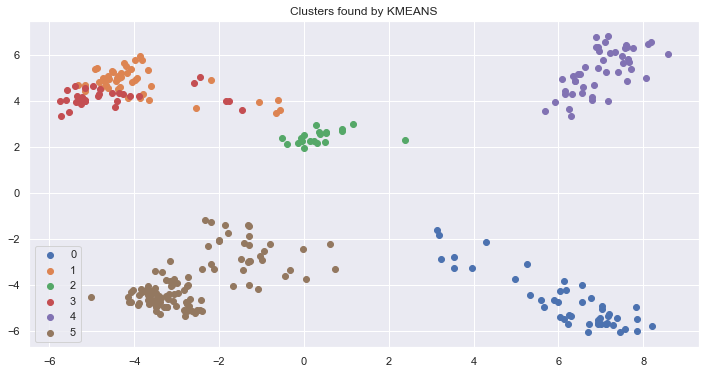

In [41]:
kmeans = SparkKmeans(featuresCol = 'features', k=ind)
model_k = kmeans.fit(cluster_final_data)
predictions  = model_k.transform(cluster_final_data).select('prediction').collect()
labels = [p.prediction for p in predictions ]
plot_clusters(pca_df, labels, "KMEANS")

### Spark Clustering - GMM

with K=2
with silhouette=0.10146679472655819
with K=3
with silhouette=0.32145017272458604
with K=4
with silhouette=0.3156090227724592
with K=5
with silhouette=0.16309178874030228
with K=6
with silhouette=0.1503173180232295
with K=7
with silhouette=0.1271714639292572
with K=8
with silhouette=0.03814626370021831
with K=9
with silhouette=0.04579192758411788
with K=10
with silhouette=0.08576274944169845
with K=11
with silhouette=0.13630480046574744
with K=12
with silhouette=0.09873276670532964
with K=13
with silhouette=0.09178373908100573
with K=14
with silhouette=0.04393624655579751
with K=15
with silhouette=-0.032087836665338564
with K=16
with silhouette=-0.02481975227047865
with K=17
with silhouette=-0.06011474400772499
with K=18
with silhouette=0.1258844787589919
with K=19
with silhouette=0.03941956155140316
best_n_clusters:  3
best_silhouette=0.32145017272458604


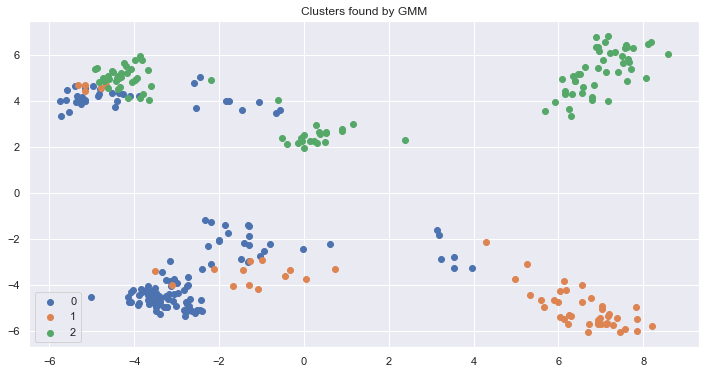

In [42]:
from pyspark.ml.clustering import GaussianMixture as GMM

sil = []

for k in range(2,20):
    gmm = GMM(seed=10).setK(k)
    model_k = gmm.fit(cluster_final_data)
    predictions = model_k.transform(cluster_final_data)
    silhouette = evaluator.evaluate(predictions)
    sil.append(silhouette)
    print("with K={}".format(k))
    print("with silhouette={}".format(silhouette))

ind = np.argmax(sil) + 2
print("best_n_clusters: ", ind)   
silhouette_max = np.amax(sil)
print("best_silhouette={}".format(silhouette_max))

# Trains Gaussian Mixture Model
gmm = GMM(seed=10).setK(ind)
model_k = gmm.fit(cluster_final_data)
predictions = model_k.transform(cluster_final_data).select('prediction').collect()
labels = [p.prediction for p in predictions ]
plot_clusters(pca_df, labels, "GMM")

## Car prices classification

#### Importing the Libraries

In [43]:
import requests
from bs4 import BeautifulSoup
import typing
import urllib
from time import sleep
from random import uniform
import random
import locale

**1. Collect DataSet**

In [44]:
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
x = opener.open('https://www.yad2.co.il/vehicles/private-cars?page=2')

In [45]:
headers = {
    'User-Agent': 'PostmanRuntime/7.26.8',
    'Accept': '*/*',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive',
    'Content-Type': 'application/x-www-form-urlencoded'
}
url = 'https://www.yad2.co.il/vehicles/private-cars?page=2'
jsonResponse = requests.post(url, headers= headers)

In [46]:
class Not200StatusCode(Exception):
    pass


class Parser:
    """
    Basic yad2.co.il parser, data parsing (apartment rentals) for the specified parameters
    Makes request to the site, parses the data, saves data to a list
    """
    base_url = 'https://www.yad2.co.il/vehicles/private-cars'
    manufacturer_url = '?manufacturer='
    model_url = '&model='
    group_color = '&group_color='
    pages_url = '&page={page_number}'
    year = '&year='

    def __init__(self, keywords, is_paginate=True, url=True):
        self.classification = keywords[1]
        self.keywords = keywords
        self.is_paginate = is_paginate
        self.url = url
        self.data = []

    def _make_url(self, keywords: list) -> str:
        """
        Generates a url based on parsing parameters.
        :param keywords: numbers of rooms, price, floor
        :return: url ready for parsing
        """
        # Adds url's with keywords to the base url
        self.url = self.base_url + self.manufacturer_url + str(keywords[0]) \
                   + self.model_url + str(keywords[1]) \
                   + self.group_color + str(keywords[2]) \
                   + self.year + str(keywords[3]) + '&priceOnly=1'
        return self.url

    def _pagination(self, page_number, pages_url):
        """
        Generates the url of the next page and sends a request to the site.
        :param page_number:
        :return: content html
        """
        url = self._make_url(keywords=self.keywords)
        url_pagination = url + pages_url.format(page_number=page_number)
        headers = {
            'Host': 'www.yad2.co.il',
            'Connection': 'keep-alive',
            'Pragma': 'no-cache',
            'Cache-Control': 'no-cache',
            'Upgrade-Insecure-Requests': '1',
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
            'Sec-Fetch-Site': 'none',
            'Sec-Fetch-Mode': 'navigate',
            'Sec-Fetch-User': '?1',
            'Sec-Fetch-Dest': 'document',
            'Accept-Encoding': 'gzip, deflate, br',
            'Accept-Language': 'en-US,en;q=0.9',
            'Cookie': 'recommendations-searched-vehicles=true; __uzma=c7cadb83-d6ce-4987-aa67-3c469736ca18; __uzmb=1612516098; __uzme=8743; abTestKey=41; _ga=GA1.3.371937583.1612516101; leadSaleRentFree=57; use_elastic_search=1; __ssds=3; __ssuzjsr3=a9be0cd8e; __gads=ID=48d4ec304510c4bf:T=1612516102:S=ALNI_MZSXiVO5ZMKNss0JZwHi9rENuabGg; _fbp=fb.2.1612516103733.821674275; _hjTLDTest=1; _hjid=1d400ae0-6bd4-41bb-adce-a6031b2330ed; bc.visitor_token=6742332496341942272; __uzmaj3=0679bf7e-912b-47fc-8545-73cdc585fcda; __uzmbj3=1612519564; canary=never; _gid=GA1.3.1121440698.1613126801; server_env=production; y2_cohort_2020=17; y2018-2-cohort=69; _hjIncludedInSessionSample=1; __uzmcj3=674293464901; __uzmdj3=1613153118; __uzmd=1613153120; __uzmc=2457380595843; favorites_userid=bjc320620000'
        }
        
        http_proxies = [
                "http://58.242.145.227:8080",
                "http://101.66.253.22:8080",
                "http://209.66.193.186:8080",
                "http://101.26.38.162:80",
                "http://123.7.88.171:3128",
                "http://50.207.44.18:3128",
                "http://117.169.14.81:8080",
                "http://177.133.140.243:3128",
                "http://122.4.244.121:80",
                "http://199.115.114.38:80",
            ]

        http_proxy = random.choice(http_proxies)

        proxy_dict = {
            "http": http_proxy
        }
        sleep(uniform(5, 8))

        response = requests.get(url_pagination, headers = headers, proxies=proxy_dict)
        
        sleep(uniform(5, 8))

        return response.content

    def _pars_block(self, blocks) -> typing.List[dict]:
        """
        Splits the page content into blocks
        Generates a dictionary for each data block and saves them to a list.
        :param blocks: the content of the page
        :return: list of data
        """
        sleep(uniform(5, 8))
        data = []
        counter = 0
        for block in blocks:
            print(block['item-id'])

            headers = {
               'Host': 'www.yad2.co.il',
                'Connection': 'keep-alive',
                'Pragma': 'no-cache',
                'Cache-Control': 'no-cache',
                'Accept': 'application/json, text/plain, /',
                'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.182 Safari/537.36',
                'Sec-Fetch-Site': 'same-origin',
                'Sec-Fetch-Mode': 'cors',
                'Sec-Fetch-Dest': 'empt',
                'Referer': 'https://www.yad2.co.il/vehicles/private-cars?manufacturer=22&model=1645&year=2014-2020&group_color=3,9,2,6,4,7,5,10,8,11,1&engineval=1000-3000',
                'Accept-Encoding': 'gzip, deflate, br',
                'Accept-Language': 'en-US,en;q=0.9',
                'Cookie': '__uzma=c7cadb83-d6ce-4987-aa67-3c469736ca18; __uzmb=1612516098; __uzme=8743; _ga=GA1.3.371937583.1612516101; leadSaleRentFree=57; use_elastic_search=1; __ssds=3; __ssuzjsr3=a9be0cd8e; __gads=ID=48d4ec304510c4bf:T=1612516102:S=ALNI_MZSXiVO5ZMKNss0JZwHi9rENuabGg; _fbp=fb.2.1612516103733.821674275; _hjTLDTest=1; _hjid=1d400ae0-6bd4-41bb-adce-a6031b2330ed; bc.visitor_token=6742332496341942272; __uzmaj3=0679bf7e-912b-47fc-8545-73cdc585fcda; __uzmbj3=1612519564; y2018-2-cohort=69; abTestKey=28; canary=never; _gid=GA1.3.1788963780.1614791460; server_env=production; y2_cohort_2020=91; recommendations-searched-vehicles=true; _hjIncludedInSessionSample=1; __uzmcj3=576307040876; __uzmdj3=1614795626; __uzmd=1614796072; __uzmc=69713150481216; favorites_userid=bjc320620000'
            }
                    
            image_url = block.find('img', class_='feedImage')
            car_name = block.find('span', class_='title')
            adress_block = block.find('div', class_='rows')
            middle_col = block.find('div', class_='middle_col')
            left_col = block.find('div', class_='left_col')
            ghost_price = left_col.find('div', class_='ghost_price')
            year = middle_col.find('div', class_='data')
            allData = middle_col.find_all('div', class_='data')

            for i, d in enumerate(allData): 
                if i == 0:
                    year = d.get_text()
                elif i == 1:
                    yad = d.get_text()
                elif i == 2:
                    volume = d.get_text()
                    
            color = str(self.keywords[2])
                
            #to do according to what returns
            d = {
                'id': counter,
                'img_url': image_url['src'],
                'car_name': adress_block.get_text(),
                'car_name2': car_name.get_text(),
                'classification': self.classification,
                'item_id': block['item-id'],
                'color': color,
                'year': year,
                'price': ghost_price.get_text(),
                'yad': yad,
                'volume': volume
            }
            
            print(d)
            
            print("car type: " , d["car_name2"])
            counter = counter + 1

            data.append(d)
        return data

    def parse_content(self, content: bytes, page_number=2) -> typing.List[dict]:
        """
        Recursive method.
        Gets content (blocks), parser it and saves the information to a list.
        Checks for pagination, parses the following pages.
        :param page_number:
        :param content: html
        :return: list of data
        """
        sleep(uniform(8, 15))

        soup = BeautifulSoup(content, 'html')
        
        #print(soup)
        
        blocks = soup.find_all('div', class_='feed_item feed_item-v4 accordion desktop')
        
        print("blocks:" , len(blocks))
        
        data = self._pars_block(blocks)
        self.data.extend(data)
        print('INFO: already parsed {} blocks'.format(len(self.data)))
    

        #print(data)
        
        sleep(uniform(8, 15))

        # find the button 'next' that is not active in the pagination
        paginated_block = soup.find('div', class_='pagination clickable')
        
        if paginated_block == None:
            button_next = True
        else:
            button_next = paginated_block.find('button', class_='page-num current-page-num')
            print('Next button: ', button_next)  # None

        # if pagination is enabled and button next is active
        if self.is_paginate and not button_next:
            sleep(uniform(8, 15))
            print('INFO: Try to paginate page number ', page_number)
            # get the content of the next page
            content = self._pagination(page_number, pages_url=self.pages_url)

            self.parse_content(content, page_number + 1)

        return self.data

    def send_request(self, url: str) -> bytes:
        """
        The method generates and sends a request to the site.
        Calls the sleep method to avoid being banned.
        :param url: url with search parameters
        :return: html content
        """
        sleep(uniform(3, 8))

        print('INFO: url is ', url)

        headers = {
            'Host': 'www.yad2.co.il',
            'Connection': 'keep-alive',
            'Pragma': 'no-cache',
            'Cache-Control': 'no-cache',
            'Upgrade-Insecure-Requests': '1',
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
            'Sec-Fetch-Site': 'none',
            'Sec-Fetch-Mode': 'navigate',
            'Sec-Fetch-User': '?1',
            'Sec-Fetch-Dest': 'document',
            'Accept-Encoding': 'gzip, deflate, br',
            'Accept-Language': 'en-US,en;q=0.9',
            'Cookie': 'recommendations-searched-vehicles=true; __uzma=c7cadb83-d6ce-4987-aa67-3c469736ca18; __uzmb=1612516098; __uzme=8743; abTestKey=41; _ga=GA1.3.371937583.1612516101; leadSaleRentFree=57; use_elastic_search=1; __ssds=3; __ssuzjsr3=a9be0cd8e; __gads=ID=48d4ec304510c4bf:T=1612516102:S=ALNI_MZSXiVO5ZMKNss0JZwHi9rENuabGg; _fbp=fb.2.1612516103733.821674275; _hjTLDTest=1; _hjid=1d400ae0-6bd4-41bb-adce-a6031b2330ed; bc.visitor_token=6742332496341942272; __uzmaj3=0679bf7e-912b-47fc-8545-73cdc585fcda; __uzmbj3=1612519564; canary=never; _gid=GA1.3.1121440698.1613126801; server_env=production; y2_cohort_2020=17; y2018-2-cohort=69; _hjIncludedInSessionSample=1; __uzmcj3=674293464901; __uzmdj3=1613153118; __uzmd=1613153120; __uzmc=2457380595843; favorites_userid=bjc320620000'
        }
        
        http_proxies = [
                "http://58.242.145.227:8080",
                "http://101.66.253.22:8080",
                "http://209.66.193.186:8080",
                "http://101.26.38.162:80",
                "http://123.7.88.171:3128",
                "http://50.207.44.18:3128",
                "http://117.169.14.81:8080",
                "http://177.133.140.243:3128",
                "http://122.4.244.121:80",
                "http://199.115.114.38:80",
            ]

        http_proxy = random.choice(http_proxies)

        proxy_dict = {
            "http": http_proxy
        }
        
        sleep(uniform(3, 8))

        response = requests.get(url, headers= headers,  proxies=proxy_dict)

        sleep(uniform(3, 8))

        if not response.status_code == 200:
            raise Not200StatusCode('Status code is: ', response.status_code)

        print('INFO: Status code is 200')
        # print(response.content)

        return response.content

    def start(self, keywords: list):
        self.keywords = keywords
        self.classification = keywords[1]
        self.data = []
        """
        Calls methods of the class.
        :param keywords: numbers of rooms, price, floor
        :return:
        """
        url = self._make_url(keywords)
        html_content = self.send_request(url)

        #print(html_content)  # Если забанили, показывает капчу

        data = self.parse_content(html_content)
        print('LEN DATA: ', len(data))

        return data

In [47]:
p = Parser([22, 1645, 10, '2014-2020'], True) # Mazda 3

In [48]:
def get_cars(filters):
    cars = []
    for filt in filters:
        cars.append(p.start(filt))
    return cars

In [49]:
cars = get_cars([[22, 1645, '10', '2004-2021']]) # Mazda 3
cars2 = get_cars([[22, 1645, '10', '2004-2021']]) # Mazda 3
print(cars2)
len(cars2[0])

INFO: url is  https://www.yad2.co.il/vehicles/private-cars?manufacturer=22&model=1645&group_color=10&year=2004-2021&priceOnly=1
INFO: Status code is 200
blocks: 18
ecj8gcrr
{'id': 0, 'img_url': 'https://img.yad2.co.il/Pic/202103/04/1_1/o/y2_1_02872_20210304080317.jpeg?l=7&c=3&w=195&h=117', 'car_name': '\n                        מאזדה 3\n                      Sport סדאן אוט\' 2.0 (165 כ"ס)', 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'ecj8gcrr', 'color': '10', 'year': '2017 שנה', 'price': '\n                    86,000 ₪\n                ', 'yad': '3 יד', 'volume': '1,998 סמ"ק'}
car type:  
                        מאזדה 3
                    
9hioqqfy
{'id': 1, 'img_url': 'https://img.yad2.co.il/Pic/202102/17/1_1/o/y2_1_01561_20210217110206.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Sport Comfort הצ'בק אוט' 1.6 (105 כ''ס)", 'car_name2': '\n                        מאזדה 3\

Next button:  None
INFO: Try to paginate page number  2
blocks: 18
t7wkbsv9
{'id': 0, 'img_url': 'https://img.yad2.co.il/Pic/202102/26/1_1/o/y2_1_01954_20210226190256.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.5 (120 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 't7wkbsv9', 'color': '10', 'year': '2015 שנה', 'price': '\n                    49,500 ₪\n                ', 'yad': '2 יד', 'volume': '1,496 סמ"ק'}
car type:  
                        מאזדה 3
                    
tgr4vube
{'id': 1, 'img_url': 'https://img.yad2.co.il/Pic/202102/04/1_1/o/y2_1_08035_20210204180222.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.6 (105 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'tgr4vube', 'color': '10', 'year': '2008 שנה'

Next button:  None
INFO: Try to paginate page number  3
blocks: 18
0280gsf8
{'id': 0, 'img_url': 'https://img.yad2.co.il/Pic/202101/30/1_1/o/y2_1_05264_20210130190126.jpeg?l=7&c=3&w=195&h=117', 'car_name': '\n                        מאזדה 3\n                      Comfort סדאן אוט\' 2.0 (165 כ"ס)', 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': '0280gsf8', 'color': '10', 'year': '2016 שנה', 'price': '\n                    70,000 ₪\n                ', 'yad': '1 יד', 'volume': '1,998 סמ"ק'}
car type:  
                        מאזדה 3
                    
5dlmedr4
{'id': 1, 'img_url': '//assets.yad2.co.il/yad2site/y2assets/images/pages/feed/feed_car_placeholder_small.png', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.5 (120 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': '5dlmedr4', 'color': '10', 'year': '2016 שנה', 'pri

Next button:  None
INFO: Try to paginate page number  4
blocks: 18
xru0vz72
{'id': 0, 'img_url': '//assets.yad2.co.il/yad2site/y2assets/images/pages/feed/feed_car_placeholder_small.png', 'car_name': '\n                        מאזדה 3\n                      ', 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'xru0vz72', 'color': '10', 'year': '2009 שנה', 'price': '\n                    15,250 ₪\n                ', 'yad': '4 יד', 'volume': '1,598 סמ"ק'}
car type:  
                        מאזדה 3
                    
c7govxor
{'id': 1, 'img_url': 'https://img.yad2.co.il/Pic/202103/08/1_1/o/y2_1_09228_20210308190358.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Comfort סדאן אוט' 1.6 (105 כ''ס) [2009-2012]", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'c7govxor', 'color': '10', 'year': '2011 שנה', 'price': '\n           

Next button:  None
INFO: Try to paginate page number  5
blocks: 29
rsh4nmxz
{'id': 0, 'img_url': 'https://img.yad2.co.il/Pic/202103/07/1_1/o/y2_1_04637_20210307120344.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.6 (105 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'rsh4nmxz', 'color': '10', 'year': '2011 שנה', 'price': '\n                    23,000 ₪\n                ', 'yad': '4 יד', 'volume': '1,598 סמ"ק'}
car type:  
                        מאזדה 3
                    
bsooze56
{'id': 1, 'img_url': 'https://img.yad2.co.il/Pic/202103/07/1_1/o/y2_1_02108_20210307110340.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.6 (105 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'bsooze56', 'color': '10', 'year': '2006 שנה'

Next button:  None
INFO: Try to paginate page number  6
blocks: 36
bcfdr0q5
{'id': 0, 'img_url': 'https://img.yad2.co.il/Pic/202102/08/1_1/o/y2_1_07917_20210208100250.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.6 (105 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'bcfdr0q5', 'color': '10', 'year': '2009 שנה', 'price': '\n                    11,500 ₪\n                ', 'yad': '4 יד', 'volume': '1,598 סמ"ק'}
car type:  
                        מאזדה 3
                    
4rn78gzw
{'id': 1, 'img_url': '//assets.yad2.co.il/yad2site/y2assets/images/pages/feed/feed_car_placeholder_small.png', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.6 (105 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': '4rn78gzw', 'color': '10', 'year': '2008 שנה', 'pric

Next button:  None
INFO: Try to paginate page number  7
blocks: 36
wdi924sz
{'id': 0, 'img_url': 'https://img.yad2.co.il/Pic/202102/06/1_1/o/y2_2_07936_20210206110257.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Comfort סדאן אוט' 1.6 (105 כ''ס) [2004-2009]", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'wdi924sz', 'color': '10', 'year': '2004 שנה', 'price': '\n                    8,500 ₪\n                ', 'yad': '2 יד', 'volume': '1,598 סמ"ק'}
car type:  
                        מאזדה 3
                    
s9agke5x
{'id': 1, 'img_url': 'https://img.yad2.co.il/Pic/202102/19/1_1/o/y2_1_05496_20210219180256.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.6 (105 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 's9agke5x', 'color': '10', 'year'

Next button:  None
INFO: Try to paginate page number  8
blocks: 10
s8sd9ip7
{'id': 0, 'img_url': 'https://img.yad2.co.il/Pic/202102/05/1_1/o/y2_1_09806_20210205020245.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Comfort סדאן אוט' 1.6 (105 כ''ס) [2009-2012]", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 's8sd9ip7', 'color': '10', 'year': '2009 שנה', 'price': '\n                    18,500 ₪\n                ', 'yad': '3 יד', 'volume': '1,598 סמ"ק'}
car type:  
                        מאזדה 3
                    
jo0tjsot
{'id': 1, 'img_url': 'https://img.yad2.co.il/Pic/202102/04/1_1/o/y2_2_02527_20210204110206.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.6 (105 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'jo0tjsot', 'color': '10', 'year

Next button:  None
INFO: Try to paginate page number  2
blocks: 18
t7wkbsv9
{'id': 0, 'img_url': 'https://img.yad2.co.il/Pic/202102/26/1_1/o/y2_1_01954_20210226190256.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.5 (120 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 't7wkbsv9', 'color': '10', 'year': '2015 שנה', 'price': '\n                    49,500 ₪\n                ', 'yad': '2 יד', 'volume': '1,496 סמ"ק'}
car type:  
                        מאזדה 3
                    
tgr4vube
{'id': 1, 'img_url': 'https://img.yad2.co.il/Pic/202102/04/1_1/o/y2_1_08035_20210204180222.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.6 (105 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'tgr4vube', 'color': '10', 'year': '2008 שנה'

Next button:  None
INFO: Try to paginate page number  3
blocks: 18
0280gsf8
{'id': 0, 'img_url': 'https://img.yad2.co.il/Pic/202101/30/1_1/o/y2_1_05264_20210130190126.jpeg?l=7&c=3&w=195&h=117', 'car_name': '\n                        מאזדה 3\n                      Comfort סדאן אוט\' 2.0 (165 כ"ס)', 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': '0280gsf8', 'color': '10', 'year': '2016 שנה', 'price': '\n                    70,000 ₪\n                ', 'yad': '1 יד', 'volume': '1,998 סמ"ק'}
car type:  
                        מאזדה 3
                    
5dlmedr4
{'id': 1, 'img_url': '//assets.yad2.co.il/yad2site/y2assets/images/pages/feed/feed_car_placeholder_small.png', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.5 (120 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': '5dlmedr4', 'color': '10', 'year': '2016 שנה', 'pri

Next button:  None
INFO: Try to paginate page number  4
blocks: 18
xru0vz72
{'id': 0, 'img_url': '//assets.yad2.co.il/yad2site/y2assets/images/pages/feed/feed_car_placeholder_small.png', 'car_name': '\n                        מאזדה 3\n                      ', 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'xru0vz72', 'color': '10', 'year': '2009 שנה', 'price': '\n                    15,250 ₪\n                ', 'yad': '4 יד', 'volume': '1,598 סמ"ק'}
car type:  
                        מאזדה 3
                    
c7govxor
{'id': 1, 'img_url': 'https://img.yad2.co.il/Pic/202103/08/1_1/o/y2_1_09228_20210308190358.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Comfort סדאן אוט' 1.6 (105 כ''ס) [2009-2012]", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'c7govxor', 'color': '10', 'year': '2011 שנה', 'price': '\n           

Next button:  None
INFO: Try to paginate page number  5
blocks: 29
rsh4nmxz
{'id': 0, 'img_url': 'https://img.yad2.co.il/Pic/202103/07/1_1/o/y2_1_04637_20210307120344.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.6 (105 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'rsh4nmxz', 'color': '10', 'year': '2011 שנה', 'price': '\n                    23,000 ₪\n                ', 'yad': '4 יד', 'volume': '1,598 סמ"ק'}
car type:  
                        מאזדה 3
                    
bsooze56
{'id': 1, 'img_url': 'https://img.yad2.co.il/Pic/202103/07/1_1/o/y2_1_02108_20210307110340.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.6 (105 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'bsooze56', 'color': '10', 'year': '2006 שנה'

Next button:  None
INFO: Try to paginate page number  6
blocks: 36
bcfdr0q5
{'id': 0, 'img_url': 'https://img.yad2.co.il/Pic/202102/08/1_1/o/y2_1_07917_20210208100250.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.6 (105 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'bcfdr0q5', 'color': '10', 'year': '2009 שנה', 'price': '\n                    11,500 ₪\n                ', 'yad': '4 יד', 'volume': '1,598 סמ"ק'}
car type:  
                        מאזדה 3
                    
4rn78gzw
{'id': 1, 'img_url': '//assets.yad2.co.il/yad2site/y2assets/images/pages/feed/feed_car_placeholder_small.png', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.6 (105 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': '4rn78gzw', 'color': '10', 'year': '2008 שנה', 'pric

Next button:  None
INFO: Try to paginate page number  7
blocks: 36
wdi924sz
{'id': 0, 'img_url': 'https://img.yad2.co.il/Pic/202102/06/1_1/o/y2_2_07936_20210206110257.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Comfort סדאן אוט' 1.6 (105 כ''ס) [2004-2009]", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'wdi924sz', 'color': '10', 'year': '2004 שנה', 'price': '\n                    8,500 ₪\n                ', 'yad': '2 יד', 'volume': '1,598 סמ"ק'}
car type:  
                        מאזדה 3
                    
s9agke5x
{'id': 1, 'img_url': 'https://img.yad2.co.il/Pic/202102/19/1_1/o/y2_1_05496_20210219180256.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Active סדאן אוט' 1.6 (105 כ''ס)", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 's9agke5x', 'color': '10', 'year'

Next button:  None
INFO: Try to paginate page number  8
blocks: 11
mjoyjzv9
{'id': 0, 'img_url': 'https://img.yad2.co.il/Pic/202102/06/1_1/o/y2_1_07659_20210206100226.jpeg?l=7&c=3&w=195&h=117', 'car_name': '\n                        מאזדה 3\n                      Sport סדאן אוט\' 2.0 (165 כ"ס)', 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 'mjoyjzv9', 'color': '10', 'year': '2019 שנה', 'price': '\n                    95,000 ₪\n                ', 'yad': '2 יד', 'volume': '1,998 סמ"ק'}
car type:  
                        מאזדה 3
                    
s8sd9ip7
{'id': 1, 'img_url': 'https://img.yad2.co.il/Pic/202102/05/1_1/o/y2_1_09806_20210205020245.jpeg?l=7&c=3&w=195&h=117', 'car_name': "\n                        מאזדה 3\n                      Comfort סדאן אוט' 1.6 (105 כ''ס) [2009-2012]", 'car_name2': '\n                        מאזדה 3\n                    ', 'classification': 1645, 'item_id': 's8sd9ip7', 'color': '10', 'year'

184

**2. Convert Data To Data Frame**

In [50]:
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 
print(locale.atoi('1,000,000'))

counter = 0
d = {}
arr = []
for car in cars2[0]:
    counter = counter + 1
    #print("counter: ", counter)
    print(car['yad'].replace("יד", "").strip())
    arr.append([int(car['year'].replace("שנה", "").strip()),
                int(locale.atoi(car['price'].replace("₪", "").strip())),
                int(car['yad'].replace("יד", "").replace("+", "").strip()),
                int(locale.atoi(car['volume'].replace('סמ"ק', "")))])

df = pd.DataFrame(np.array(arr), columns=['year', 'price', 'yad', 'volume'])
print(df)

1000000
3
2
2
2
4
2
3
3
2
2
2
4
2
2
1
1
2
3
2
3
5
2
2
2
2
2
2
3
2
2
2
2
1
6
1
3
1
2
2
2
2
1
3
2
2
2
2
3
2
3
2
3
2
3
4
3
1
2
2
2
3
2
1
2
2
3
2
2
2
2
3
1
4
2
5
3
3
3
3
3
4
7
3
3
3
3
2
2
3
10+
3
2
1
3
3
1
2
3
2
1
2
4
2
2
1
6
2
2
2
3
7
3
4
2
2
2
3
3
1
3
1
4
3
3
3
3
4
3
2
2
9
3
4
3
1
2
3
2
3
2
1
3
2
3
2
2
2
2
2
5
5
4
1
3
3
2
3
1
3
4
1
3
2
2
2
3
1
2
4
2
3
3
2
2
3
3
2
4
3
4
2
2
2
2
     year  price  yad  volume
0    2017  86000    3    1998
1    2012  33000    2    1598
2    2008  15000    2    1598
3    2018  96000    2    1998
4    2016  78500    4    1998
..    ...    ...  ...     ...
179  2008  18000    4    1999
180  2008   8500    2    1598
181  2009  21000    2    1598
182  2010  18000    2    1598
183  2015  75000    2    1998

[184 rows x 4 columns]


**3. Visualisation**

Text(0.5, 1.0, 'volume')

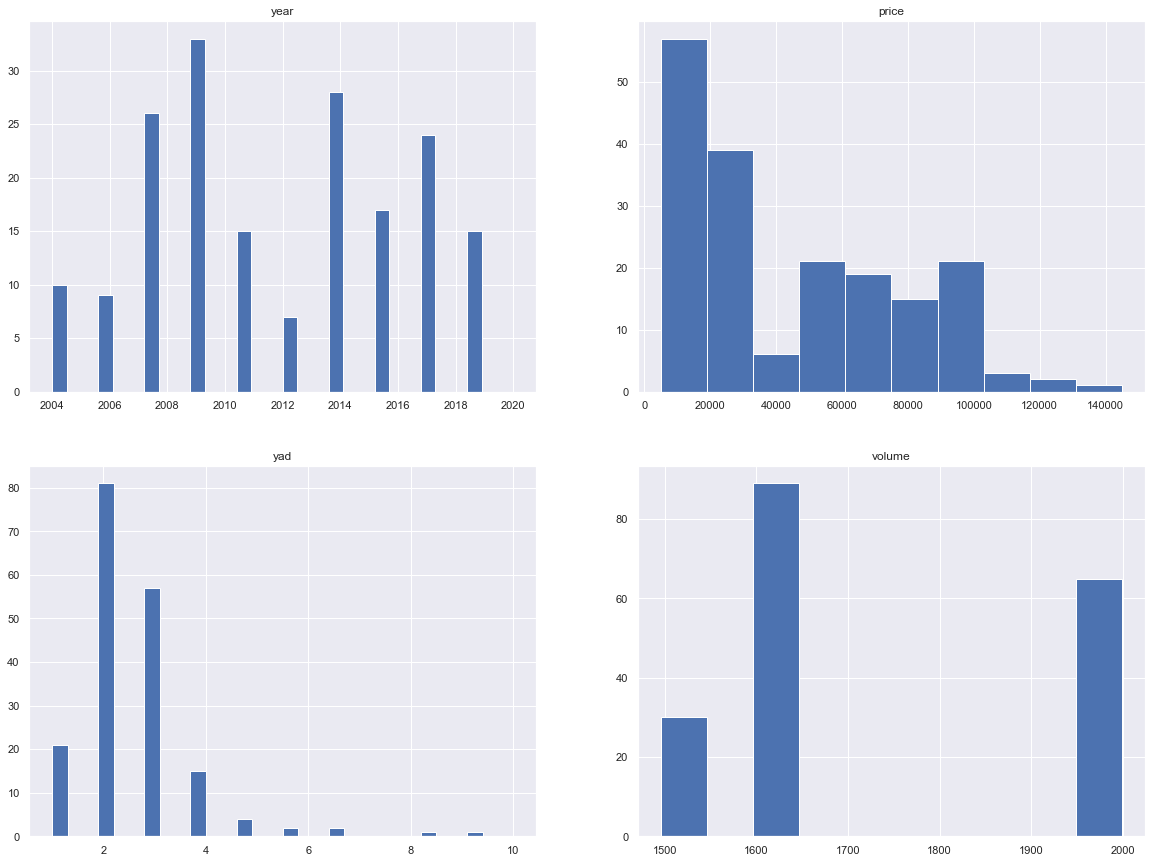

In [51]:
fig, axs = plt.subplots(2, 2, figsize=(20,15))  

axs[0,0].hist(df.year , width=0.5)
axs[0,0].set_title("year")
axs[0,1].hist(df.price) 
axs[0,1].set_title("price")
axs[1,0].hist(df.yad , width=0.3, align ='mid')
axs[1,0].set_title("yad")
axs[1,1].hist(df.volume)
axs[1,1].set_title("volume")

Text(0.5, 1.0, 'volume vs price')

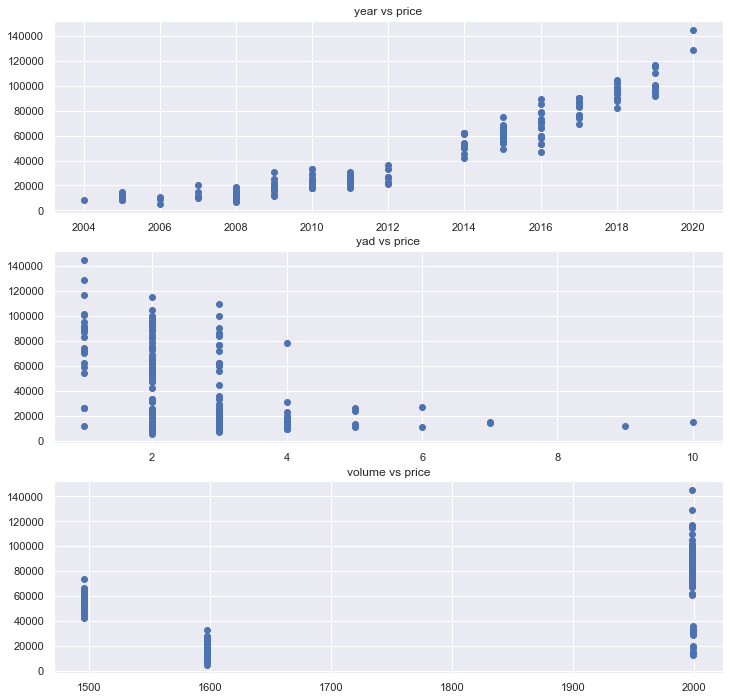

In [52]:
fig, axs = plt.subplots(3, figsize=(12,12)) 
axs[0].scatter(df.year, df.price)
axs[0].set_title("year vs price")
axs[1].scatter(df.yad, df.price)
axs[1].set_title("yad vs price")
axs[2].scatter(df.volume, df.price)
axs[2].set_title("volume vs price")

C:\Users\Haliva\anaconda3\envs\myenv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Haliva\anaconda3\envs\myenv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Haliva\anaconda3\envs\myenv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  Fut

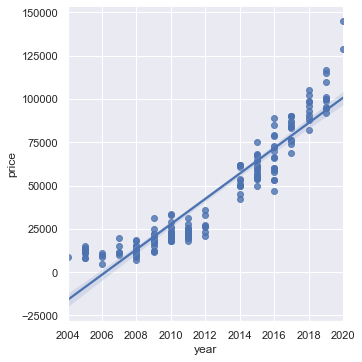

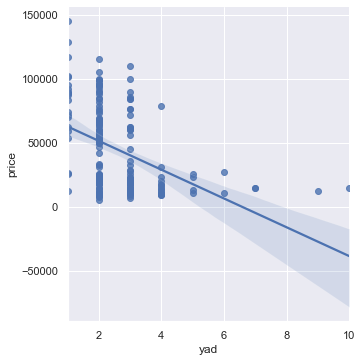

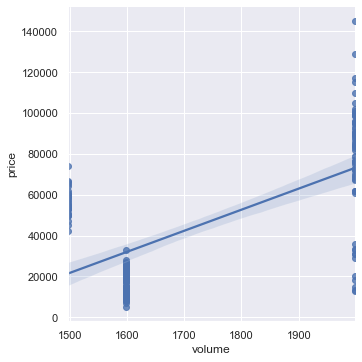

In [53]:
import seaborn as sns
sns.lmplot('year','price', data=df)
sns.lmplot('yad','price', data=df)
sns.lmplot('volume','price', data=df)

C:\Users\Haliva\anaconda3\envs\myenv\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Haliva\anaconda3\envs\myenv\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Haliva\anaconda3\envs\myenv\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Haliva\anaconda3\envs\myenv\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Haliva\anaconda3\envs\myenv\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Haliva\anaconda3\envs\myenv\lib\site-packages\seaborn\distributions.py:306: 

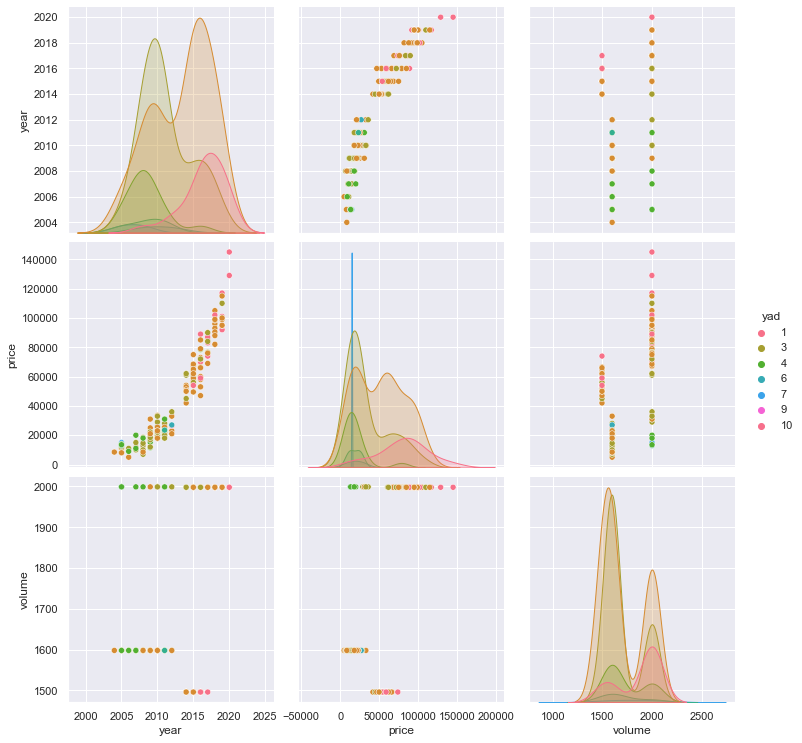

In [54]:
sns.pairplot(df,hue = 'yad',diag_kind = "kde",kind = "scatter",palette = "husl",height=3.5)
plt.show()

**4.Classification Algorithms**

In [56]:
import json
import pickle

from sklearn.linear_model import LinearRegression #Linear Regression
from sklearn.linear_model import Lasso #Lasso Regression
from sklearn.tree import DecisionTreeRegressor #Decision Tree Regression
from sklearn.ensemble import RandomForestRegressor #Random Forest Regression
from sklearn.model_selection import train_test_split #Splitting the dataset into training and testing

In [57]:
X = pd.concat([df.drop(['price'],axis=1)], axis=1)
y = df['price']

In [58]:
X.head(5)

year  yad  volume
0  2017    3    1998
1  2012    2    1598
2  2008    2    1598
3  2018    2    1998
4  2016    4    1998

In [59]:
y.head(5)

0    86000
1    33000
2    15000
3    96000
4    78500
Name: price, dtype: int32

### LinearRegression

In [60]:
lreg = LinearRegression()
lreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [61]:
lreg.coef_

array([6249.57301132, -889.7874083 ,   38.22232082])

In [62]:
lreg.intercept_

-12595004.901825756

In [63]:
coeff_df = pd.DataFrame(df.columns)
coeff_df.columns = ['Features']
coeff_df['Value'] = pd.Series(lreg.coef_)
coeff_df

Features        Value
0     year  6249.573011
1    price  -889.787408
2      yad    38.222321
3   volume          NaN

**Train/Test**

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [65]:
X_train.shape

(147, 3)

In [66]:
y_train.shape

(147,)

In [67]:
X_test.shape 

(37, 3)

In [68]:
y_test.shape

(37,)

In [69]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [70]:
pred_test = lr.predict(X_test)
np.mean((y_test - pred_test)**2)

58227014.07752435

In [71]:
pred_train = lreg.predict(X_train)
np.mean((y_train - pred_train)**2)

70516594.54430278

In [72]:
pred_test

array([72709.96532401, -6573.625483  , 18301.0035486 , 17339.82539406,
       25721.13349968, 92086.82071362, 19262.18170314, 33992.98972691,
       12803.22990661, 31218.90714167, -1075.851841  , 24759.95534514,
       72709.96532401, 31218.90714167,  3351.29176807, 11842.05175207,
       -7534.80363754, 11842.05175207, 22837.59903606, 98545.77251015,
       25721.13349968, 85627.86891708, 65289.83537294, 38639.03709275,
       -2037.02999554, 31218.90714167, 53307.72575319, 30257.72898713,
        4421.92180099, 12803.22990661, 84666.69076254, 25721.13349968,
       39600.21524729, 84666.69076254, 60727.85570426, 11842.05175207,
       18301.0035486 ])

In [73]:
lr.score(X_test,y_test)

0.9153772922418915

In [74]:
from sklearn.metrics import mean_squared_error, r2_score
print('Mean squared error: %.2f' % mean_squared_error(y_test, pred_test))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, pred_test))

Mean squared error: 58227014.08
Coefficient of determination: 0.92


### Naive_Bayes

In [75]:
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB() 
gnb.fit(X_train, y_train) 
  
# making predictions on the testing set 
y_pred = gnb.predict(X_test) 

from sklearn import metrics 
print("Gaussian Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)

print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

Gaussian Naive Bayes model accuracy(in %): 2.7027027027027026
Mean squared error: 49614859.05
Coefficient of determination: 0.93


As you can see, we are getting low score from Linear Regression. Let's see if we can get better results from different regression models.

## Find best model using GridSearchCV

In [76]:
from sklearn.model_selection import ShuffleSplit #Random shuffling
from sklearn.model_selection import cross_val_score #Score cross validation
from sklearn.model_selection import GridSearchCV #Hyper parameter tuning
from warnings import simplefilter #Filtering warnings
from sklearn.metrics import r2_score
simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [77]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.92034888, 0.91646071, 0.95291813, 0.93956265, 0.96430191])

In [78]:
import xgboost as xgb
def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        },
        'random_forest': {
            'model': RandomForestRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'n_estimators': range(1,50,5)
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

model  best_score                                 best_params
0  linear_regression    0.938718                         {'normalize': True}
1              lasso    0.938718         {'alpha': 1, 'selection': 'cyclic'}
2      decision_tree    0.966489  {'criterion': 'mse', 'splitter': 'random'}
3      random_forest    0.965056    {'criterion': 'mse', 'n_estimators': 16}

### Predict price

In [83]:
model = RandomForestRegressor(criterion='mse',n_estimators=16)

In [84]:
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=16,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [85]:
model.score(X_test,y_test)

0.9602621558922111

In [86]:
def predict_price(yad,year,volume):
    x = []
    x[:3] = np.zeros(3,dtype='int32')
    x[0] = year
    x[1] = yad
    x[2] = volume
    
    
    result = model.predict([x])
    
    return float(format(model.predict([x])[0],'.3f'))

In [87]:
predict_price('3', '2014', '2000')

60843.75

In [88]:
predict_price('1', '2020', '2000')

135348.375

In [89]:
predict_price('1', '2016', '2000')

76419.271

### Predict price vs Yad2_price_list

In [90]:
def find_price_yad2_price_list(year, subModelId):

    url_yad2_pricelist = "http://pricelist.yad2.co.il/cardetails_n.php?SubModelID=" + str(subModelId) + "&Year=" + str(year)

    print("url for downloading: ", url_yad2_pricelist)
    
    headers = {
        'Host': 'pricelist.yad2.co.il',
        'Connection': 'keep-alive',
        'Pragma': 'no-cache',
        'Cache-Control': 'no-cache',
        'Upgrade-Insecure-Requests': '1',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.182 Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
        'Referer': 'http://validate.perfdrive.com/',
        'Accept-Encoding': 'gzip, deflate',
        'Accept-Language': 'en-US,en;q=0.9',
        'Cookie': '_ga=GA1.3.371937583.1612516101; leadSaleRentFree=57; __ssds=3; __ssuzjsr3=a9be0cd8e; __gads=ID=48d4ec304510c4bf:T=1612516102:S=ALNI_MZSXiVO5ZMKNss0JZwHi9rENuabGg; _fbp=fb.2.1612516103733.821674275; _hjTLDTest=1; _hjid=1d400ae0-6bd4-41bb-adce-a6031b2330ed; __uzmaj3=0679bf7e-912b-47fc-8545-73cdc585fcda; __uzmbj3=1612519564; y2018-2-cohort=69; abTestKey=28; historyprimaryarea=hamerkaz_area_Multiple___hamerkaz_area_Multiple; historysecondaryarea=+___+; __uzma=5beca20f-8081-41a1-bdb9-87ad8d58dc6c; __uzmb=1614870802; __uzme=2239; y2session=ud6ldu0vvgsmsu9n8vvo9nhhj7; PricelistHash=24a9876f0a08adcd282ff833f96d2047; _ga=GA1.4.371937583.1612516101; use_elastic_search=1; _gid=GA1.3.766821828.1615230266; server_env=production; y2_cohort_2020=55; _gid=GA1.4.766821828.1615230266; __uzmcj3=617428593311; __uzmdj3=1615289879; favorites_userid=bjc320620000; _dc_gtm_UA-708051-1=1; __uzmc=748779778316; __uzmd=1615290866'
    }
        
    http_proxies = [
            "http://58.242.145.227:8080",
            "http://101.66.253.22:8080",
            "http://209.66.193.186:8080",
            "http://101.26.38.162:80",
            "http://123.7.88.171:3128",
            "http://50.207.44.18:3128",
            "http://117.169.14.81:8080",
            "http://177.133.140.243:3128",
            "http://122.4.244.121:80",
            "http://199.115.114.38:80",
        ]

    http_proxy = random.choice(http_proxies)

    proxy_dict = {
        "http": http_proxy
    }
    
    response = requests.get(url_yad2_pricelist, headers = headers)

    content = response.content

    #print(content)
    
    soup = BeautifulSoup(content, 'html')

    price_tag = soup.find('div', class_='priceTicket').get_text()
    
    return price_tag

    print(price_tag)

In [91]:
predictedX = X_test,y_test
predict_price('1', '2016', '2000')
find_price_yad2_price_list(2016, 27049)

url for downloading:  http://pricelist.yad2.co.il/cardetails_n.php?SubModelID=27049&Year=2016


'\n\n79,400 ₪\n\n'

In [92]:
print(X_test)
for x in X_test:
    print(x) 

     year  yad  volume
61   2015    2    1998
114  2005    2    1598
127  2009    3    1598
101  2009    4    1598
182  2010    2    1598
63   2018    2    1998
10   2009    2    1598
91   2009    2    1999
2    2008    2    1598
55   2011    3    1598
119  2006    3    1598
175  2010    3    1598
46   2015    2    1998
138  2011    3    1598
81   2005    7    1999
19   2008    3    1598
90   2005    3    1598
70   2008    3    1598
20   2010    5    1598
128  2019    2    1998
67   2010    2    1598
39   2017    2    1998
154  2014    3    1998
1    2012    2    1598
159  2006    4    1598
60   2011    3    1598
35   2015    3    1496
72   2011    4    1598
112  2007    4    1598
102  2008    2    1598
83   2017    3    1998
68   2010    2    1598
95   2012    1    1598
131  2017    3    1998
144  2016    2    1496
47   2008    3    1598
174  2009    3    1598
year
yad
volume


In [93]:
df1 = pd.DataFrame(X_test)
df2 = pd.DataFrame(y_test)

In [94]:
print(df1.describe())

              year        yad       volume
count    37.000000  37.000000    37.000000
mean   2010.810811   2.810811  1700.648649
std       3.900412   1.075945   185.033813
min    2005.000000   1.000000  1496.000000
25%    2008.000000   2.000000  1598.000000
50%    2010.000000   3.000000  1598.000000
75%    2014.000000   3.000000  1998.000000
max    2019.000000   7.000000  1999.000000


In [95]:
print(df2.describe())

              price
count     37.000000
mean   33741.135135
std    26593.066074
min     8000.000000
25%    15000.000000
50%    23000.000000
75%    47000.000000
max    99000.000000


In [96]:
from sklearn import metrics 
import numpy as np


list_true = []
list_pred = []


for first, second in zip(df2.iterrows(), df1.iterrows()):
    index, row = first
    index2, row2 = second
    
    real_result = row['price']
    predicted_result = predict_price(row2['yad'], row2['year'], row2['volume'])
    list_true.append(real_result)
    list_pred.append(predicted_result)
    print("true: ", real_result, "predicted: ", predicted_result)


true:  68500 predicted:  69687.5
true:  8000 predicted:  10375.0
true:  22222 predicted:  15106.845
true:  11500 predicted:  15992.708
true:  18000 predicted:  21092.175
true:  82000 predicted:  95912.175
true:  25000 predicted:  20273.958
true:  31000 predicted:  24730.208
true:  15000 predicted:  12011.272
true:  25700 predicted:  20603.224
true:  11000 predicted:  8604.167
true:  22000 predicted:  21110.113
true:  67500 predicted:  69687.5
true:  20000 predicted:  20603.224
true:  15000 predicted:  13562.5
true:  14000 predicted:  12760.553
true:  12000 predicted:  9706.25
true:  15000 predicted:  12760.553
true:  26000 predicted:  22243.211
true:  99000 predicted:  98587.087
true:  23000 predicted:  21092.175
true:  90000 predicted:  77375.298
true:  62000 predicted:  60843.75
true:  33000 predicted:  22750.0
true:  9000 predicted:  10991.927
true:  28000 predicted:  20603.224
true:  61000 predicted:  57599.202
true:  23000 predicted:  20745.412
true:  11000 predicted:  11230.469
t

**Calculating MSE, RMSE, ABE:**

In [97]:
print('Mean Absolute Error:', metrics.mean_absolute_error(list_true, list_pred)) 
print('Mean Squared Error:', metrics.mean_squared_error(list_true, list_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(list_true, list_pred)))

Mean Absolute Error: 3879.6494594594596
Mean Squared Error: 27342732.06272287
Root Mean Squared Error: 5229.027831511597
